# Introduction

Human Activity Recognition is the task of predicting the physical activity being performed by a person based on sensor measurements from a wearable device. In this project, our goal is to predict the activity of a user using data collected from a smartphone's accelerometer and gyroscope. This is a multi-class classification problem, with six possible classes:

- WALKING
- WALKING UPSTAIRS
- WALKING DOWNSTAIRS
- SITTING
- STANDING
- LAYING

The dataset used in this project contains time-series data from the accelerometer and gyroscope sensors, as well as additional derived features such as jerk signals and Fourier-transformed frequency domain signals. The raw sensor data has been pre-processed to remove noise and separate the gravitational and body motion components of the acceleration signal.

Our task is to use this data to build a machine learning model that can accurately predict the activity of the user based on the sensor measurements. We will use the training dataset to train our model, and then evaluate its performance on the testing dataset.

The ultimate goal of this project is to build a model that can be used in real-world applications to monitor and track human activity. This could have important applications in fields such as healthcare and fitness tracking, where accurate activity recognition can help to improve patient outcomes and promote healthy behaviors.

**<H2>Part one</H2>**

This part of the project is focused on creating a recurrent neural network (RNN) model to classify the activities performed by users into two main categories: **Stationary** and **Moving** activities. This classification is achieved by utilizing the sensor readings from the accelerometer and gyroscope. The data from these sensors is used to train the RNN model, which is able to learn the patterns and features in the data associated with the two activity types. The RNN model will be trained to classify the activities into 2 classes:
- Stationary Activities:
 - SITTING
 - STANDING
 - LAYING
- Moving Activities:
 - Moving activities: WALKING
 - WALKING_UPSTAIRS
 - WALKING_DOWNSTAIRS


**<H2>Part two</H2>**
Part two of the project involves creating a time series dataframe from the separated files for accelerometer (ACC) and gyroscope (Gyro) signals. This will be achieved by collecting readings at fixed time intervals, to create a data point that represents the values of the accelerometer and gyroscope at that point in time. The time series dataframe will be created by concatenating these data points along the time axis to create a sequence of data that represents the user's activity.

Once the time series dataframe has been created, it will be used for training a Long Short-Term Memory (LSTM) model to predict the user's activity from the pre-activity readings. The LSTM model will be trained to classify the activities into 6 classes: 
- WALKING
- WALKING_UPSTAIRS
- WALKING_DOWNSTAIRS
- SITTING
- STANDING
- LAYING


# Libraries

In [ ]:
!pip install pygwalker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.5/707.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pygwalker as pyg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from sklearn.manifold import TSNE
import os
from glob import glob

In [ ]:
# Set the warning filter to "ignore"
warnings.filterwarnings("ignore")

#Methods

In [ ]:
def _plot_count(x, data,hue='',figsize_w= 20,figsize_h= 10,plt_title='',x_label ='',y_label=''):
  plt.figure(figsize = (figsize_w,figsize_h))

  if len(hue) == 0:
    sns.countplot(x = x, data = data);
  else:
     sns.countplot(hue=hue,x = x, data = data);
  plt.title(plt_title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

def _plot_facetgrid(
    df,
    hue,
    column_name,
    palette="Set0",
    desat=0.50,
    size=5,
    aspect=4,
    hist=False): 
  sns.set_palette(palette, desat=desat)
  facetgrid = sns.FacetGrid(df, hue=hue, size=size,aspect=aspect)
  facetgrid.map(sns.distplot,column_name, hist=hist).add_legend()

def _plot_facetgrids(df, hue, column_names, palette="Set0", desat=0.50, size=5, aspect=4, hist=False):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    num_cols = 3
    num_rows = int(np.ceil(len(column_names) / num_cols))
    sns.set_palette(palette, desat=desat)
    facetgrid = sns.FacetGrid(df, hue=hue, size=size,aspect=aspect, col_wrap=num_cols)
    for i, column_name in enumerate(column_names):
        row = int(i / num_cols)
        col = i % num_cols
        facetgrid.map(sns.distplot, column_name, hist=hist).add_legend()
        facetgrid.axes[row * num_cols + col].set_title(column_name)

def tsne_ptl(
    df,
    drop_columns,
    hue,
    random_state = 40,
    n_components = 2, #the number of dimensions of the embedded space
    verbose = 1,  #to used with  random seed
    perplexity = 50, #balance between preserving local and global structure when transforming high-dimensional data into a lower-dimensional space.
    n_iter = 2000):
  tsne_data = df.drop(drop_columns, axis = 1)
  %time
  tsne = TSNE(random_state = random_state, n_components = n_components, verbose = verbose, perplexity = perplexity, n_iter = n_iter).fit_transform(tsne_data)
  plt.figure(figsize = (12,8))
  sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue = df[hue], palette = "bright")


def get_file_paths(folder):
   return sorted(glob(folder))

def import_Raw_Data(folder):
    #get a list of paths for all files in the RawData folder
    paths = get_file_paths(folder) 

    # Creating a dictionary where all dataframes will be stored
    _dic = {}

    # acc columns names
    acc_cols = ['accX', 'accY', 'accZ']

    # gyro columns names
    gyro_columns = ['gyroX', 'gyroY', 'gyroZ']

    # store "acc and gyro files" into a data dictionnary.
    # The indexes of the acc files range from 1 to 61, 
    # and the indexes of the gyro files range from 62 to 122.
    for path_index in range(0, 61):

        # file name only without "acc" or "gyro"
        dic_key = paths[path_index][-16:-4]

        # open the txt file
        opened_file =open(paths[path_index],'r')

        acc_file_content=[]

        # convert content from text format to float
        for row in opened_file:
            acc_file_content.append([float(item) for item in row.split()])

        # ==> 2D numpy array with columns names
        data=np.array(acc_file_content)
        acc_df = pd.DataFrame(data=data, columns=acc_cols)

        # the corresponding gyroscope data file can be obtained by shifting the path_index by 61
        shift = 61
        opened_file =open(paths[path_index + shift],'r')

        # Create a list
        gyro_file_content=[]

        # convert content from text format to float
        for row in opened_file:
            gyro_file_content.append([float(item) for item in row.split()])

        # ==> 2D numpy array with columns names
        data=np.array(gyro_file_content)
        gyro_df = pd.DataFrame(data=data, columns=gyro_columns)

        # concatenate acc_df and gyro_df in one DataFrame
        signals_df = pd.concat([acc_df, gyro_df], axis=1)

        # Store this new DataFrame in the dictionary
        _dic[dic_key] = signals_df

    return _dic

def plot_signal(
    df,
    signal_type,
    fig_title='fig_title',
    fig_x_title='Time(in seconds)',
    fig_y_title='Acceleration',
    x_legend_title='x',
    y_legend_title='y',
    z_legend_title='z',
    width = 20,
    height = 5,
    colors=['r','b','g'],
    legend_loc = "upper left"
):
    if signal_type=='a':
      x_data=df[df.columns[0]]
      y_data=df[df.columns[1]]
      z_data=df[df.columns[2]]
    elif signal_type=='g':
      x_data=df[df.columns[3]]
      y_data=df[df.columns[4]]
      z_data=df[df.columns[5]]


    # generate time duration (the duration between two rows is 1/50=0.02 second)
    freq = 50 #50Hz
    time_points=[1/float(freq) *r for r in range(df.shape[0])]
    fig = plt.figure(figsize=(width,height))

    # ploting the signals data
    plt.plot(time_points,x_data,color=colors[0],label=x_legend_title)
    plt.plot(time_points,y_data,color=colors[1],label=y_legend_title)
    plt.plot(time_points,z_data,color=colors[2],label=z_legend_title)

    plt.title(fig_title)
    plt.xlabel(fig_x_title)
    plt.ylabel(fig_y_title)
  
    # figure's legends location
    plt.legend(loc=legend_loc)

    plt.show()

def get_windows_activities_user(df):
  user_Ids = sorted(df['user_Id'].unique())
  activity_Ids = sorted(df['activity_Id'].unique())

  cols = list(map(lambda Id: "activity_" + str(int(Id)), activity_Ids))
  indexs = list(map(lambda Id: "user_" + str(int(Id)), user_Ids))

  # initialize data array
  data = np.zeros((len(user_Ids), len(activity_Ids)))

  # loop over users and activities
  for i, user_ID in enumerate(user_Ids):
      for j, activity_ID in enumerate(activity_Ids):
          # filter the dataframe by user and activity
          filtered_df = df[(df["user_Id"] == user_ID) & (df["activity_Id"] == activity_ID)]
          # count the number of rows in the filtered dataframe
          count = len(filtered_df)
          # store the count in the data array
          data[i, j] = count

  return pd.DataFrame(data = data,columns=cols,index=indexs)

def df_balance(df,group_by_column,classes):
  # group data by 'group_by_column' and find the total number of rows 
  total = (df.groupby(by=group_by_column).size()).values

  for index in range(len(total)):
    p = total[index] / len(df) * 100
    print('%s, total=%d, percentage=%.3f' % (classes[index], total[index], p))

# Configuration

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
google_driver_path = '/content/gdrive/My Drive/IoT Final Project/HAPT Data Set/'

# Part One

## Load Data

In [ ]:
# Read the training data files:
# X_train.txt
# y_train.txt
# subject_id_train.txt: each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30.
X_train_df = pd.read_csv(google_driver_path + 'Train/X_train.txt', header=None, sep='\s+')
y_train_df = pd.read_csv(google_driver_path + 'Train/y_train.txt', header=None, sep='\s+')
users_train_df = pd.read_csv(google_driver_path + 'Train/subject_id_train.txt', header=None, sep='\s+')

In [ ]:
# Read the test data files
# X_test.txt
# y_test.txt
# subject_id_test.txt: each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30.
X_test_df = pd.read_csv(google_driver_path + 'Test/X_test.txt', header=None, sep='\s+')
y_test_df = pd.read_csv(google_driver_path + 'Test/y_test.txt', header=None, sep='\s+')
users_test_df = pd.read_csv(google_driver_path + 'Test/subject_id_test.txt', header=None, sep='\s+')

In [ ]:
# Read the activity labels file
# activity_labels.txt: links the activity ID with their activity name.
activity_labels_df = pd.read_csv(google_driver_path + 'activity_labels.txt', header=None, sep='\s+', names=['activity_id', 'activity_name'])

In [ ]:
# Read the features file
# features.txt: list of all features.
features_df = pd.read_csv(google_driver_path + 'features.txt', header=None, sep='\s+', names=['feature_name'])
features_df.insert(0, 'feature_id', range(0, len(features_df)))

In [ ]:
# train X and y shapes
print('X_train Shape:',X_train_df.shape)
print('y_train Shape:',y_train_df.shape)

X_train Shape: (7767, 561)
y_train Shape: (7767, 1)


In [ ]:
# test X and y shapes
print('X_test Shape:',X_test_df.shape)
print('y_test Shape:',y_test_df.shape)

X_test Shape: (3162, 561)
y_test Shape: (3162, 1)


In [ ]:
# show all activities
# there are 12 activities:
# MOT (Movement on foo): WALKING, WALKING_UPSTAIRS and WALKING_DOWNSTAIRS
# SIT (Sedentary inactivity): SITTING, STANDING and LAYING
# POS (Postural transitions): STAND_TO_SIT, SIT_TO_STAND, SIT_TO_LIE, LIE_TO_SIT, STAND_TO_LIE and LIE_TO_STAND
activity_labels_df.head(len(activity_labels_df))

activity_id       activity_name
0             1             WALKING
1             2    WALKING_UPSTAIRS
2             3  WALKING_DOWNSTAIRS
3             4             SITTING
4             5            STANDING
5             6              LAYING
6             7        STAND_TO_SIT
7             8        SIT_TO_STAND
8             9          SIT_TO_LIE
9            10          LIE_TO_SIT
10           11        STAND_TO_LIE
11           12        LIE_TO_STAND

In [ ]:
# show all features
# there are 561 features:
features_df

feature_id                     feature_name
0             0                  tBodyAcc-Mean-1
1             1                  tBodyAcc-Mean-2
2             2                  tBodyAcc-Mean-3
3             3                   tBodyAcc-STD-1
4             4                   tBodyAcc-STD-2
..          ...                              ...
556         556      tBodyGyro-AngleWRTGravity-1
557         557  tBodyGyroJerk-AngleWRTGravity-1
558         558      tXAxisAcc-AngleWRTGravity-1
559         559      tYAxisAcc-AngleWRTGravity-1
560         560      tZAxisAcc-AngleWRTGravity-1

[561 rows x 2 columns]

##  Preparing Data

In [ ]:
# make a copy
X_train_df1 = X_train_df.copy()
X_test_df1 = X_test_df.copy()

The training and testing datasets use feature IDs as column names, so we need to replace those with their corresponding feature names from the features dataframe in order to improve clarity.

In [ ]:
X_train_df1.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            551, 552, 553, 554, 555, 556, 557, 558, 559, 560],
           dtype='int64', length=561)

In [ ]:
X_test_df1.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            551, 552, 553, 554, 555, 556, 557, 558, 559, 560],
           dtype='int64', length=561)

In [ ]:
#Replace feature_ids with their corresponding feature names from the features dataframe.
X_train_df1 = X_train_df1.rename(columns=features_df.set_index('feature_id')['feature_name'])
X_test_df1 = X_test_df1.rename(columns=features_df.set_index('feature_id')['feature_name'])

In [ ]:
X_train_df1.columns

Index(['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3',
       'tBodyAcc-STD-1', 'tBodyAcc-STD-2', 'tBodyAcc-STD-3', 'tBodyAcc-Mad-1',
       'tBodyAcc-Mad-2', 'tBodyAcc-Mad-3', 'tBodyAcc-Max-1',
       ...
       'fBodyGyroJerkMag-MeanFreq-1', 'fBodyGyroJerkMag-Skewness-1',
       'fBodyGyroJerkMag-Kurtosis-1', 'tBodyAcc-AngleWRTGravity-1',
       'tBodyAccJerk-AngleWRTGravity-1', 'tBodyGyro-AngleWRTGravity-1',
       'tBodyGyroJerk-AngleWRTGravity-1', 'tXAxisAcc-AngleWRTGravity-1',
       'tYAxisAcc-AngleWRTGravity-1', 'tZAxisAcc-AngleWRTGravity-1'],
      dtype='object', length=561)

In [ ]:
X_test_df1.columns

Index(['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3',
       'tBodyAcc-STD-1', 'tBodyAcc-STD-2', 'tBodyAcc-STD-3', 'tBodyAcc-Mad-1',
       'tBodyAcc-Mad-2', 'tBodyAcc-Mad-3', 'tBodyAcc-Max-1',
       ...
       'fBodyGyroJerkMag-MeanFreq-1', 'fBodyGyroJerkMag-Skewness-1',
       'fBodyGyroJerkMag-Kurtosis-1', 'tBodyAcc-AngleWRTGravity-1',
       'tBodyAccJerk-AngleWRTGravity-1', 'tBodyGyro-AngleWRTGravity-1',
       'tBodyGyroJerk-AngleWRTGravity-1', 'tXAxisAcc-AngleWRTGravity-1',
       'tYAxisAcc-AngleWRTGravity-1', 'tZAxisAcc-AngleWRTGravity-1'],
      dtype='object', length=561)

The users information can be found from the following files:
- subject_id_train.txt
- subject_id_test.txt. 

These files contain the users IDs for the corresponding rows in the X_train.txt and X_test.txt files, respectively.

Adding the folloing columns to the X_train DataFrame for further analysis:
- user_id
- activity_id
- activity_name

In [ ]:
# Training Dataset:
# user_id and activity_id will be added to the X_train DataFrame for further analysis.
subject_id_train = pd.read_csv(google_driver_path +'Train/subject_id_train.txt', header=None)
X_train_df1['user_id'] = subject_id_train.iloc[:, 0].values
X_train_df1['activity_id'] = y_train_df.iloc[:, 0].values
X_train_df1 = pd.merge(X_train_df1, activity_labels_df, on='activity_id')


In [ ]:
# Test dataset:
# user_id and activity_id will be added to the X_Test DataFrame for further analysis.
subject_id_test = pd.read_csv(google_driver_path +'Test/subject_id_test.txt', header=None)
X_test_df1['user_id'] = subject_id_test.iloc[:, 0].values
X_test_df1['activity_id'] = y_test_df.iloc[:, 0].values
X_test_df1 = pd.merge(X_test_df1, activity_labels_df, on='activity_id')

In [ ]:
X_train_df1[['user_id','activity_id','activity_name']].head(2)

user_id  activity_id activity_name
0        1            5      STANDING
1        1            5      STANDING

In [ ]:
X_test_df1[['user_id','activity_id','activity_name']].head(2)

user_id  activity_id activity_name
0        2            5      STANDING
1        2            5      STANDING

### Oultiers

In [ ]:
X_train_df1.describe()

tBodyAcc-Mean-1  tBodyAcc-Mean-2  tBodyAcc-Mean-3  tBodyAcc-STD-1  \
count      7767.000000      7767.000000      7767.000000     7767.000000   
mean          0.038759        -0.000647        -0.018155       -0.599017   
std           0.101996         0.099974         0.089927        0.441481   
min          -1.000000        -1.000000        -1.000000       -1.000000   
25%           0.032037        -0.011209        -0.028448       -0.992140   
50%           0.038975        -0.002921        -0.019602       -0.914202   
75%           0.044000         0.004303        -0.011676       -0.246026   
max           1.000000         1.000000         1.000000        1.000000   

       tBodyAcc-STD-2  tBodyAcc-STD-3  tBodyAcc-Mad-1  tBodyAcc-Mad-2  \
count     7767.000000     7767.000000     7767.000000     7767.000000   
mean        -0.634424       -0.691270       -0.623886       -0.657884   
std          0.367558        0.321641        0.418113        0.348005   
min         -1.000000       -1.000000       -1.000000       -1.000000   
25%         -0.983570       -0.984661       -0.992902       -0.984131   
50%         -0.827970       -0.827696       -0.924421       -0.838559   
75%         -0.313069       -0.450478       -0.294903       -0.362671   
max          0.945956        1.000000        1.000000        0.960341   

       tBodyAcc-Mad-3  tBodyAcc-Max-1  ...  fBodyGyroJerkMag-Kurtosis-1  \
count     7767.000000     7767.000000  ...                  7767.000000   
mean        -0.740154       -0.360200  ...                    -0.625132   
std          0.272619        0.499259  ...                     0.302581   
min         -1.000000       -1.000000  ...                    -1.000000   
25%         -0.986661       -0.795613  ...                    -0.843966   
50%         -0.852735       -0.717007  ...                    -0.710071   
75%         -0.540521        0.054178  ...                    -0.503837   
max          1.000000        1.000000  ...                     0.911653   

       tBodyAcc-AngleWRTGravity-1  tBodyAccJerk-AngleWRTGravity-1  \
count                 7767.000000                     7767.000000   
mean                     0.016774                        0.018471   
std                      0.331326                        0.443540   
min                     -0.976580                       -1.000000   
25%                     -0.108225                       -0.261002   
50%                      0.017627                        0.029079   
75%                      0.167695                        0.314876   
max                      1.000000                        1.000000   

       tBodyGyro-AngleWRTGravity-1  tBodyGyroJerk-AngleWRTGravity-1  \
count                  7767.000000                      7767.000000   
mean                      0.009239                        -0.005184   
std                       0.601208                         0.477218   
min                      -1.000000                        -1.000000   
25%                      -0.470267                        -0.373565   
50%                       0.001515                        -0.005503   
75%                       0.496871                         0.352690   
max                       0.998702                         0.991288   

       tXAxisAcc-AngleWRTGravity-1  tYAxisAcc-AngleWRTGravity-1  \
count                  7767.000000                  7767.000000   
mean                     -0.485936                     0.050310   
std                       0.509278                     0.300866   
min                      -1.000000                    -1.000000   
25%                      -0.810953                    -0.047752   
50%                      -0.706619                     0.176777   
75%                      -0.488765                     0.246834   
max                       1.000000                     0.482229   

       tZAxisAcc-AngleWRTGravity-1      user_id  activity_id  
count                  7767.000000  7767.000000  7767.00000

In [ ]:
X_test_df1.describe()

tBodyAcc-Mean-1  tBodyAcc-Mean-2  tBodyAcc-Mean-3  tBodyAcc-STD-1  \
count      3162.000000      3162.000000      3162.000000     3162.000000   
mean          0.040530        -0.001695        -0.019453       -0.609770   
std           0.101559         0.102384         0.083897        0.405103   
min          -0.751552        -0.962639        -0.814359       -0.999715   
25%           0.031544        -0.011462        -0.028986       -0.990017   
50%           0.038861        -0.002700        -0.019488       -0.807078   
75%           0.043751         0.005224        -0.011233       -0.270904   
max           0.976950         0.989925         0.766017        0.465271   

       tBodyAcc-STD-2  tBodyAcc-STD-3  tBodyAcc-Mad-1  tBodyAcc-Mad-2  \
count     3162.000000     3162.000000     3162.000000     3162.000000   
mean        -0.631731       -0.711263       -0.636741       -0.654112   
std          0.360294        0.284112        0.379665        0.342661   
min         -0.999611       -0.999911       -0.999274       -0.999319   
25%         -0.979300       -0.981256       -0.991374       -0.980940   
50%         -0.686914       -0.738534       -0.828256       -0.707638   
75%         -0.358639       -0.487716       -0.324933       -0.403433   
max          1.000000        0.848957        0.439686        1.000000   

       tBodyAcc-Mad-3  tBodyAcc-Max-1  ...  fBodyGyroJerkMag-Kurtosis-1  \
count     3162.000000     3162.000000  ...                  3162.000000   
mean        -0.758061       -0.358429  ...                    -0.595537   
std          0.241093        0.479339  ...                     0.309507   
min         -0.999505       -0.893297  ...                    -0.985065   
25%         -0.983562       -0.793628  ...                    -0.828862   
50%         -0.778504       -0.673711  ...                    -0.681600   
75%         -0.578883        0.052758  ...                    -0.452381   
max          0.689027        0.909166  ...                     1.000000   

       tBodyAcc-AngleWRTGravity-1  tBodyAccJerk-AngleWRTGravity-1  \
count                 3162.000000                     3162.000000   
mean                     0.015090                        0.021202   
std                      0.329827                        0.442320   
min                     -1.000000                       -0.993402   
25%                     -0.111039                       -0.252667   
50%                      0.013685                        0.032937   
75%                      0.161560                        0.316195   
max                      0.998898                        0.986347   

       tBodyGyro-AngleWRTGravity-1  tBodyGyroJerk-AngleWRTGravity-1  \
count                  3162.000000                      3162.000000   
mean                      0.043183                        -0.020684   
std                       0.626639                         0.501336   
min                      -0.998898                        -0.990616   
25%                      -0.493294                        -0.438279   
50%                       0.043555                        -0.022624   
75%                       0.609499                         0.387438   
max                       1.000000                         1.000000   

       tXAxisAcc-AngleWRTGravity-1  tYAxisAcc-AngleWRTGravity-1  \
count                  3162.000000                  3162.000000   
mean                     -0.511371                     0.067774   
std                       0.506231                     0.326118   
min                      -0.983811                    -0.914248   
25%                      -0.828871                    -0.007741   
50%                      -0.728029                     0.175138   
75%                      -0.528704                     0.257544   
max                       0.829446                     1.000000   

       tZAxisAcc-AngleWRTGravity-1      user_id  activity_id  
count                  3162.000000  3162.000000  3162.00000

After examining the values of all columns in the dataset, it was observed that they all fell within the range of -1 to 1. Therefore, there are no outliers in the dataset.

### NULL values

In [ ]:
# Count Null values in X_train
X_train_df1.isnull().sum()

tBodyAcc-Mean-1                0
tBodyAcc-Mean-2                0
tBodyAcc-Mean-3                0
tBodyAcc-STD-1                 0
tBodyAcc-STD-2                 0
                              ..
tYAxisAcc-AngleWRTGravity-1    0
tZAxisAcc-AngleWRTGravity-1    0
user_id                        0
activity_id                    0
activity_name                  0
Length: 564, dtype: int64

In [ ]:
# total Null values in X_train_df1
X_train_df1.isnull().values.sum()

0

In [ ]:
# Count Null values in X_test
X_test_df1.isnull().sum()

tBodyAcc-Mean-1                0
tBodyAcc-Mean-2                0
tBodyAcc-Mean-3                0
tBodyAcc-STD-1                 0
tBodyAcc-STD-2                 0
                              ..
tYAxisAcc-AngleWRTGravity-1    0
tZAxisAcc-AngleWRTGravity-1    0
user_id                        0
activity_id                    0
activity_name                  0
Length: 564, dtype: int64

In [ ]:
# total Null values in X_test
X_test_df1.isnull().values.sum()

0

### Visualization Data

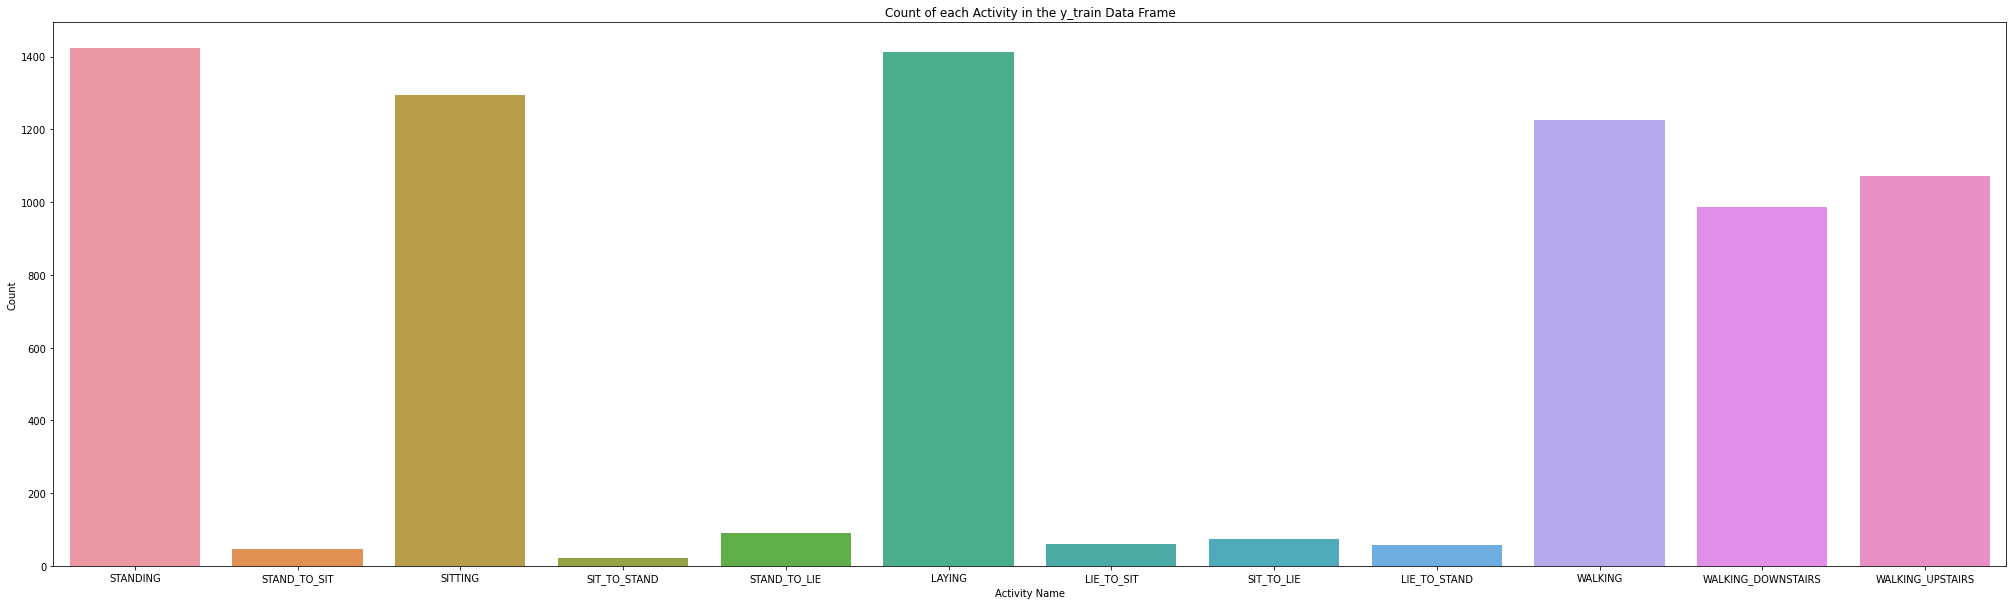

In [ ]:
_plot_count(
    x='activity_name',
    data=X_train_df1,
    plt_title='Count of each Activity in the y_train Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

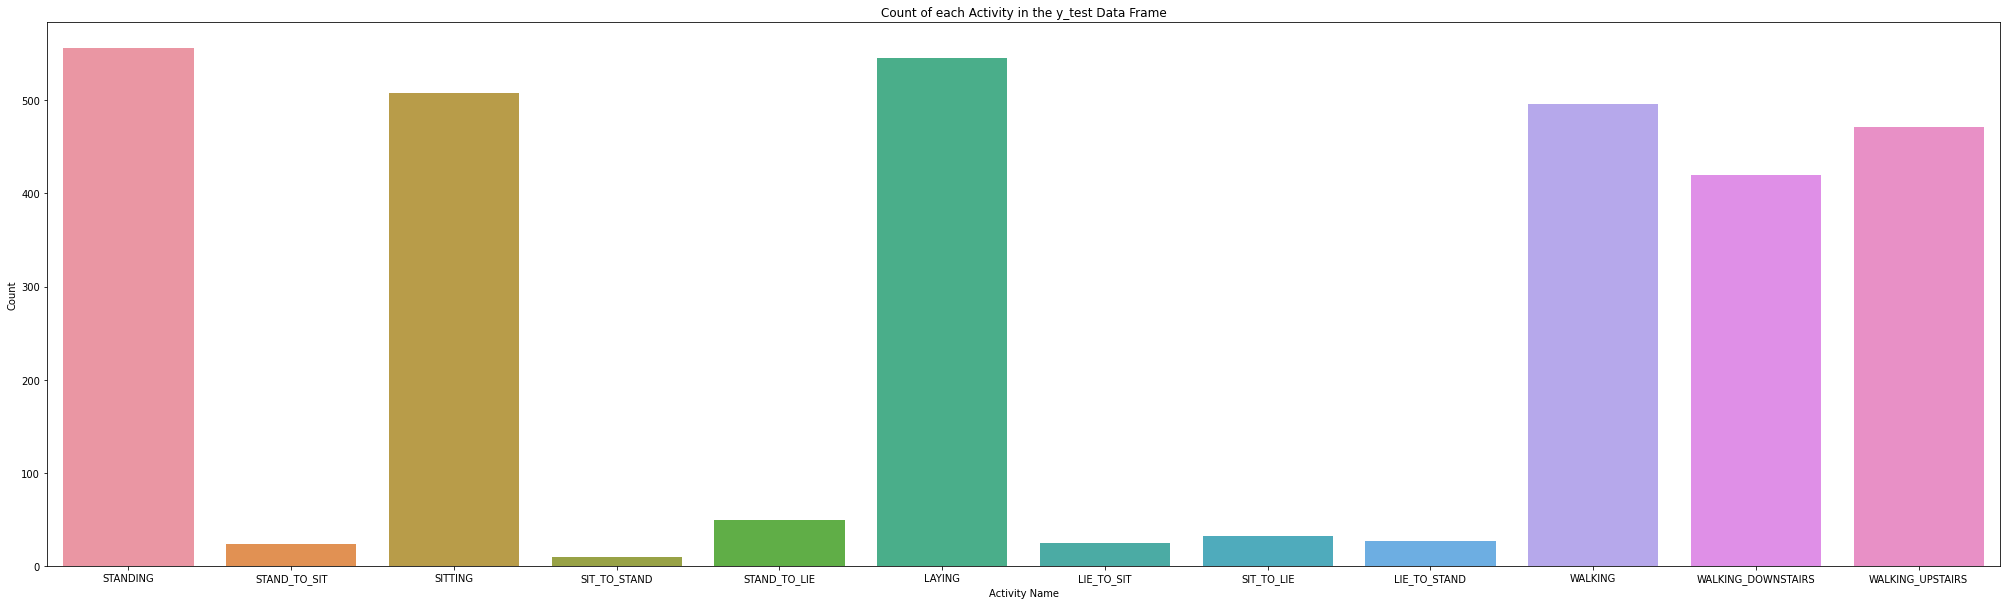

In [ ]:
_plot_count(
    x='activity_name',
    data=X_test_df1,
    plt_title='Count of each Activity in the y_test Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

The dataset is not balanced and that certain activity classes have significantly fewer observations than others, this may lead to biased results when training a machine learning model. it appears that the activities related to postural transitions have very few observations compared to the other activities.

It is possible to merge the postural transition activities into the main activities in order to balance the class distribution. we could consider:

- STAND_TO_SIT and LIE_TO_SIT as SITTING
- SIT_TO_LIE and STAND_TO_LIE as LAYING
- LIE_TO_STAND  and SIT_TO_STAND as STANDING

Also, removing the postural transition activities seems like a valid approach to balance the class distribution in the dataset. However, this approach might lead to the loss of some valuable information. 


I am going to create a new activity called 'POS (Postural transitions)' with ID 7 and map all postural transition activities (i.e., STAND_TO_SIT, LIE_TO_SIT, SIT_TO_LIE, STAND_TO_LIE, LIE_TO_STAND, and SIT_TO_STAND) to this new activity.

In [ ]:
# Train Dataset
unique_values = X_train_df1['activity_id'].unique()
print(unique_values)

[ 5  7  4  8 11  6 10  9 12  1  3  2]


In [ ]:
# Test Dataset
unique_values = X_test_df1['activity_id'].unique()
print(unique_values)

[ 5  7  4  8 11  6 10  9 12  1  3  2]


In [ ]:
# update the DataFrames
X_train_df1.loc[X_train_df1['activity_id'] > 6, 'activity_id'] = 7
X_train_df1.loc[X_train_df1['activity_id'] > 6, 'activity_name'] = 'POS'

X_test_df1.loc[X_test_df1['activity_id'] > 6, 'activity_id'] = 7
X_test_df1.loc[X_test_df1['activity_id'] > 6, 'activity_name'] = 'POS'

In [ ]:
# Train Dataset
act_id_unique_values = X_train_df1['activity_id'].unique()
act_name_unique_values = X_train_df1['activity_name'].unique()
print(act_id_unique_values)
print(act_name_unique_values)

[5 7 4 6 1 3 2]
['STANDING' 'POS' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [ ]:
# Test Dataset
act_id_unique_values = X_test_df1['activity_id'].unique()
act_name_unique_values = X_test_df1['activity_name'].unique()
print(act_id_unique_values)
print(act_name_unique_values)

[5 7 4 6 1 3 2]
['STANDING' 'POS' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


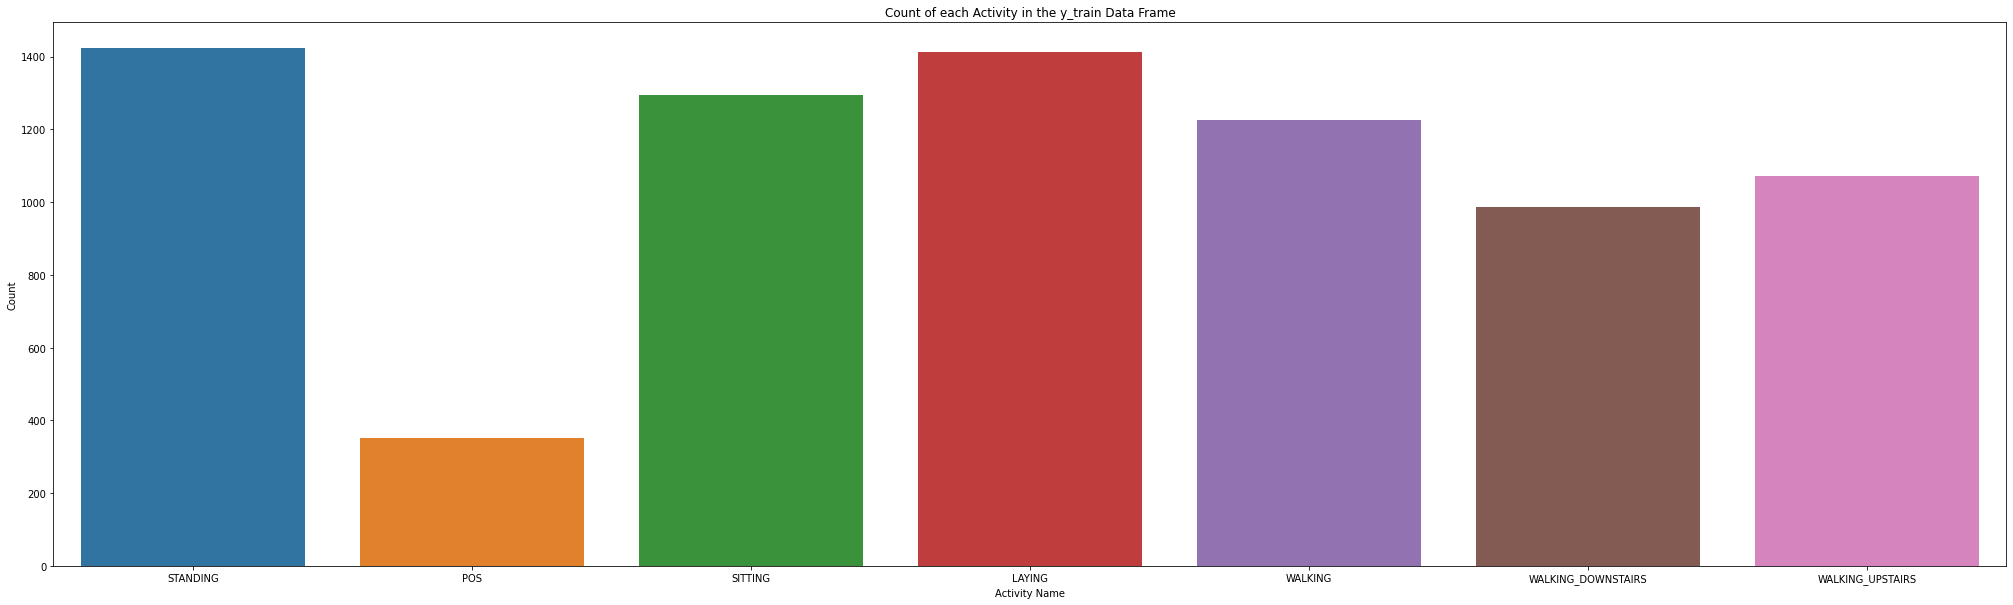

In [ ]:
_plot_count(
    x='activity_name',
    data=X_train_df1,
    plt_title='Count of each Activity in the y_train Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

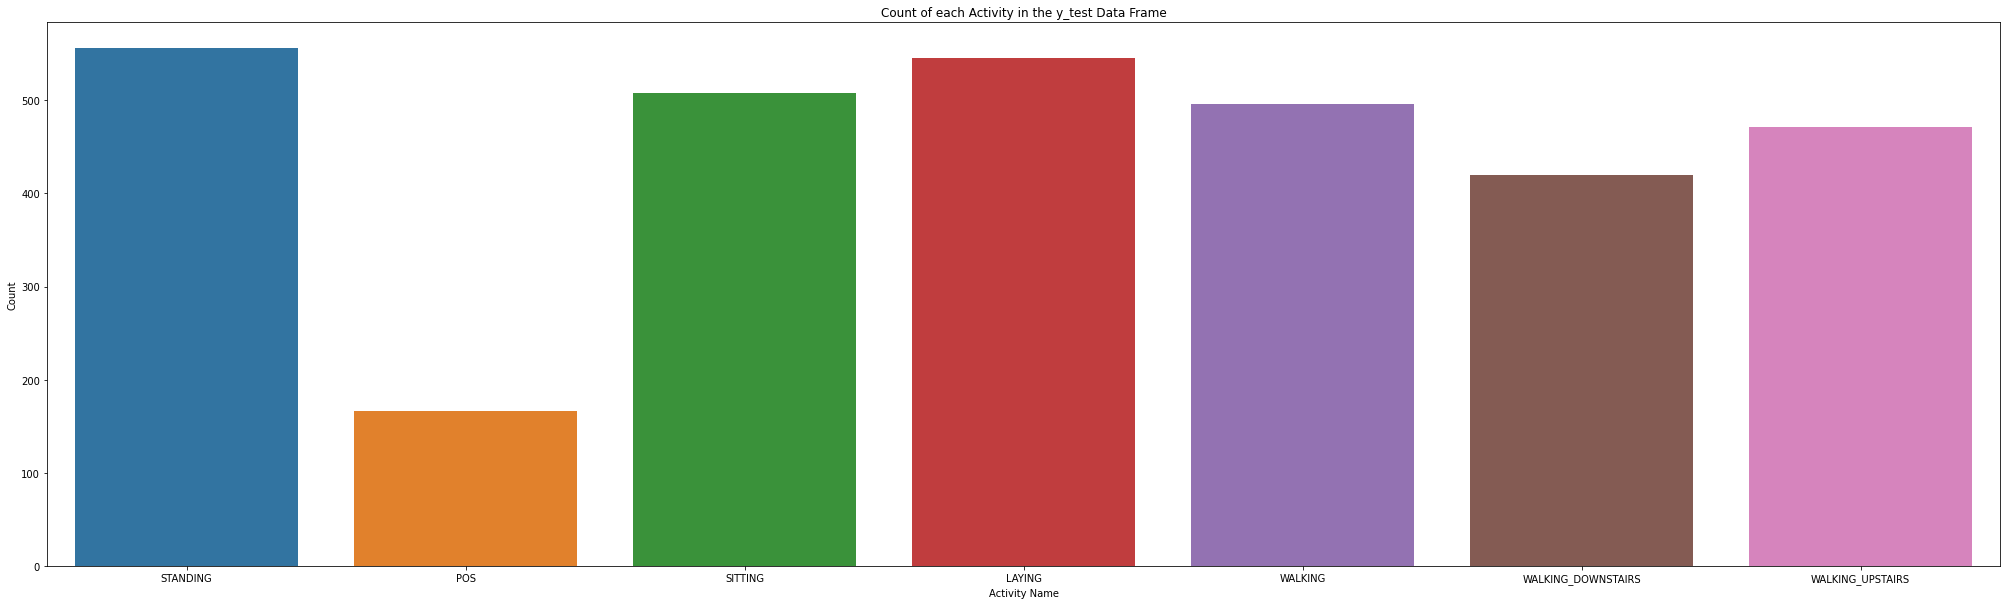

In [ ]:
_plot_count(
    x='activity_name',
    data=X_test_df1,
    plt_title='Count of each Activity in the y_test Data Frame',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

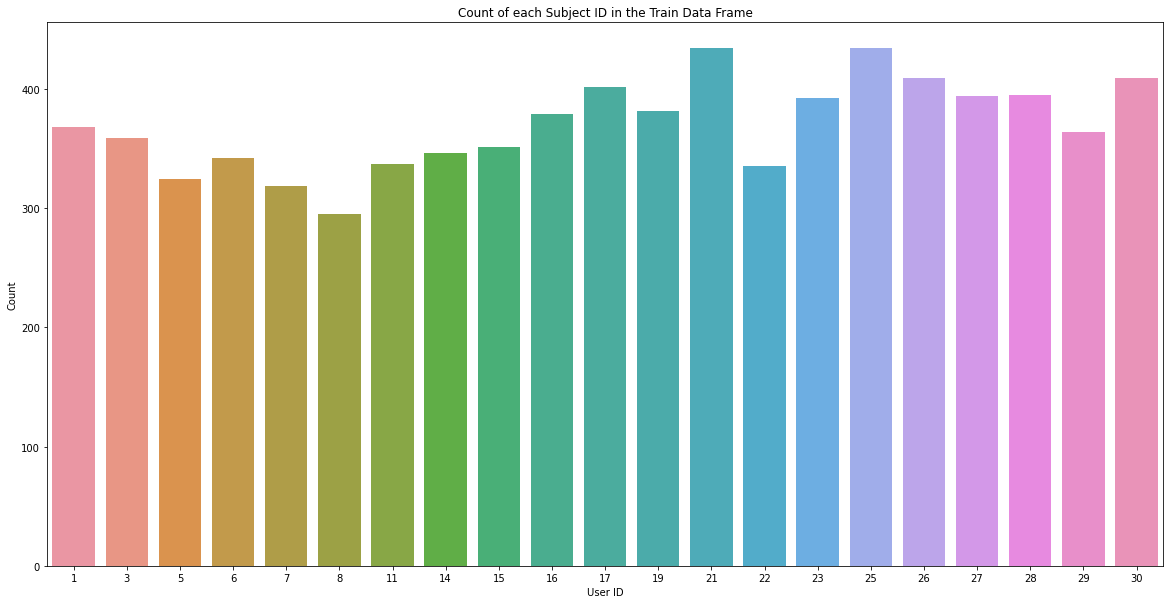

In [ ]:
_plot_count(
    x='user_id',
    data=X_train_df1,
    plt_title='Count of each User ID in the Train Data Frame',
    x_label ='User ID',
    y_label='Count')

It should be noted that the test dataset does not include all the users that are present in the training dataset.

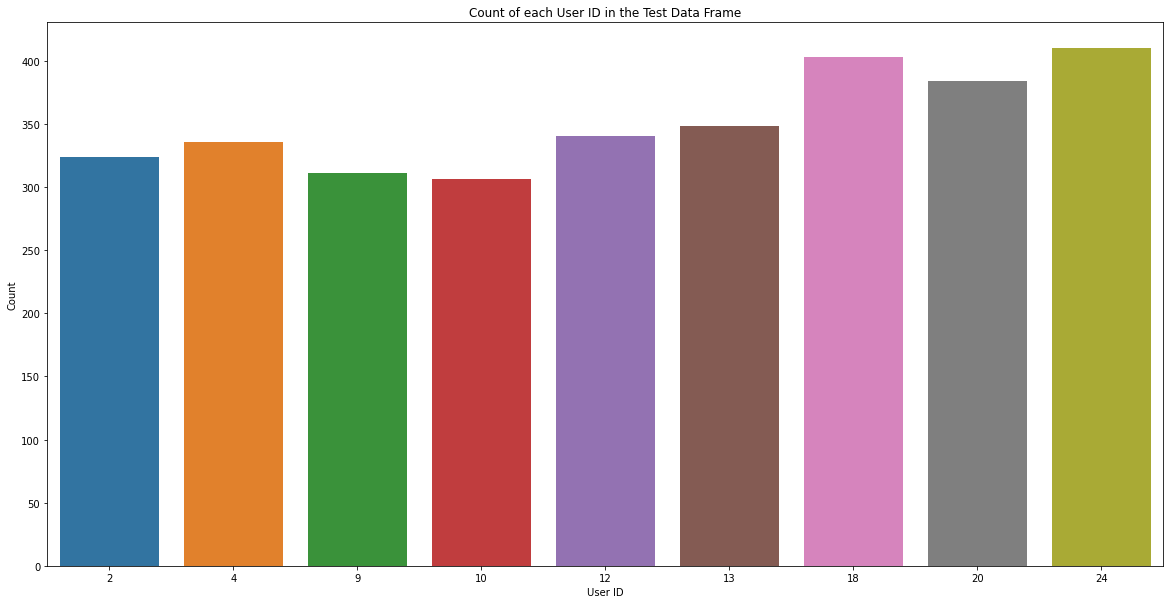

In [ ]:
_plot_count(
    x='user_id',
    data=X_test_df1,
    plt_title='Count of each User ID in the Test Data Frame',
    x_label ='User ID',
    y_label='Count')

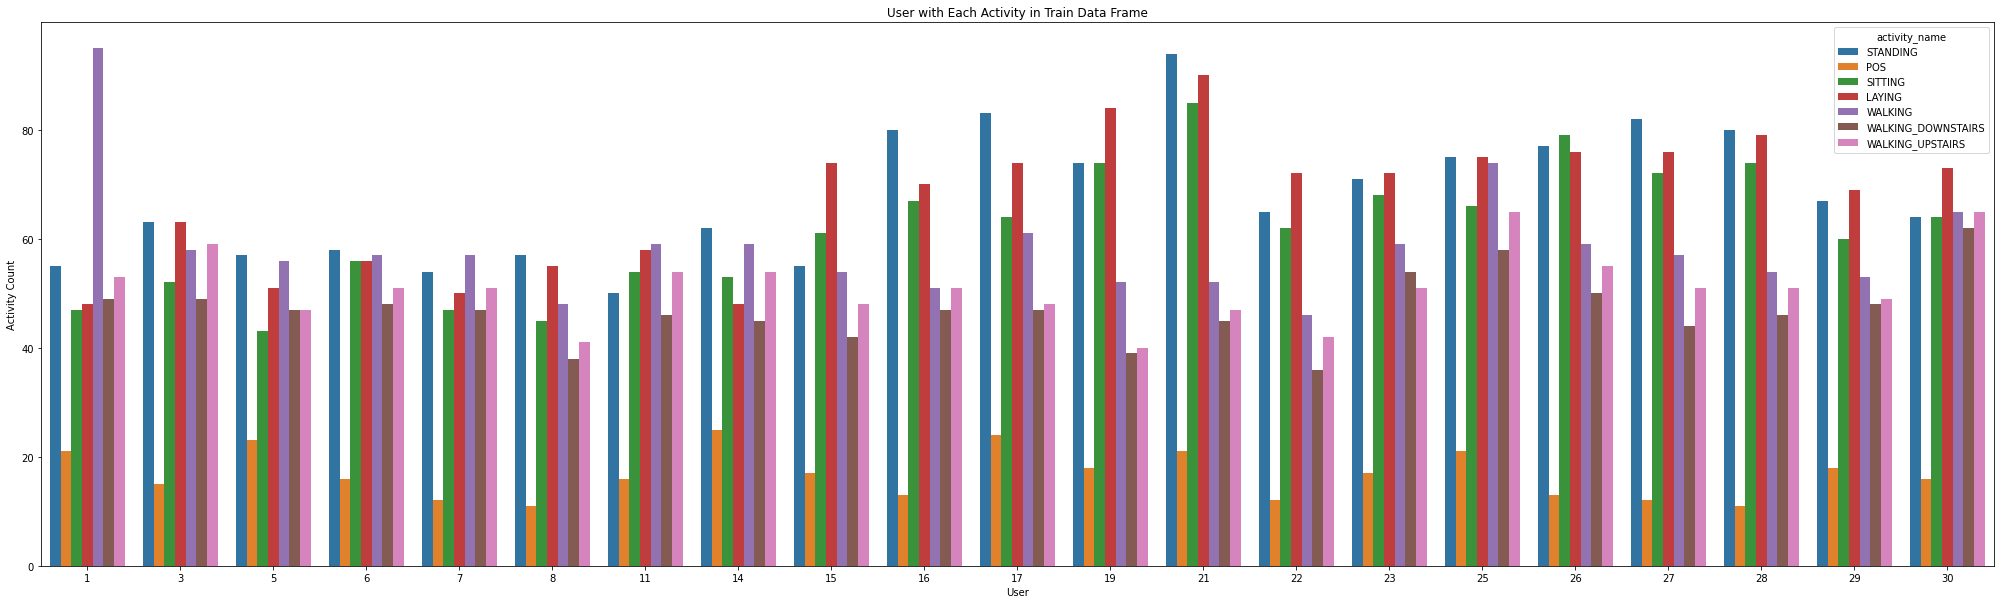

In [ ]:
_plot_count(
    x='user_id',
    hue='activity_name',
    data=X_train_df1,
    plt_title='User with Each Activity in Train Data Frame',
    x_label ='User',
    y_label='Activity Count',
    figsize_w= 35,
    figsize_h= 10)

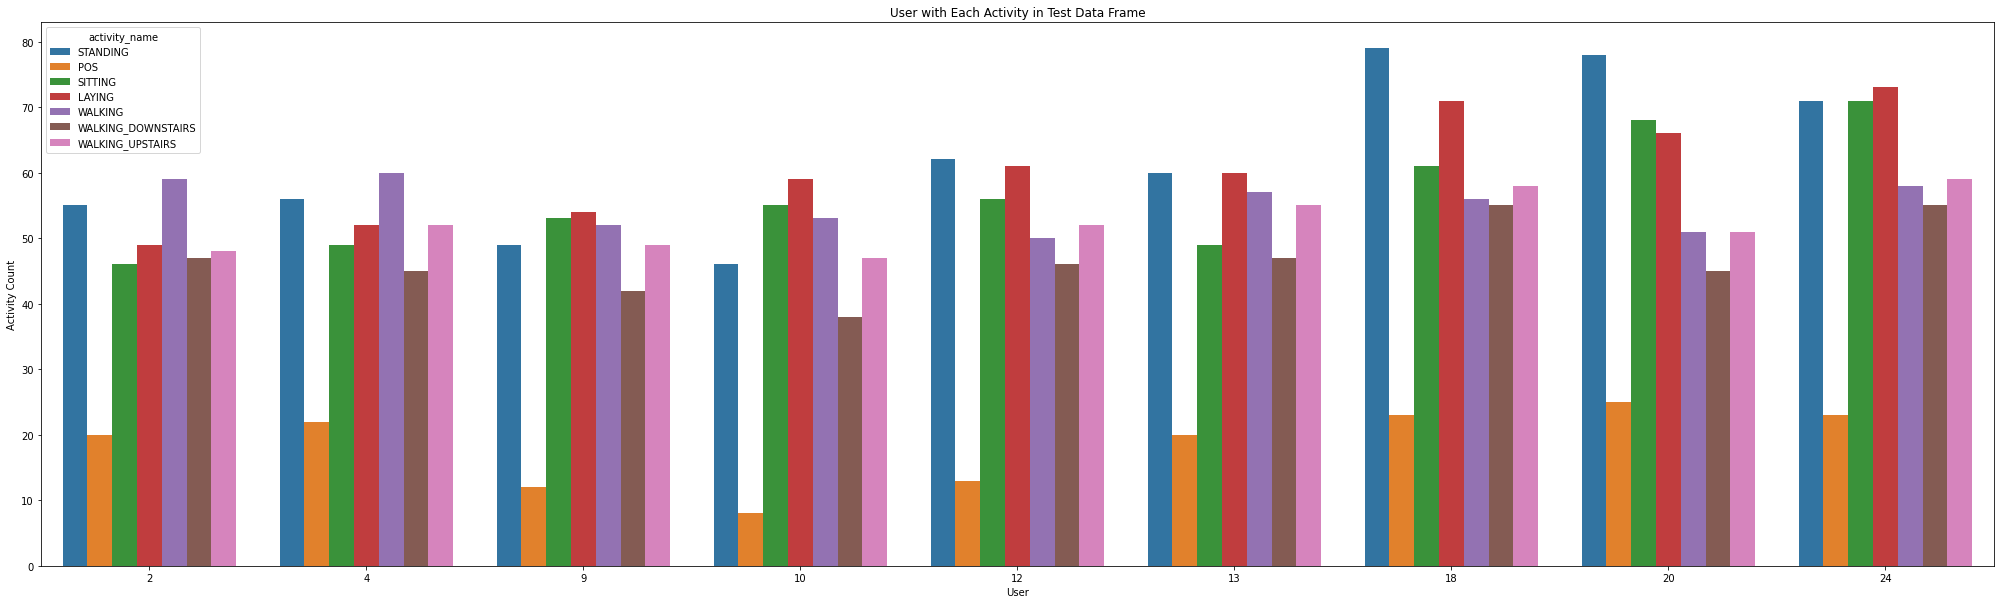

In [ ]:
_plot_count(
    x='user_id',
    hue='activity_name',
    data=X_test_df1,
    plt_title='User with Each Activity in Test Data Frame',
    x_label ='User',
    y_label='Activity Count',
    figsize_w= 35,
    figsize_h= 10)

As shown in the above graphics, the dataset appears to be well balanced, with a relatively equal number of observations for each subject and activity.

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplo

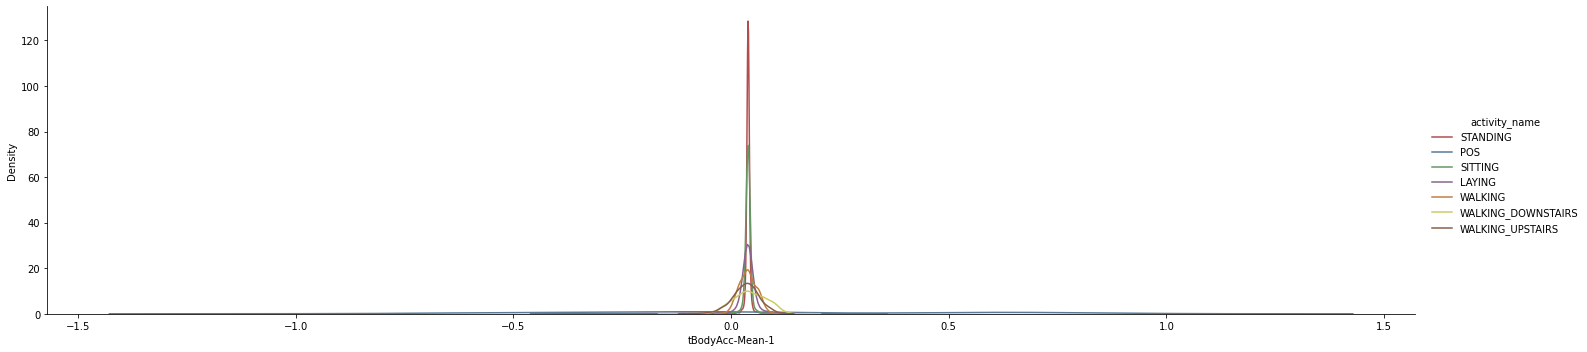

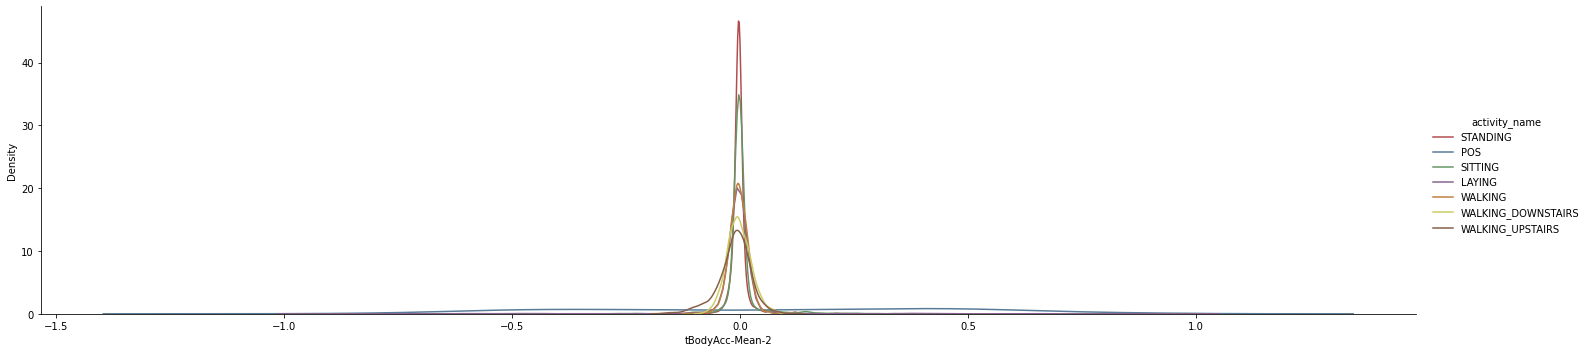

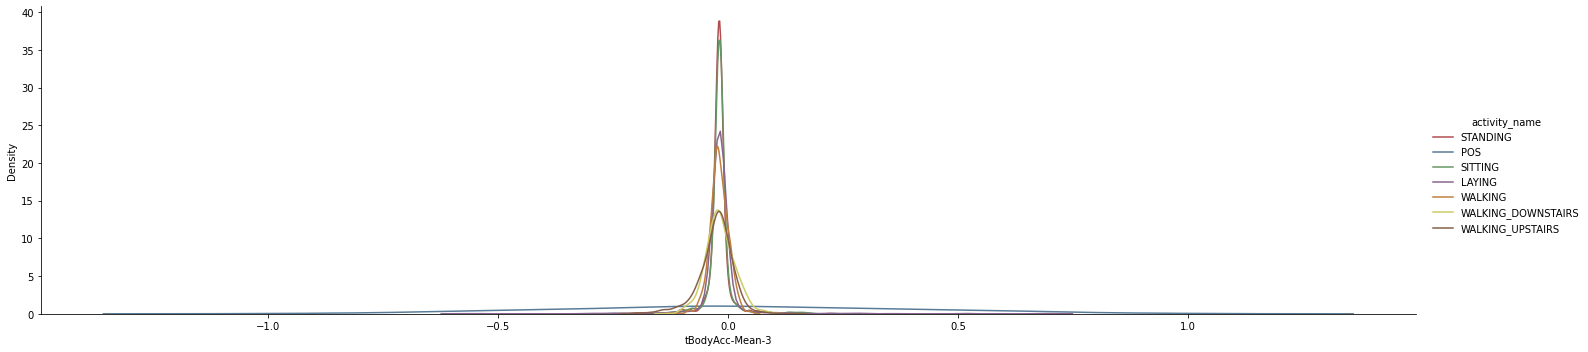

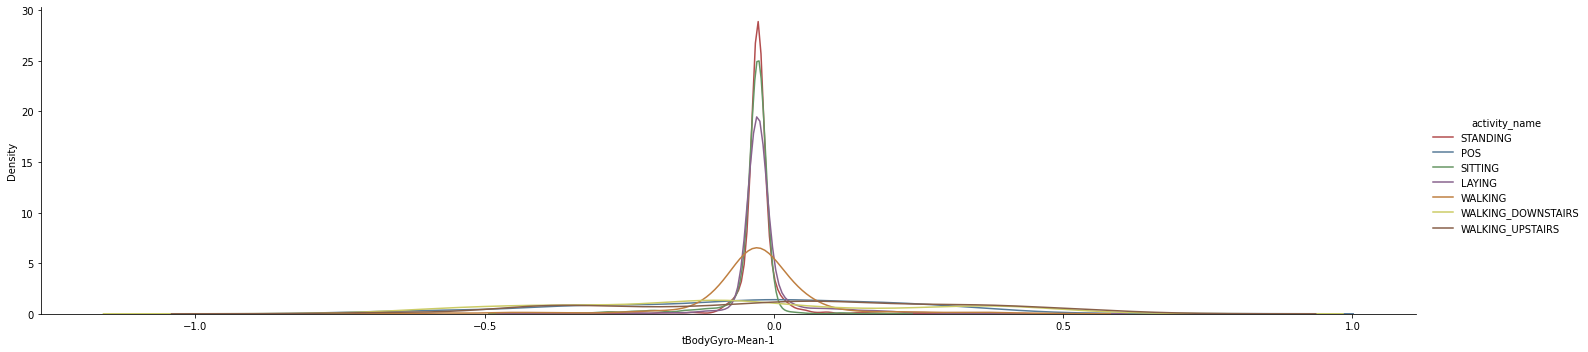

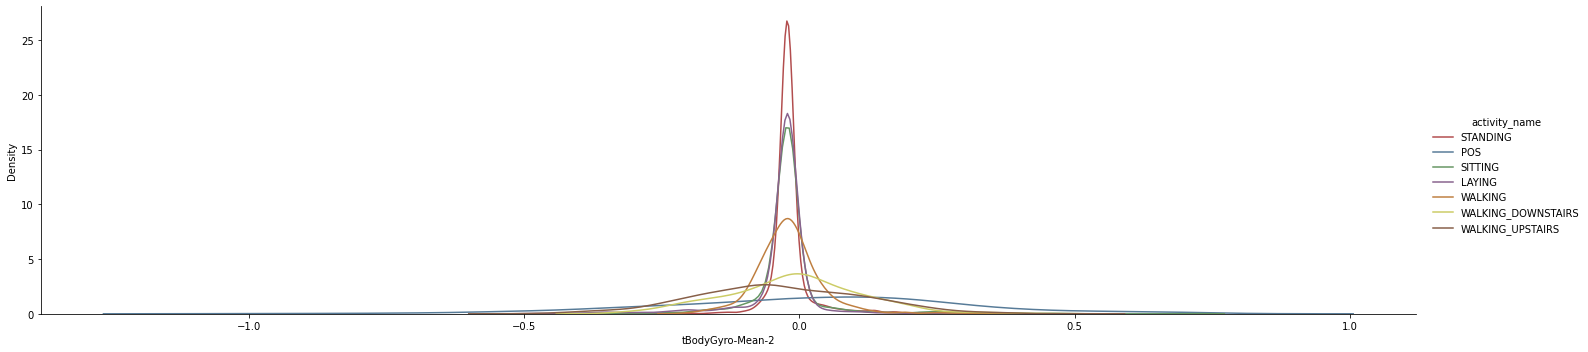

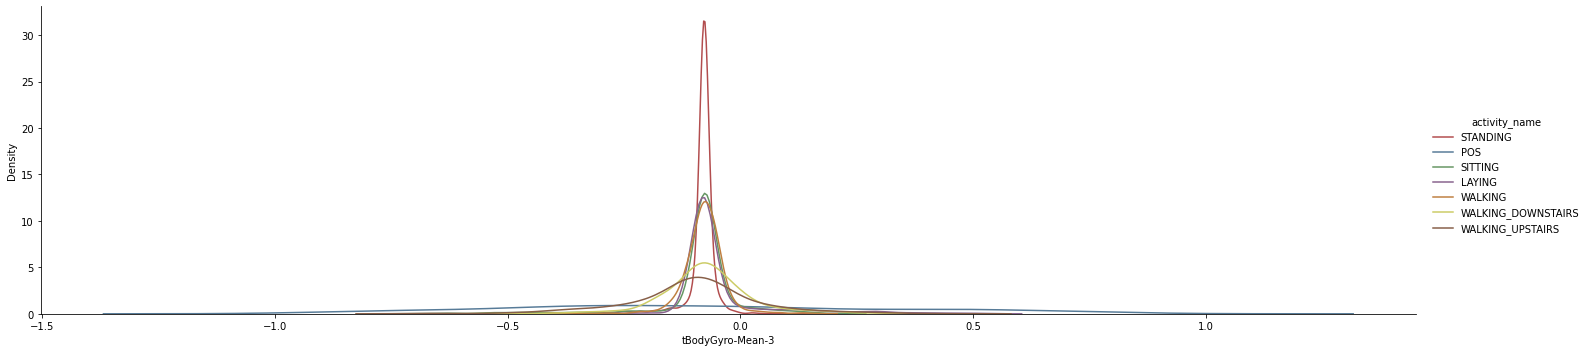

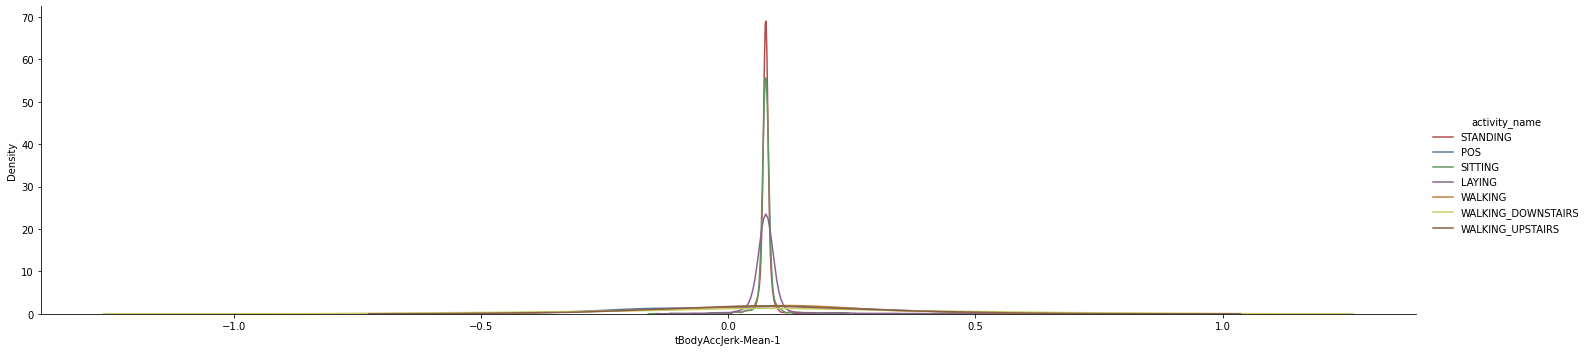

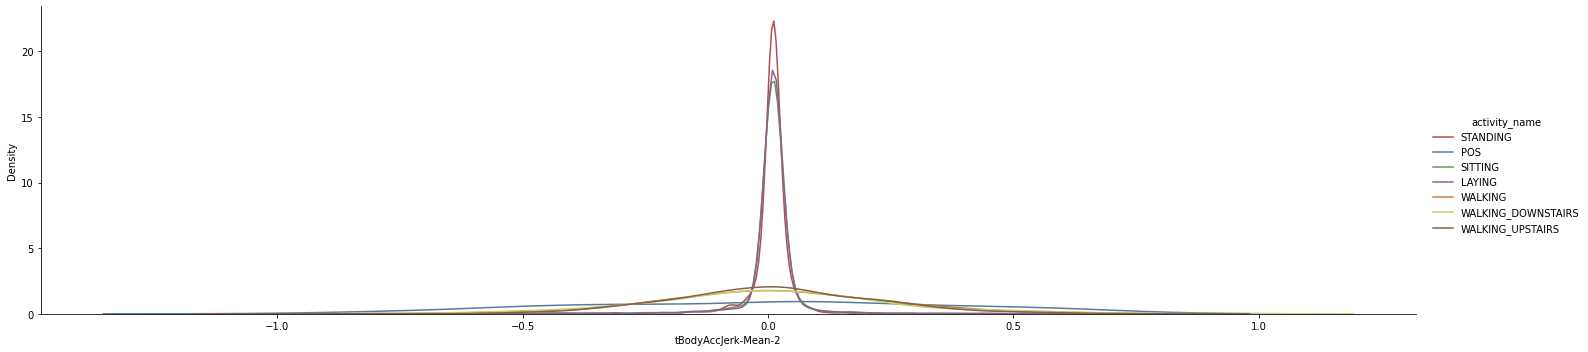

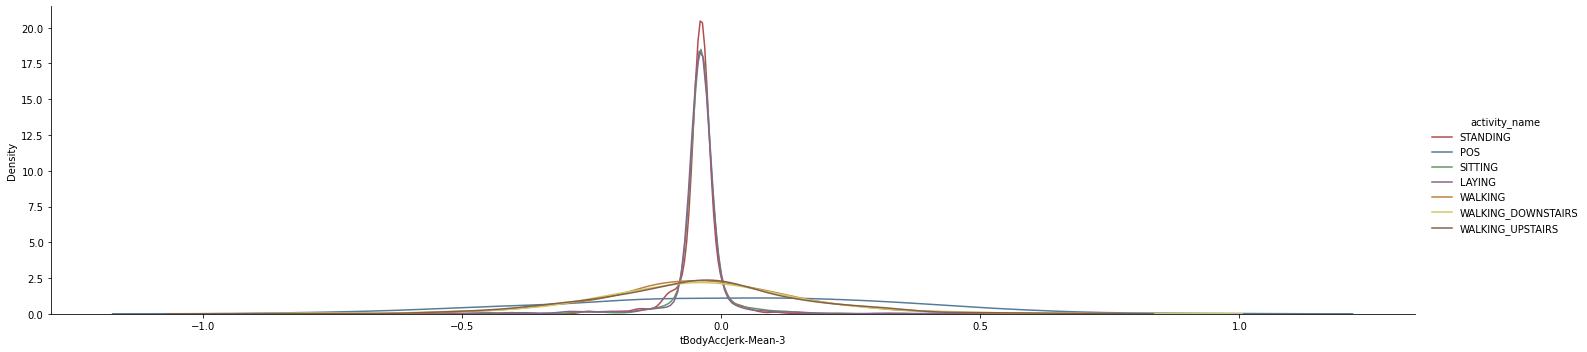

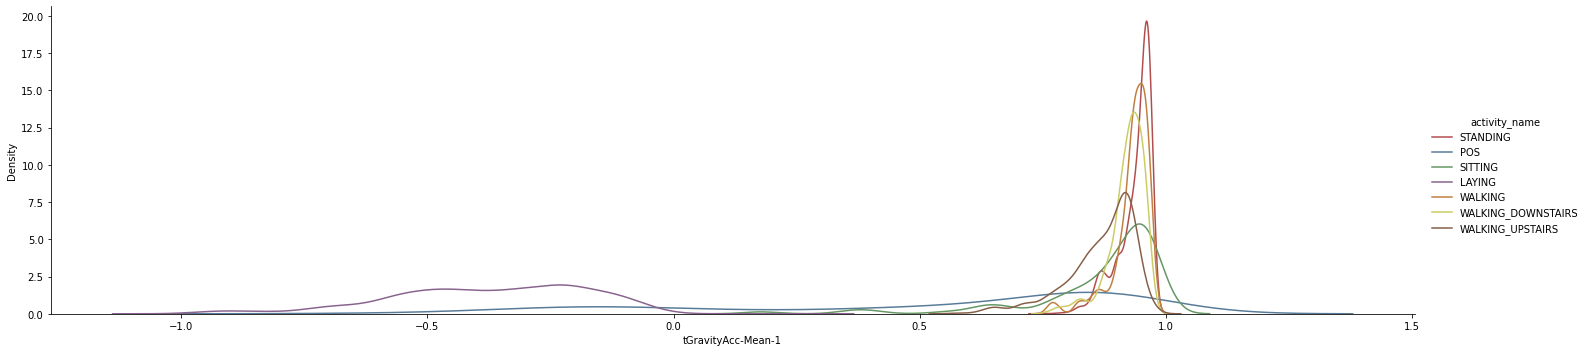

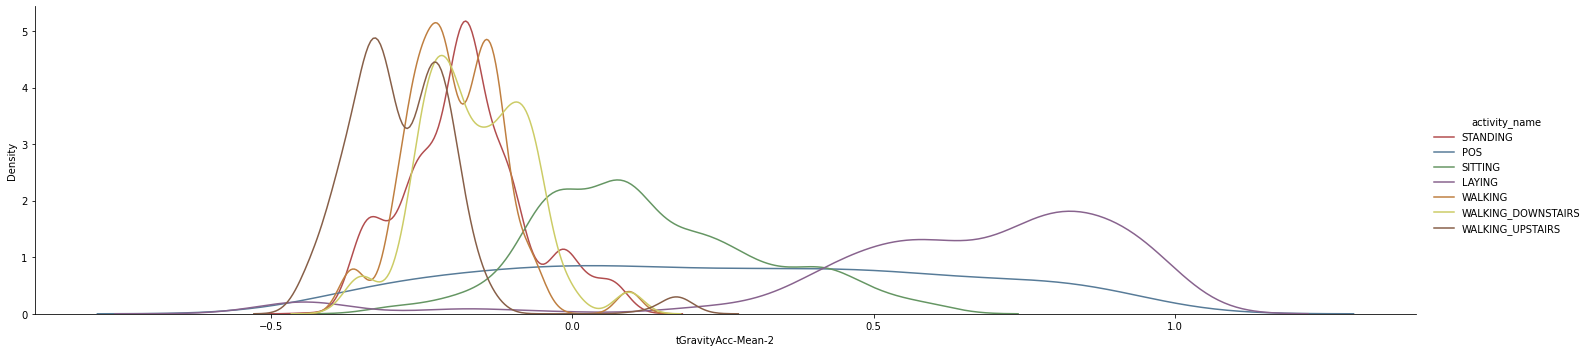

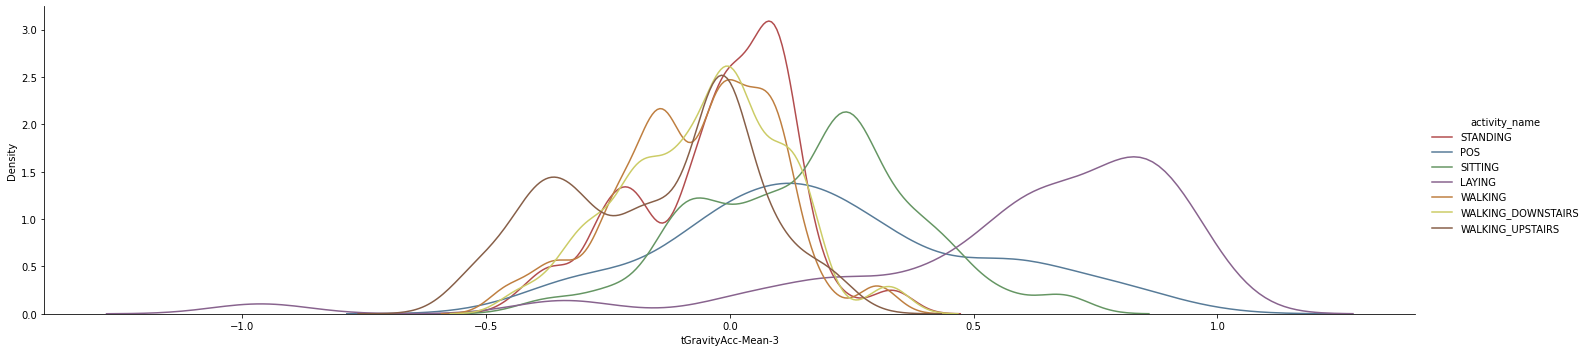

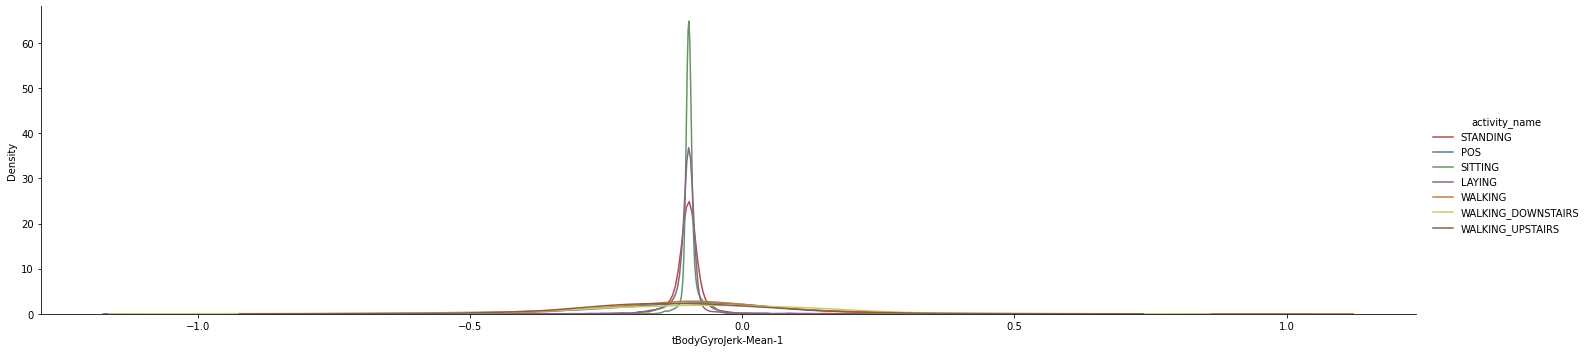

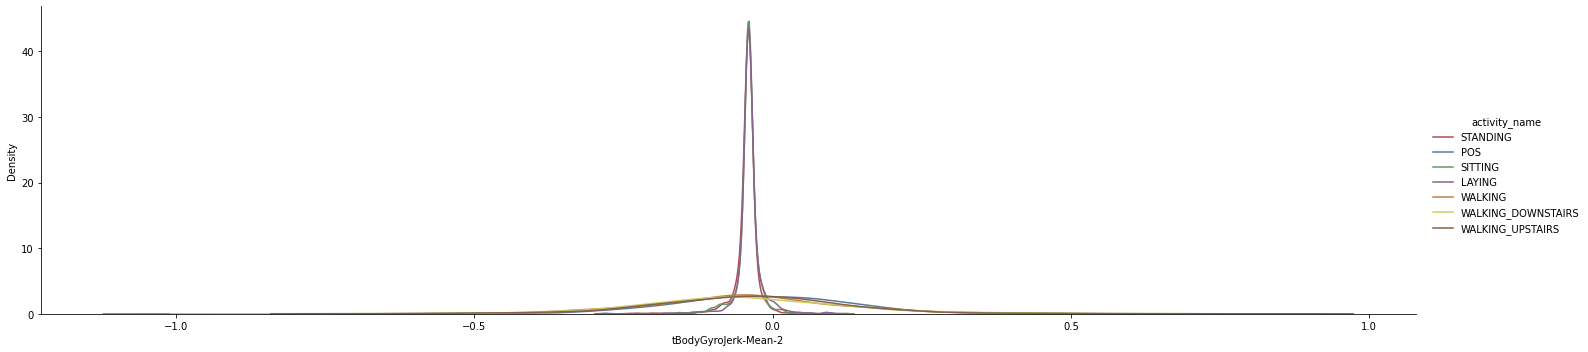

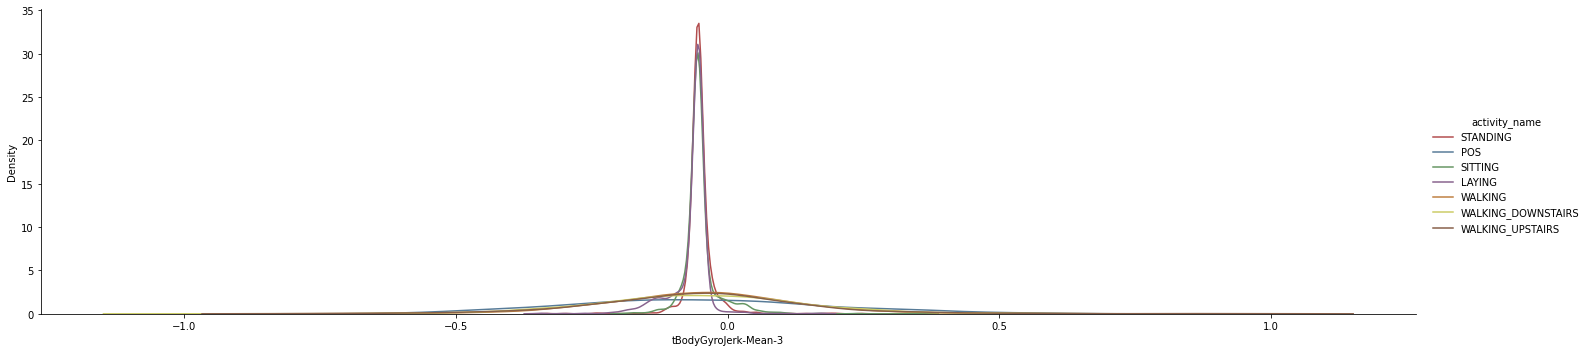

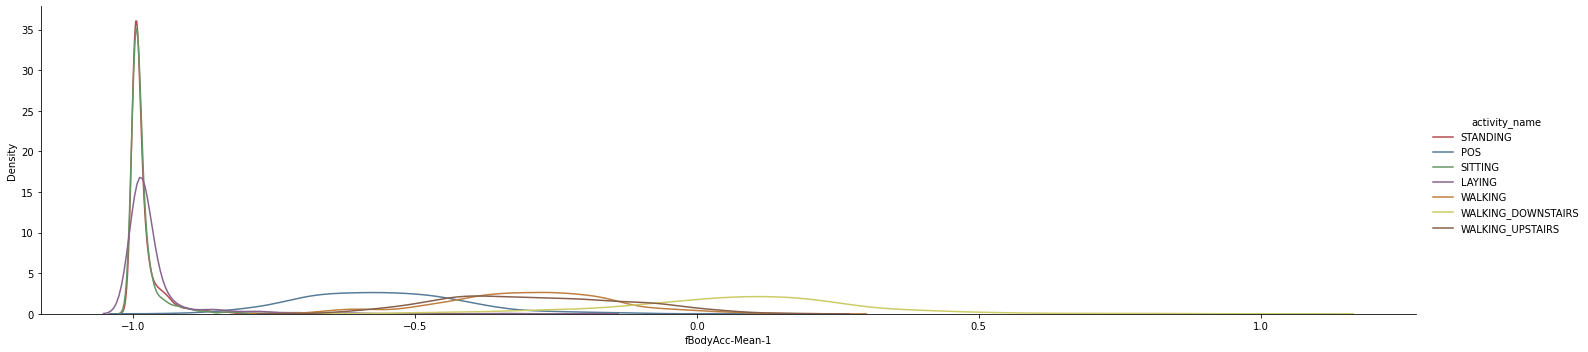

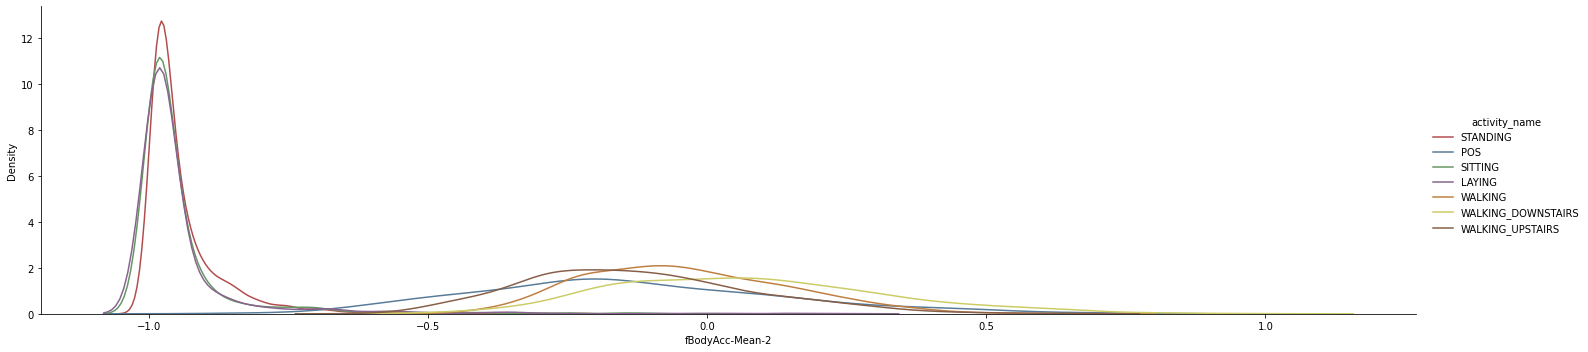

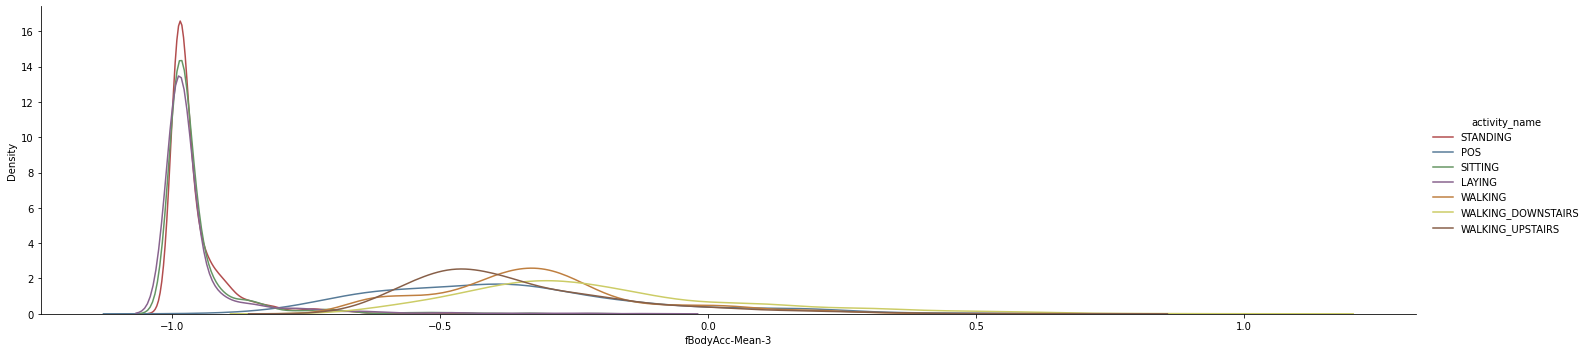

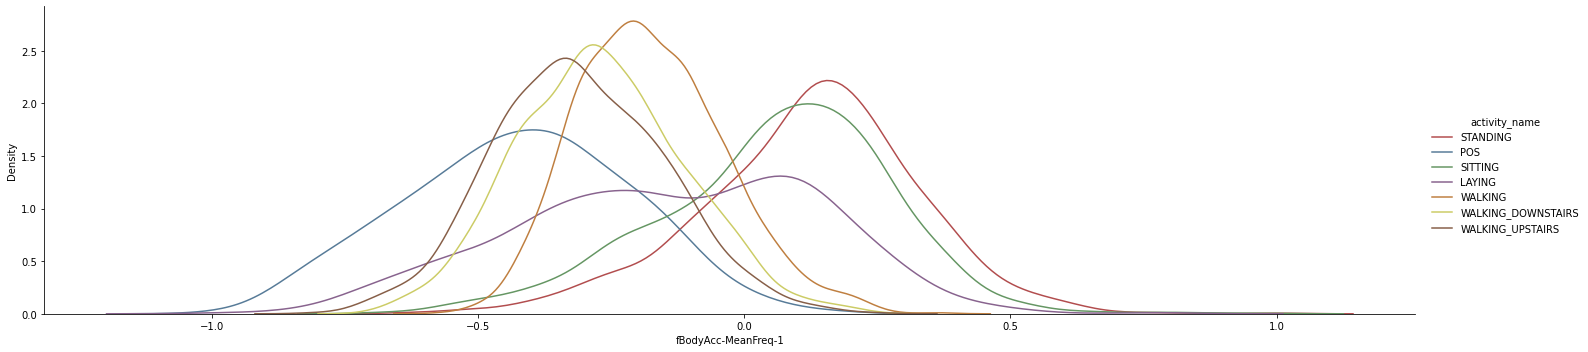

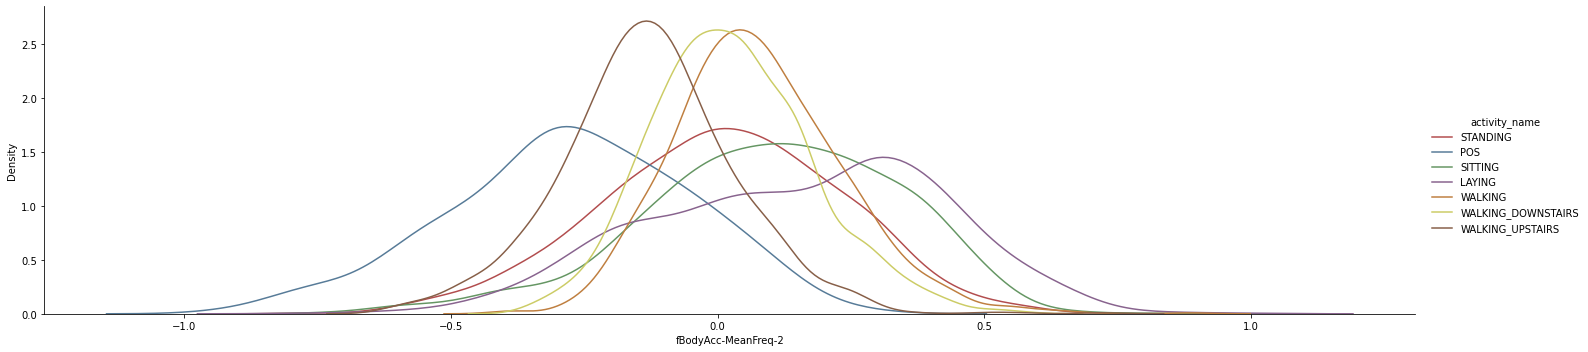

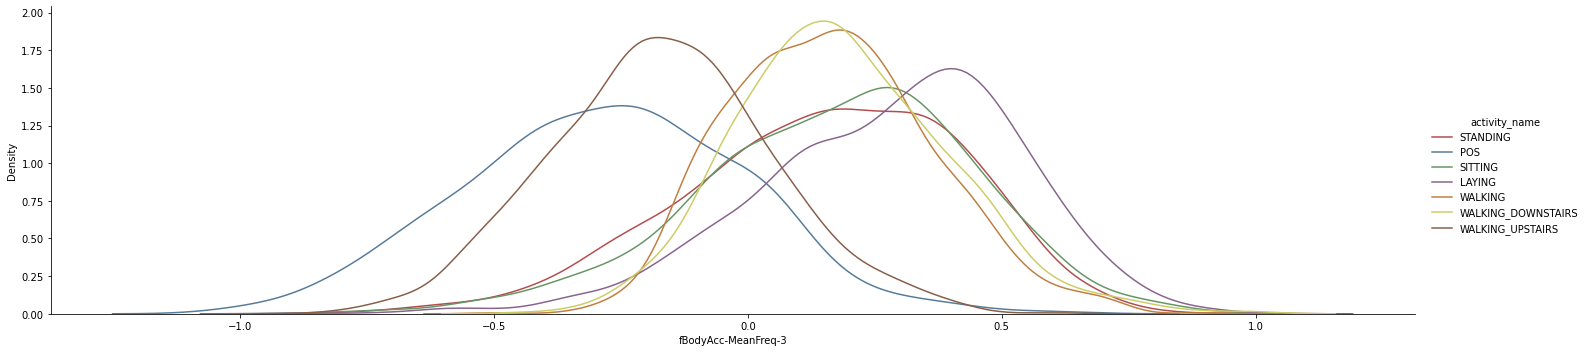

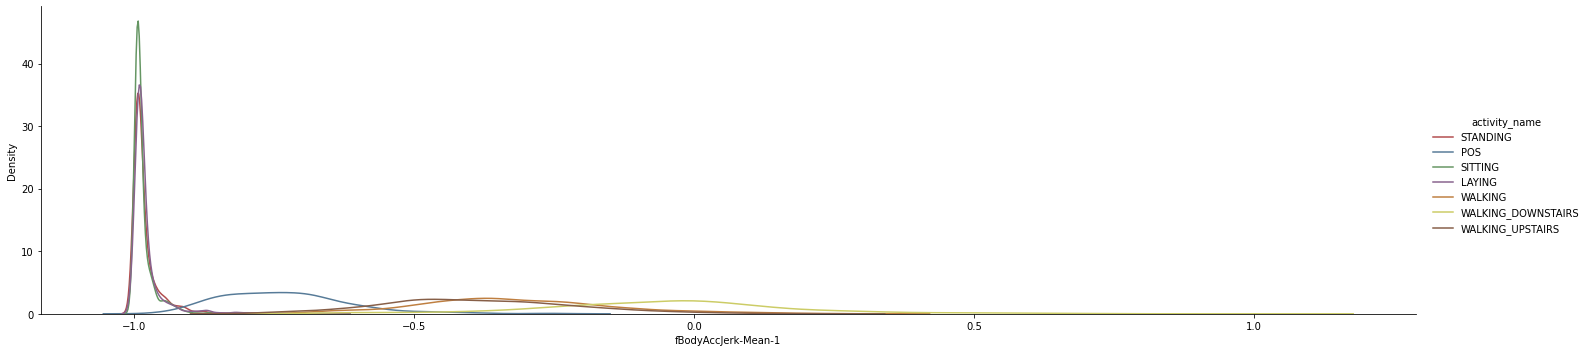

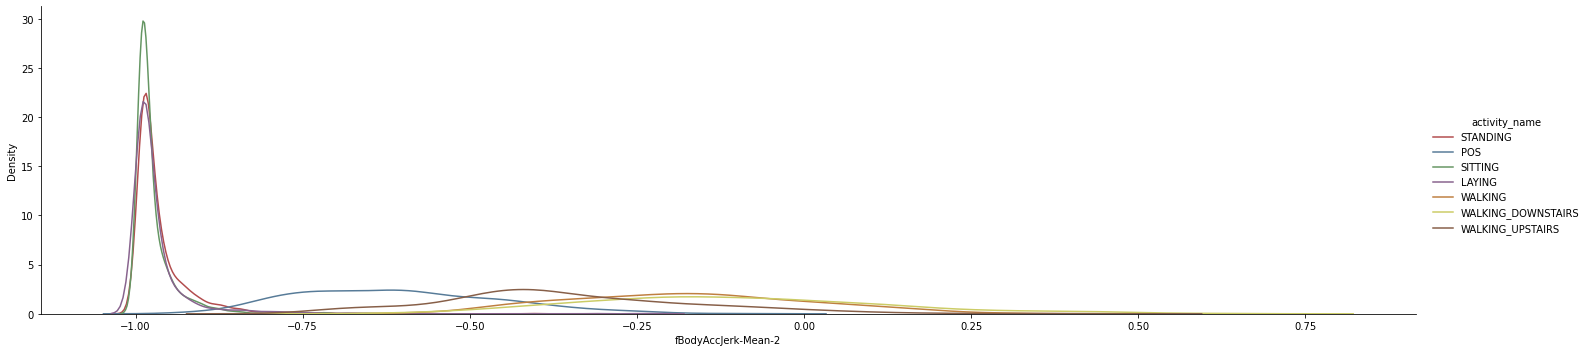

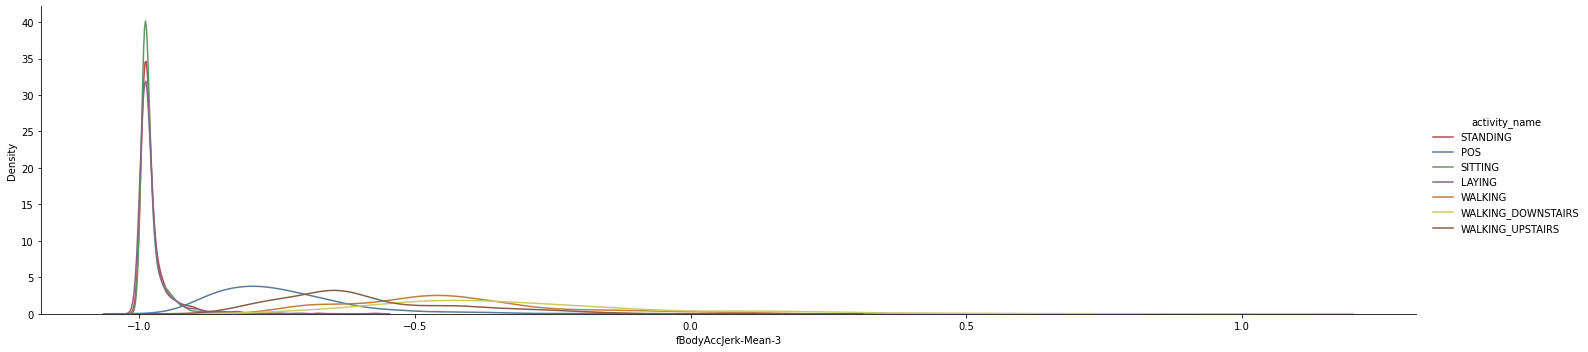

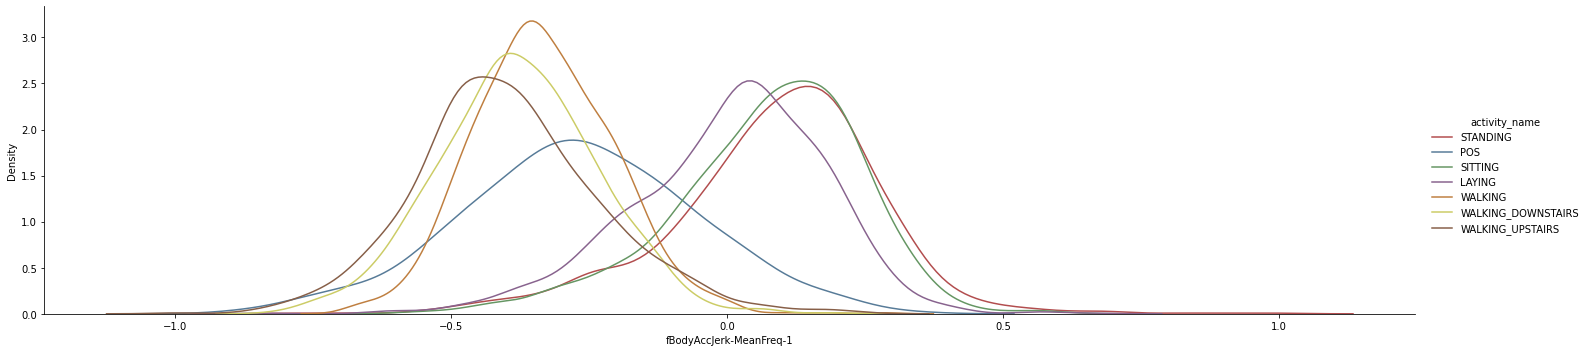

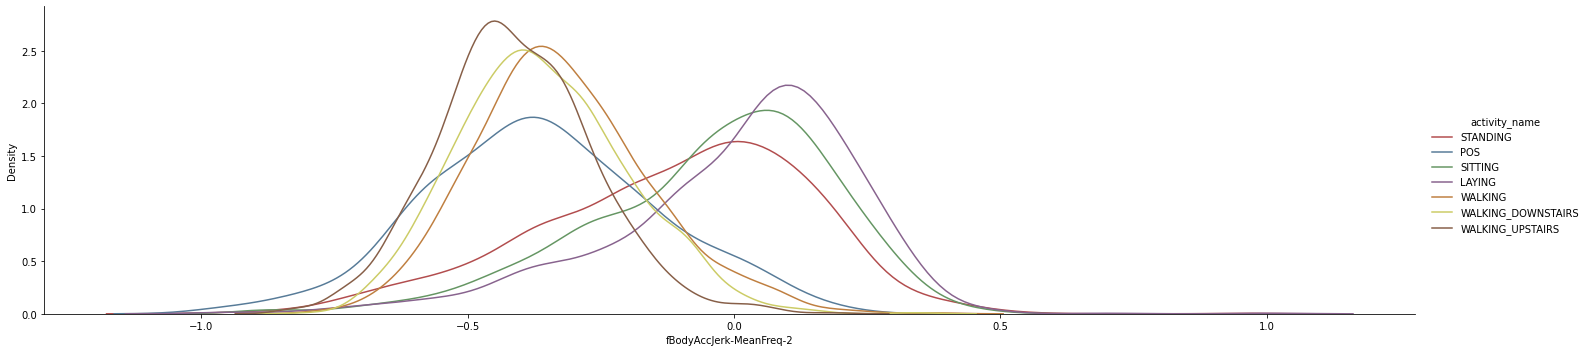

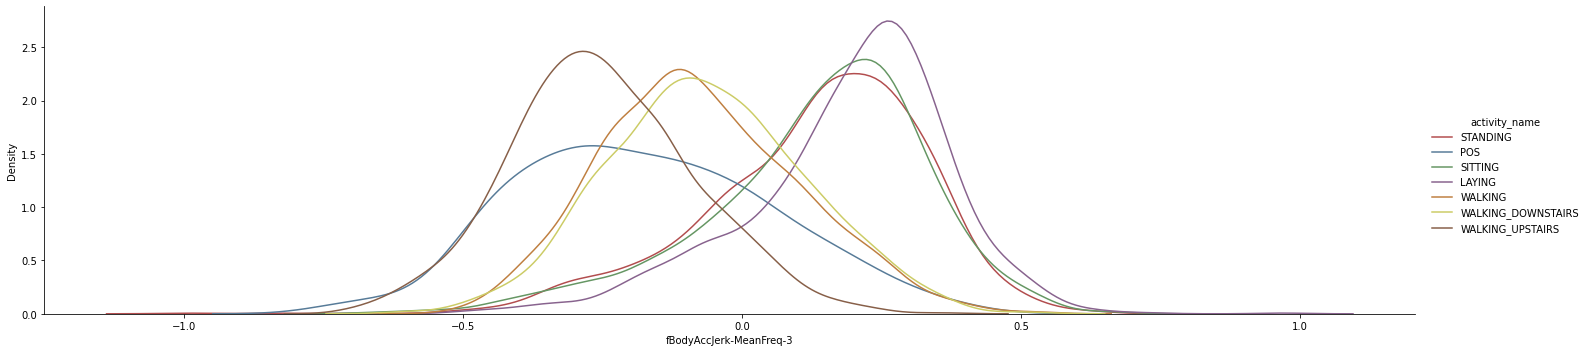

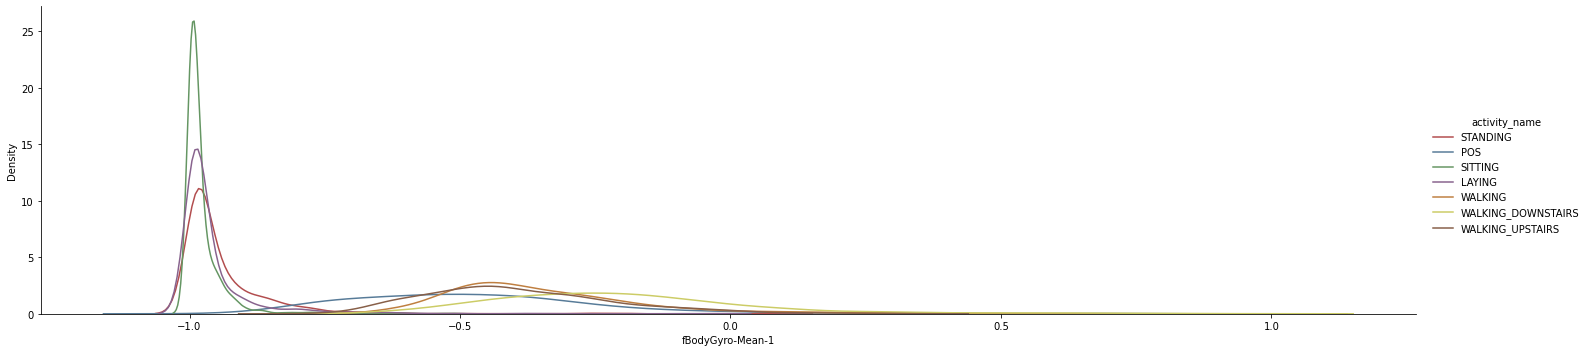

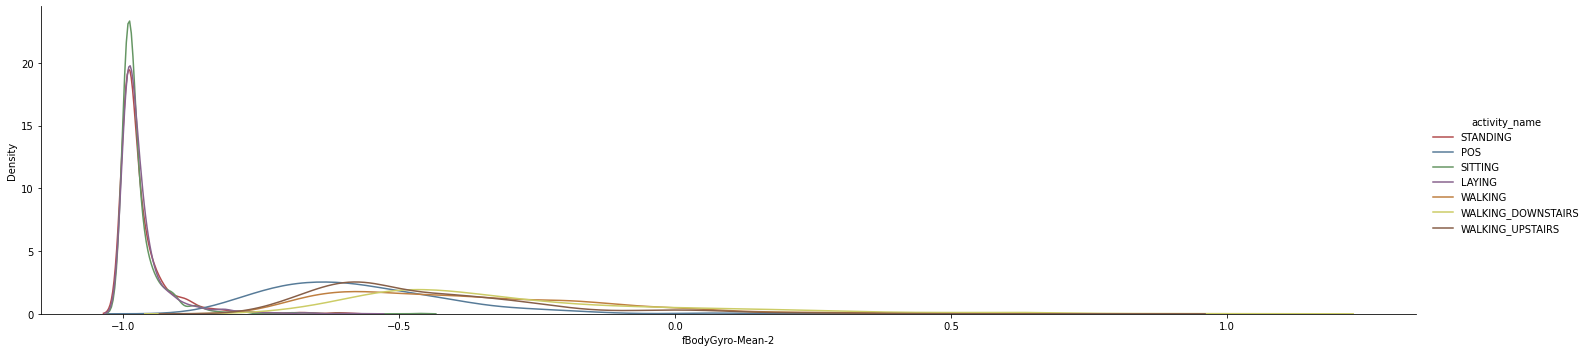

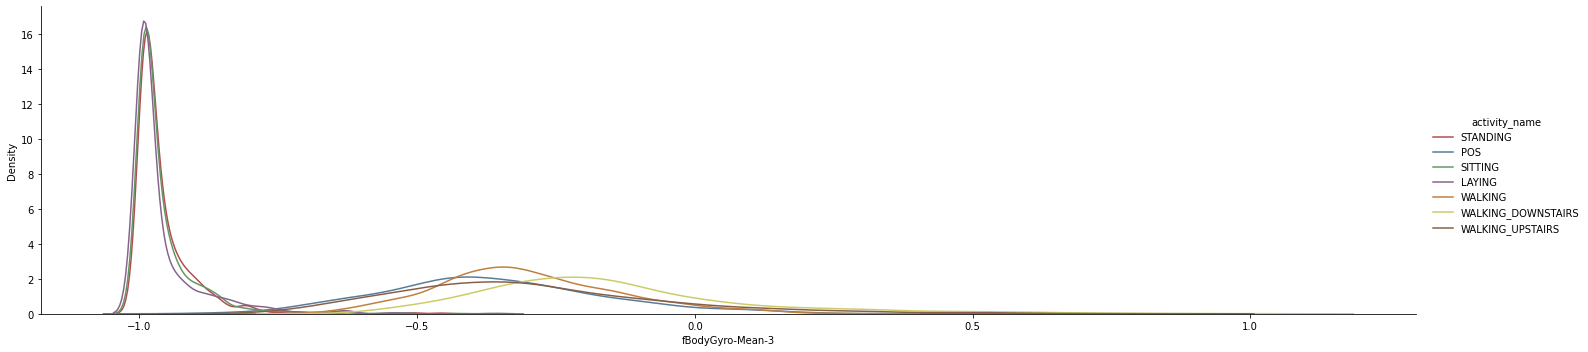

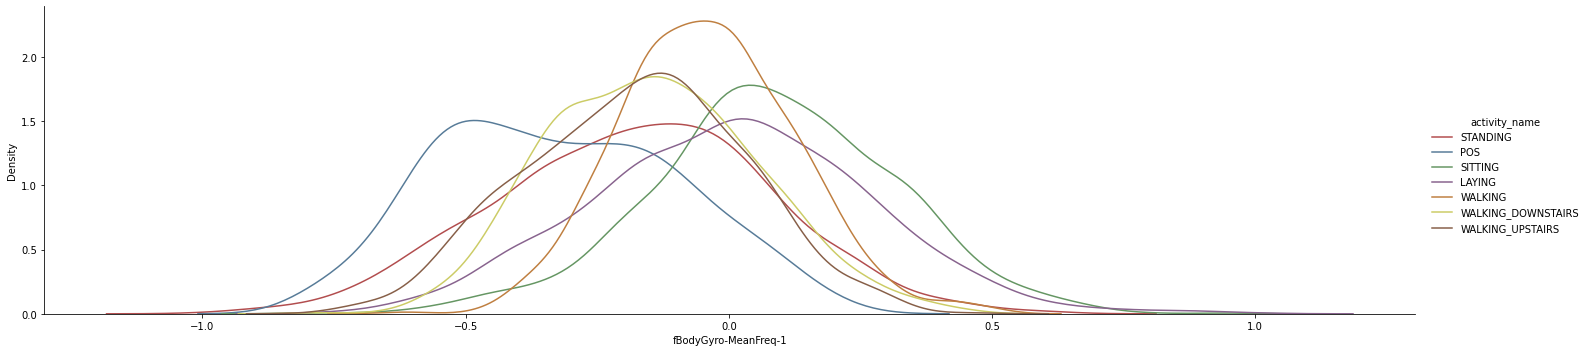

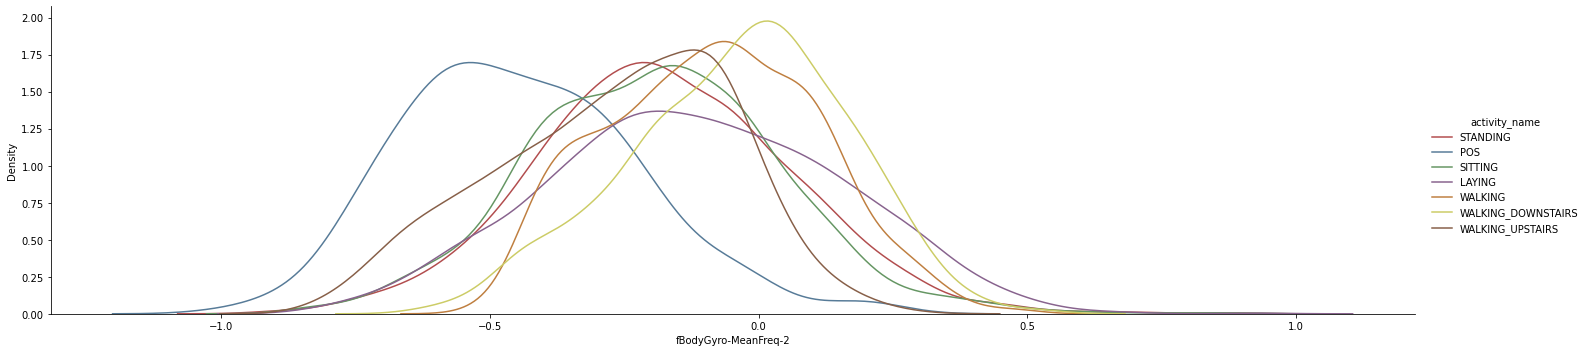

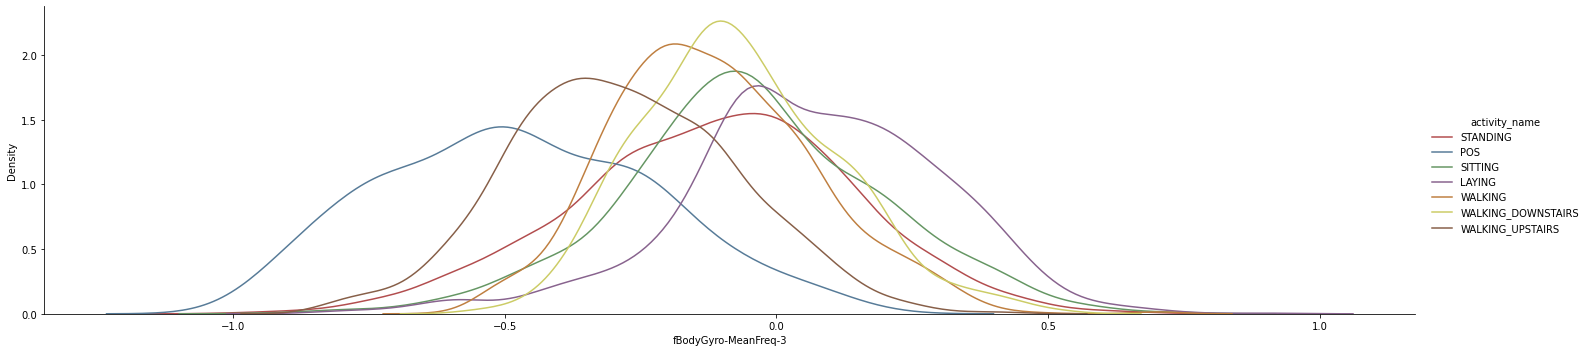

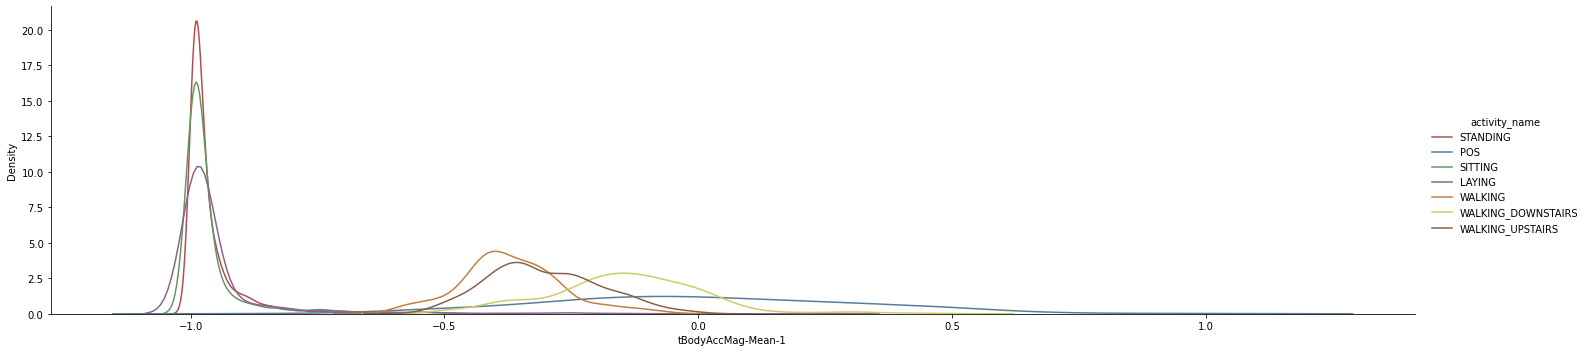

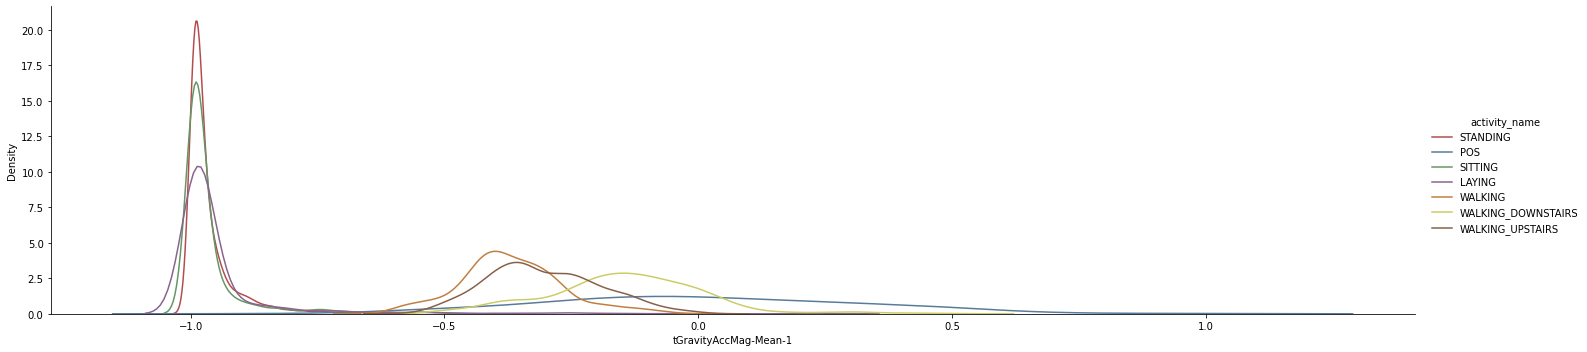

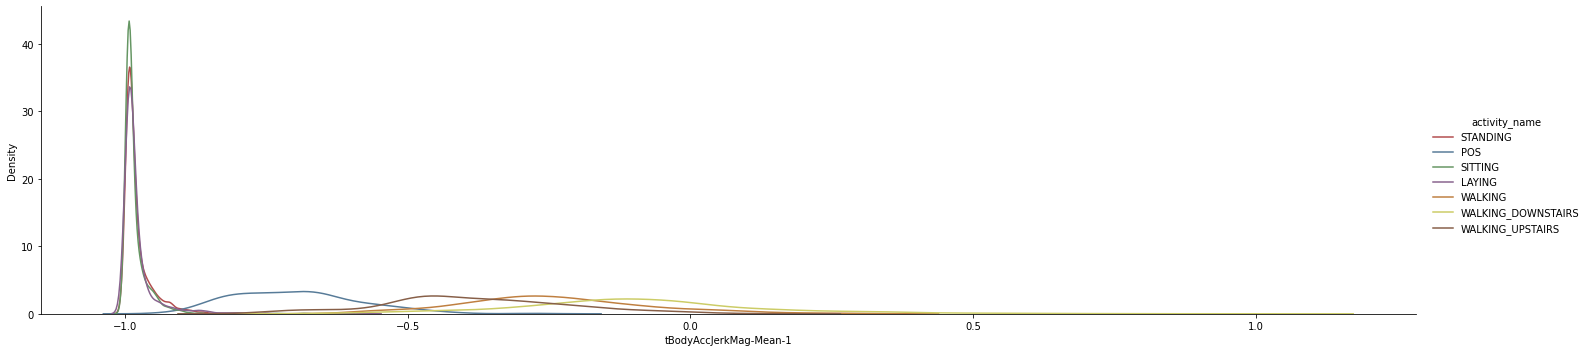

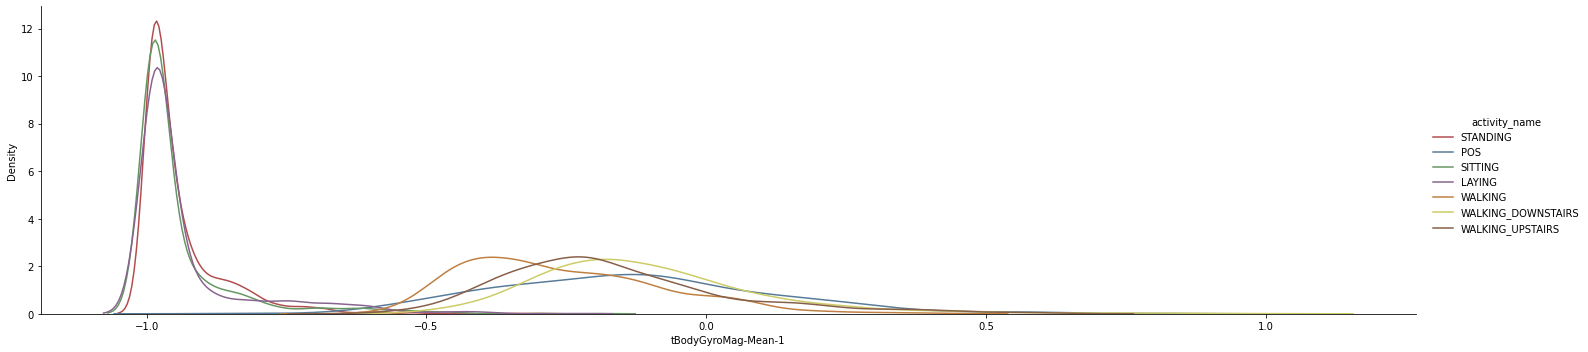

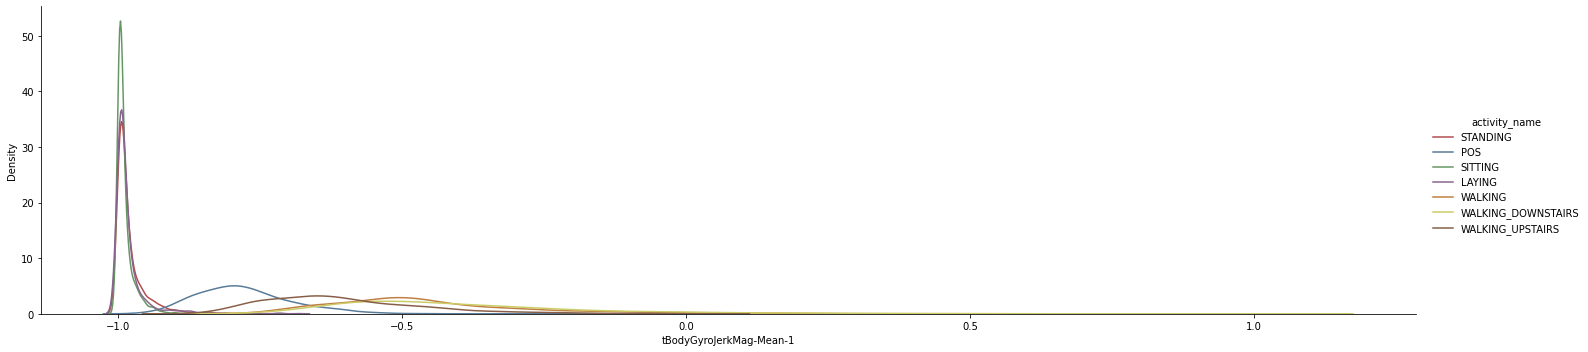

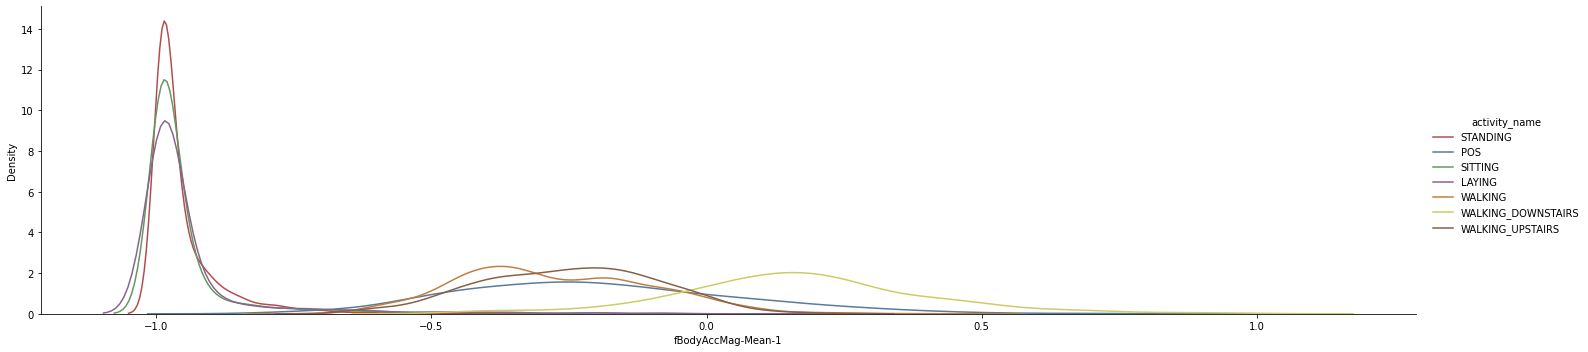

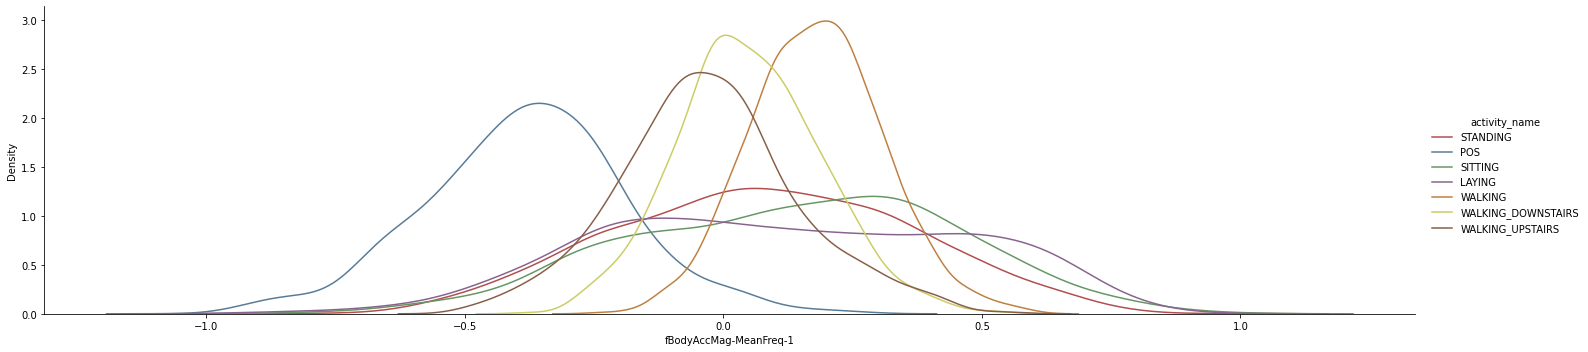

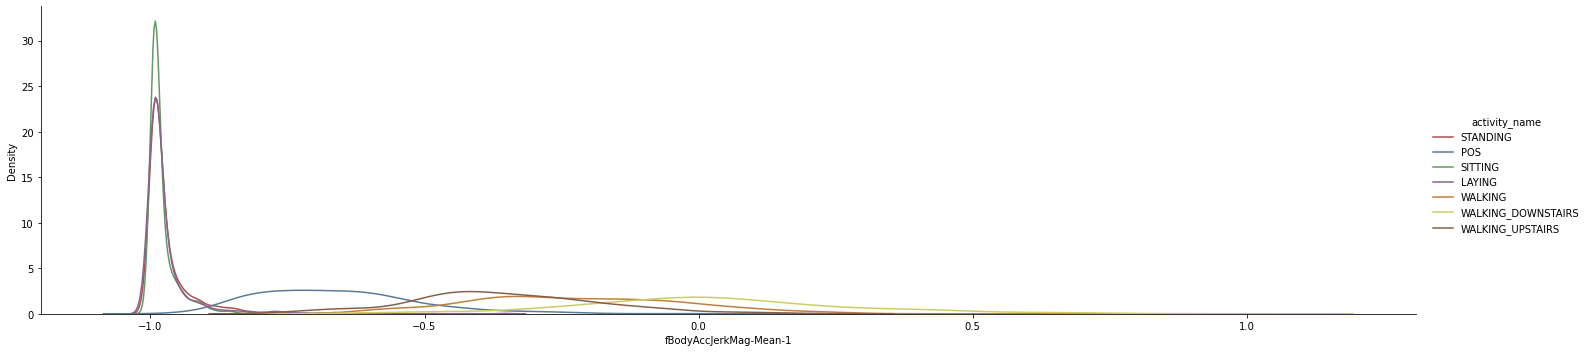

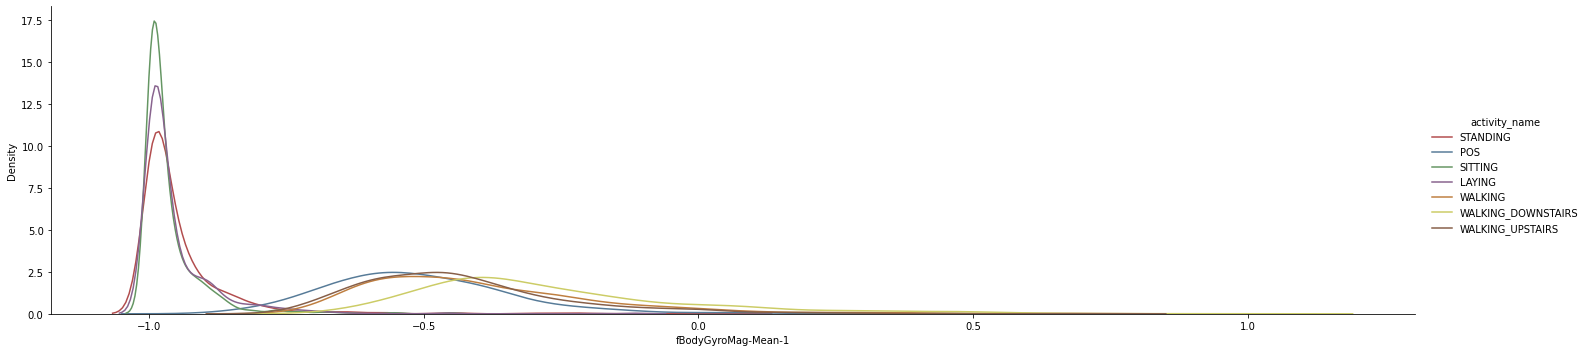

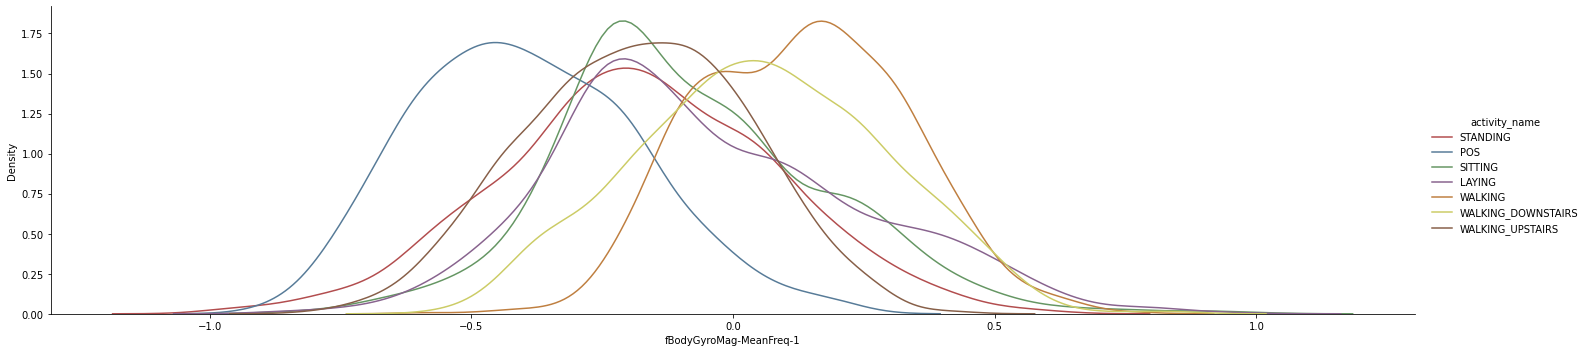

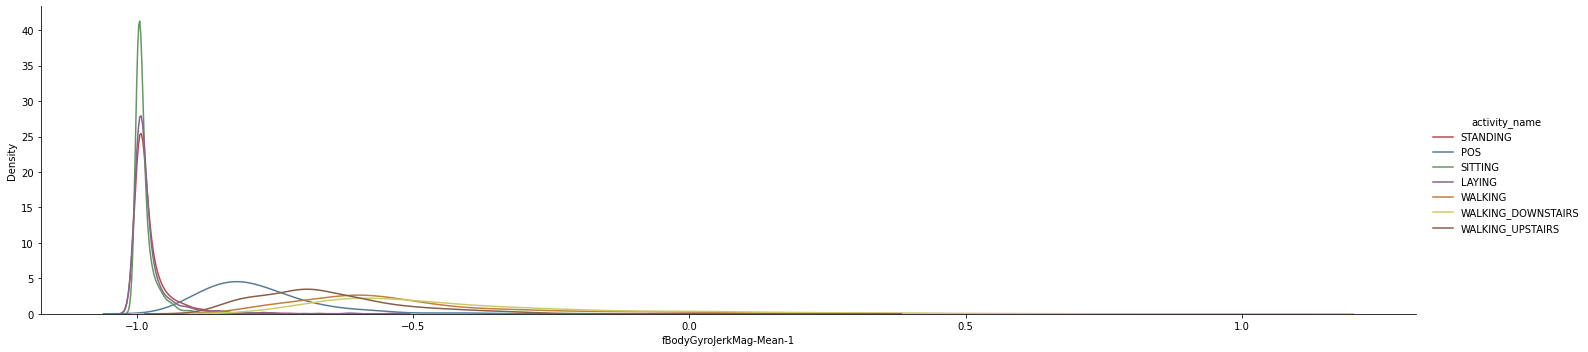

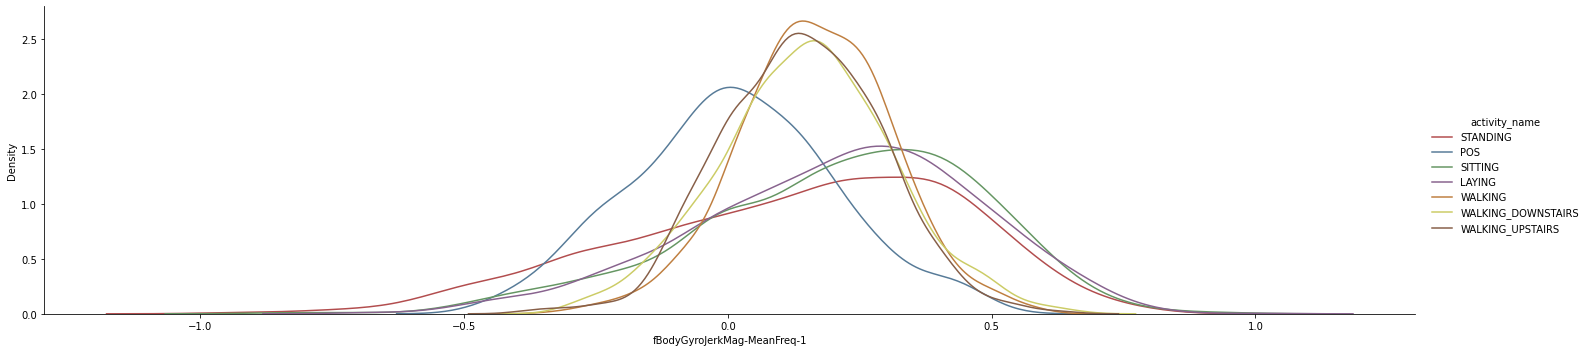

In [ ]:
# Plot the signal of selected variables using sns.FacetGrid.
columns =[
    'tBodyAcc-Mean-1','tBodyAcc-Mean-2','tBodyAcc-Mean-3', 'tBodyGyro-Mean-1','tBodyGyro-Mean-2',
    'tBodyGyro-Mean-3','tBodyAccJerk-Mean-1','tBodyAccJerk-Mean-2','tBodyAccJerk-Mean-3', 'tGravityAcc-Mean-1', 
    'tGravityAcc-Mean-2', 'tGravityAcc-Mean-3', 'tBodyGyroJerk-Mean-1','tBodyGyroJerk-Mean-2','tBodyGyroJerk-Mean-3', 
    'fBodyAcc-Mean-1','fBodyAcc-Mean-2','fBodyAcc-Mean-3', 'fBodyAcc-MeanFreq-1','fBodyAcc-MeanFreq-2',
    'fBodyAcc-MeanFreq-3','fBodyAccJerk-Mean-1','fBodyAccJerk-Mean-2','fBodyAccJerk-Mean-3', 'fBodyAccJerk-MeanFreq-1',
    'fBodyAccJerk-MeanFreq-2','fBodyAccJerk-MeanFreq-3','fBodyGyro-Mean-1','fBodyGyro-Mean-2','fBodyGyro-Mean-3',
    'fBodyGyro-MeanFreq-1','fBodyGyro-MeanFreq-2','fBodyGyro-MeanFreq-3', 'tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1', 
    'tBodyAccJerkMag-Mean-1', 'tBodyGyroMag-Mean-1', 'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1',  'fBodyAccMag-MeanFreq-1', 
    'fBodyAccJerkMag-Mean-1',  'fBodyGyroMag-Mean-1','fBodyGyroMag-MeanFreq-1', 'fBodyGyroJerkMag-Mean-1', 'fBodyGyroJerkMag-MeanFreq-1'] 

for column in columns:
  _plot_facetgrid(
      df =X_train_df1,
      hue='activity_name',  #the categorical variable we want to group by
      column_name = column, #variable(s) we want to plot
      palette="Set1",
      desat=0.50,
      size=5,
      aspect=4,
      hist=False)

After analyzing the density plots of the training dataset, it was observed that the distribution of data points for stationary and moving activities differed significantly. This difference can be leveraged to differentiate between static (stationary) and dynamic (moving) activities in a classification task.

In [ ]:
columns =['fBodyAcc-Mean-1','fBodyAcc-Mean-2','fBodyAcc-Mean-3','fBodyGyro-Mean-1','fBodyGyro-Mean-2',
'fBodyGyro-Mean-3','tBodyAccMag-Mean-1', 'tGravityAccMag-Mean-1','tBodyAccJerkMag-Mean-1', 'tBodyGyroMag-Mean-1', 
'tBodyGyroJerkMag-Mean-1', 'fBodyAccMag-Mean-1', 'fBodyAccJerkMag-Mean-1',  'fBodyGyroMag-Mean-1','fBodyGyroJerkMag-Mean-1']

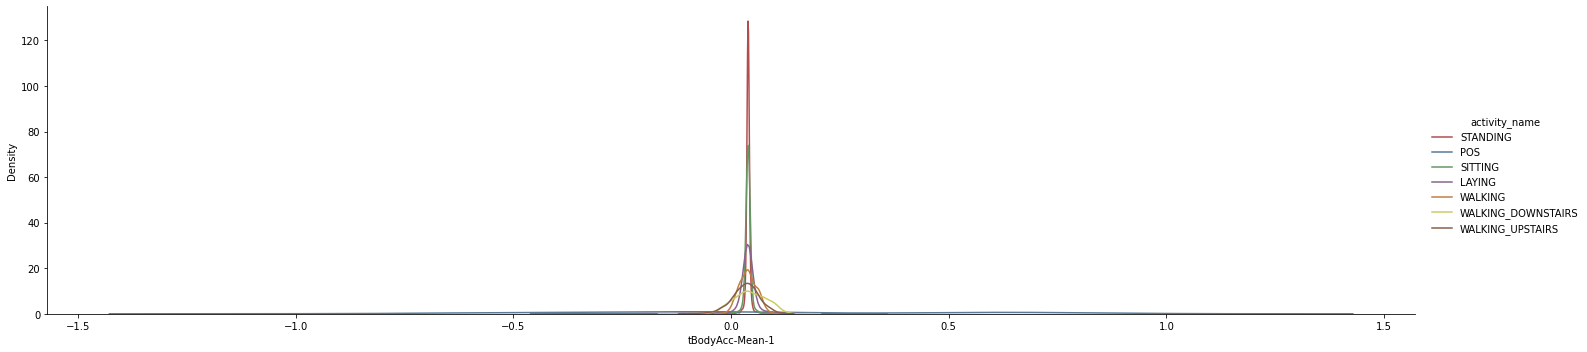

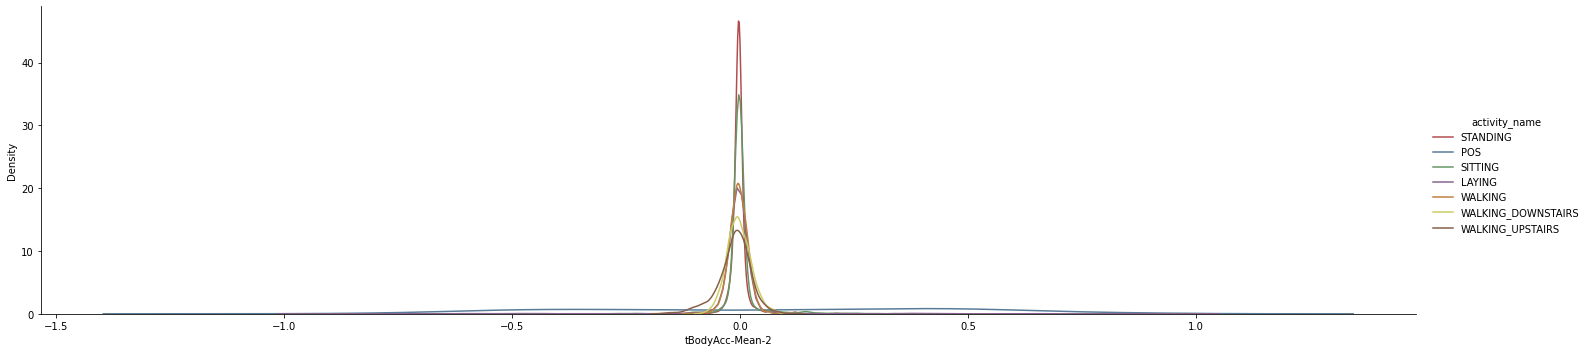

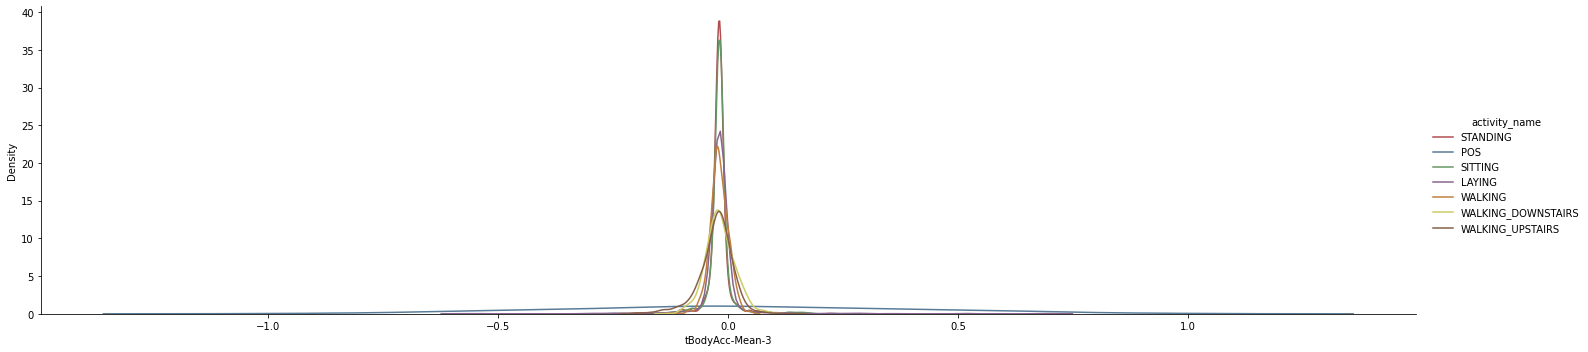

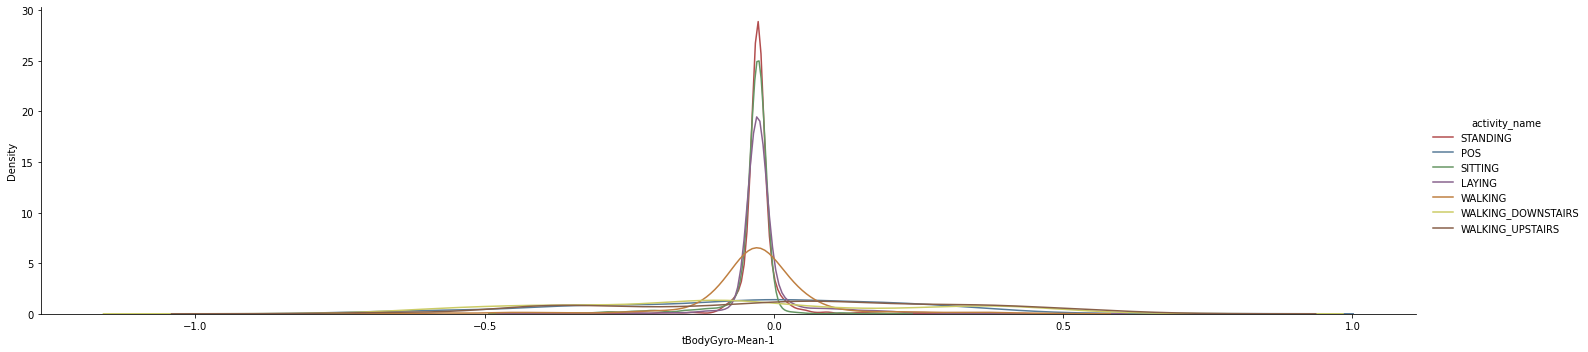

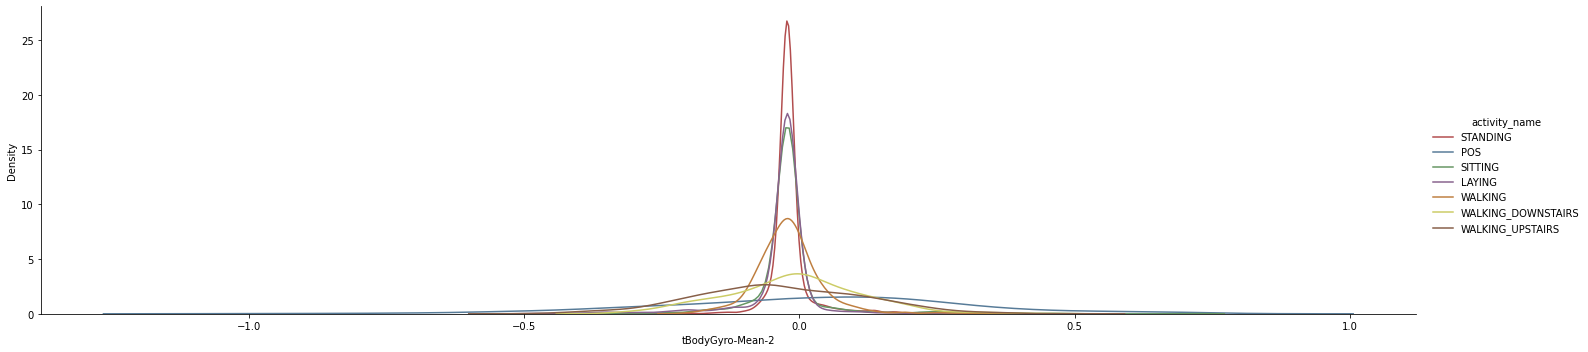

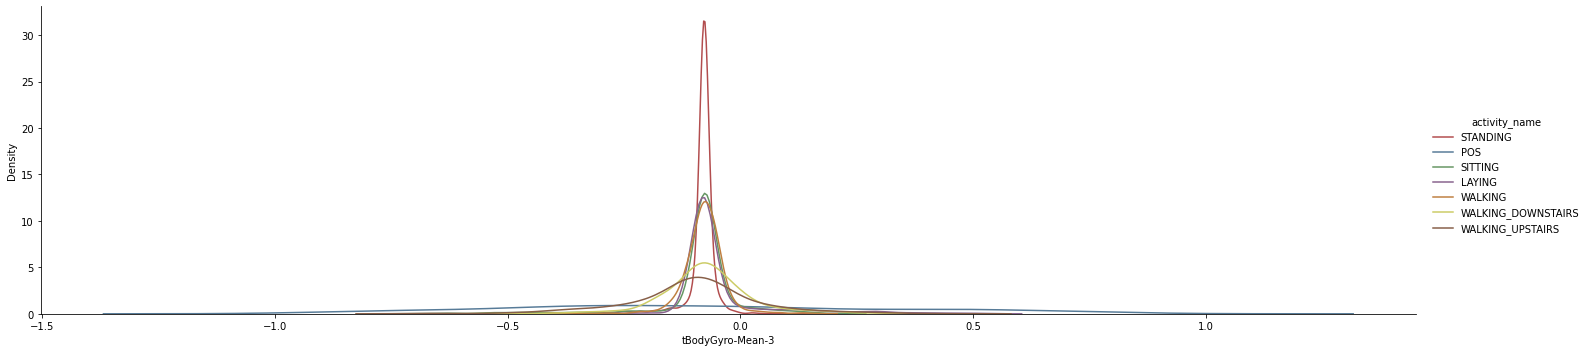

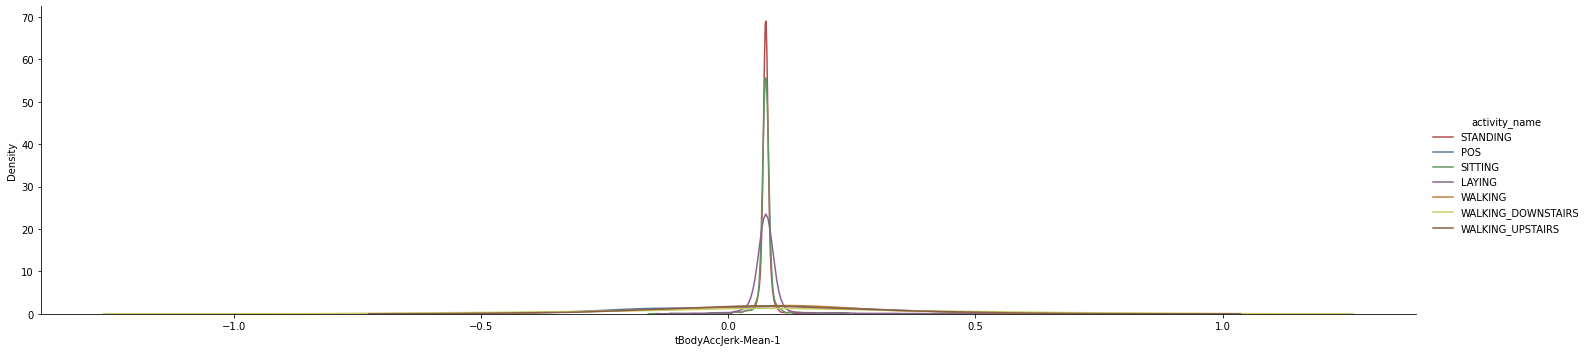

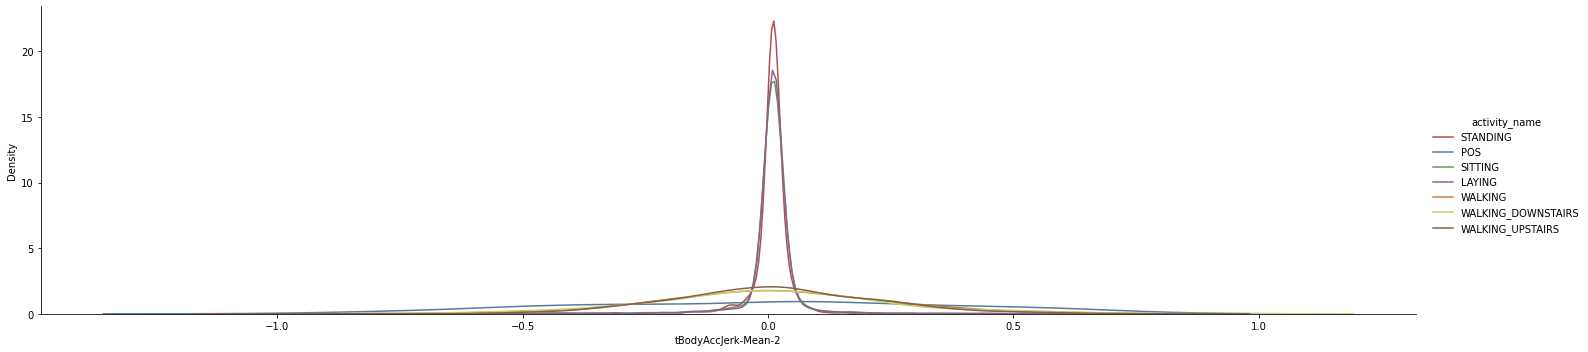

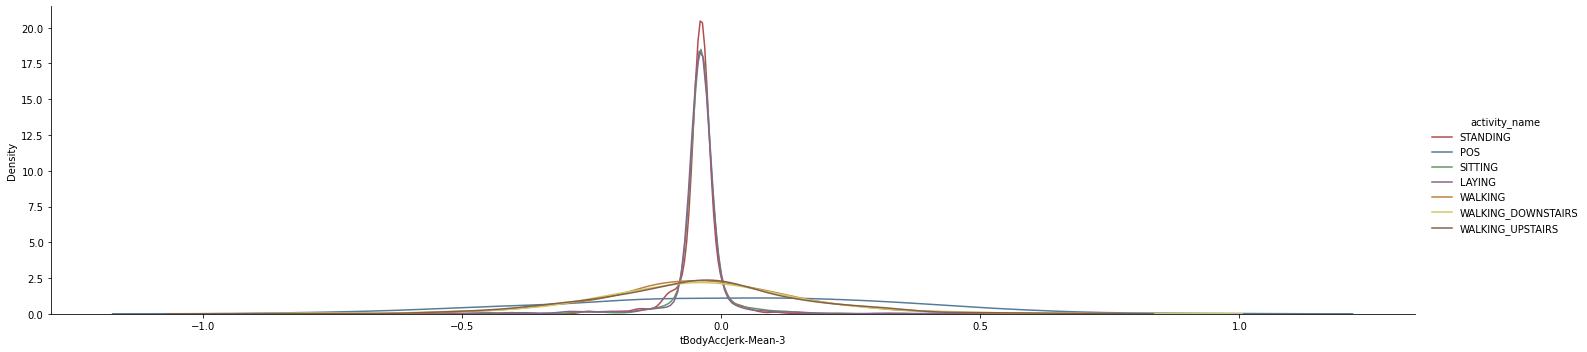

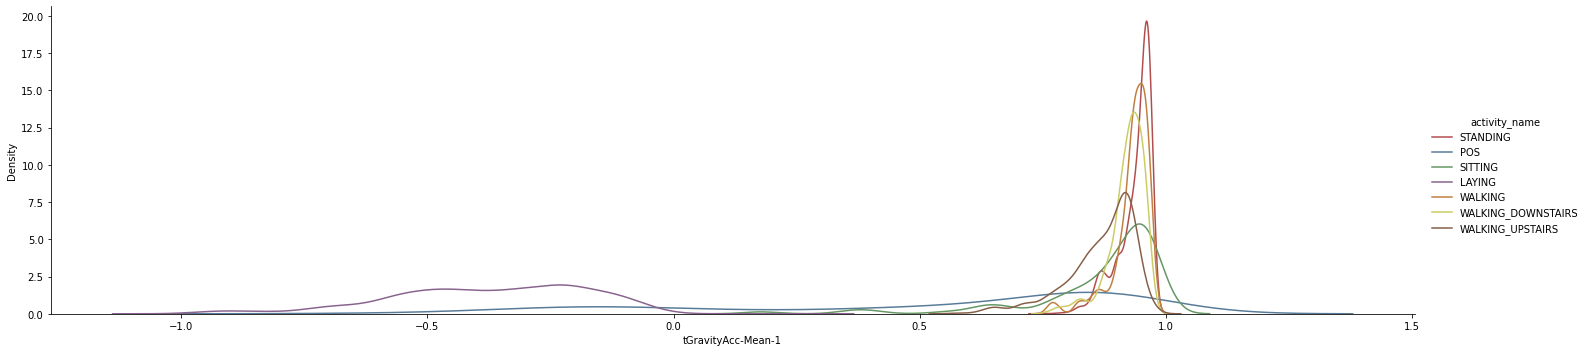

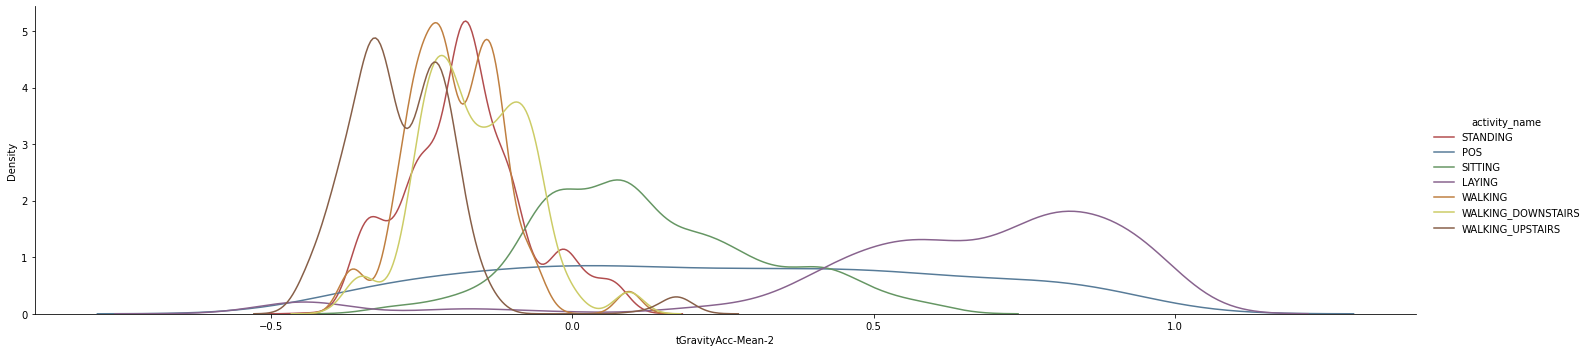

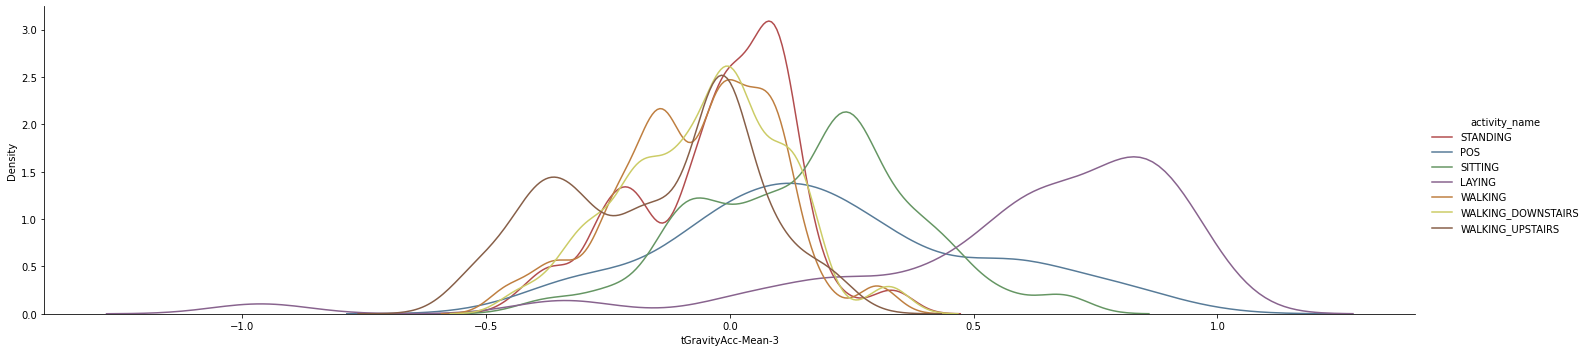

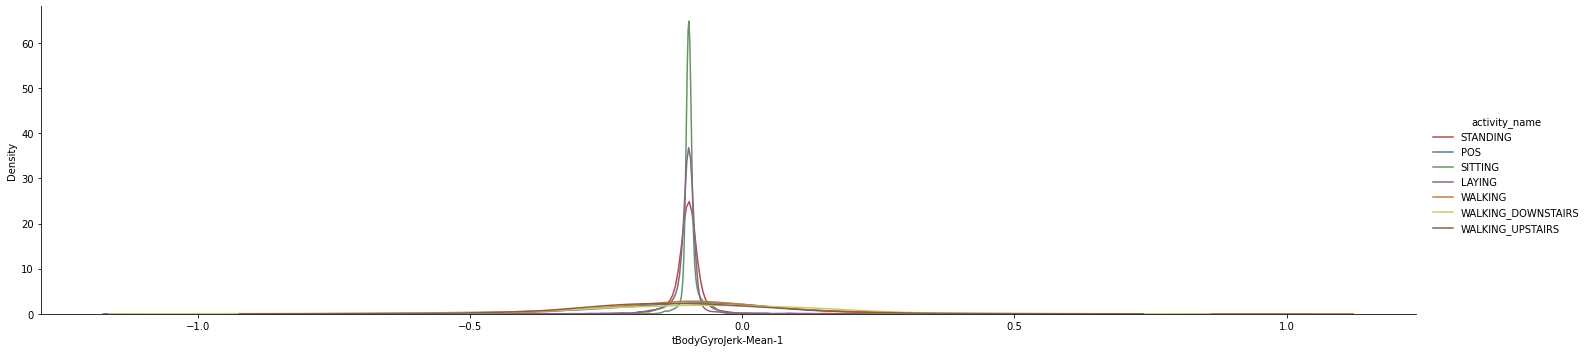

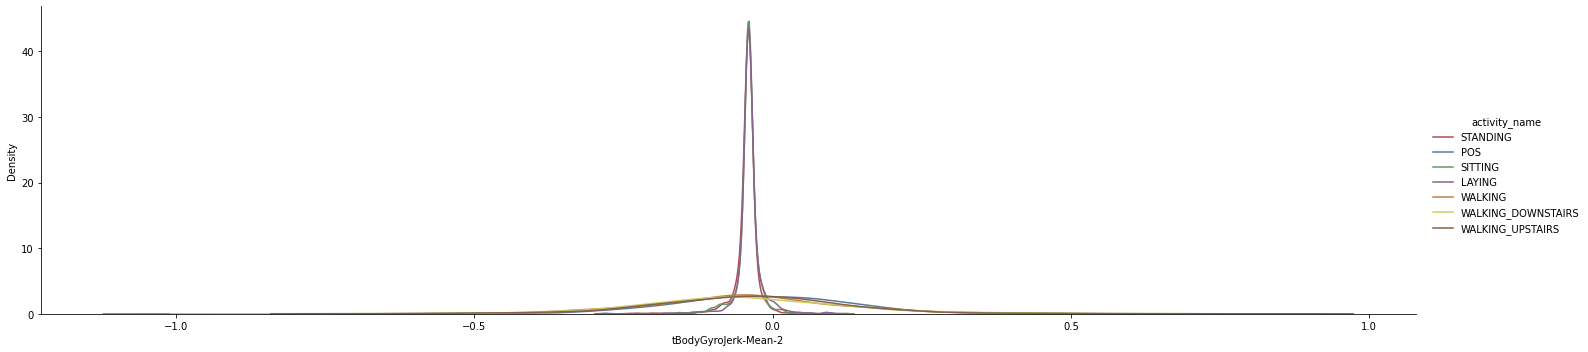

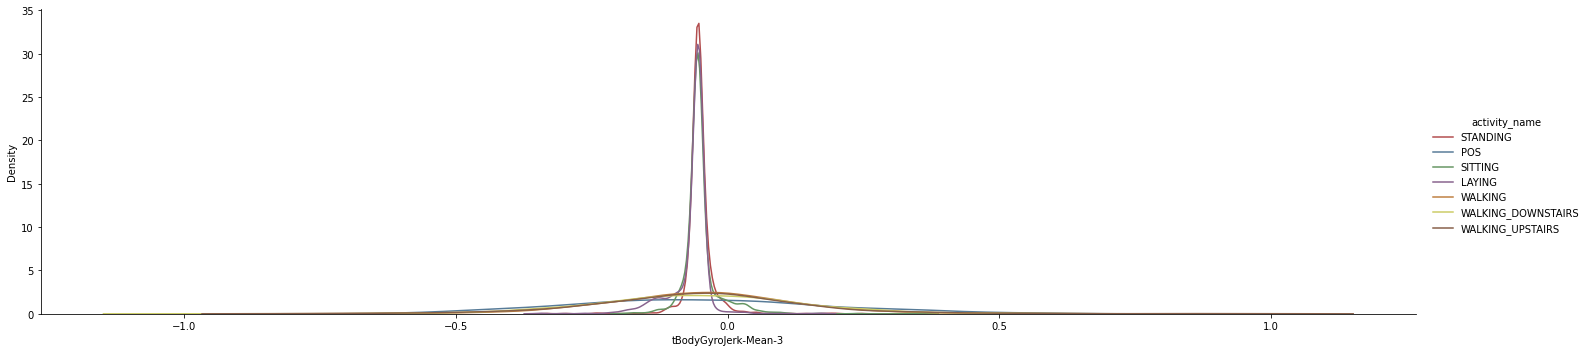

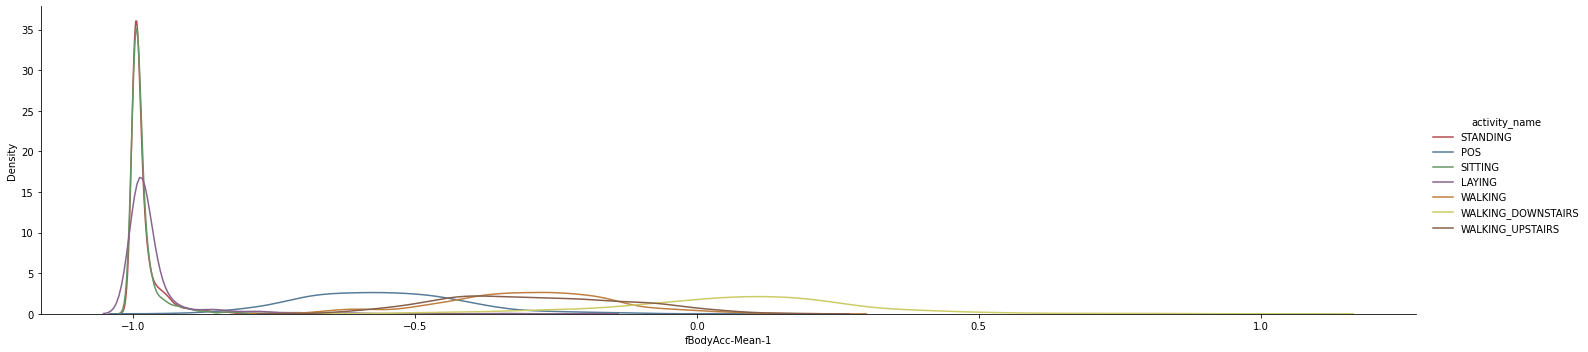

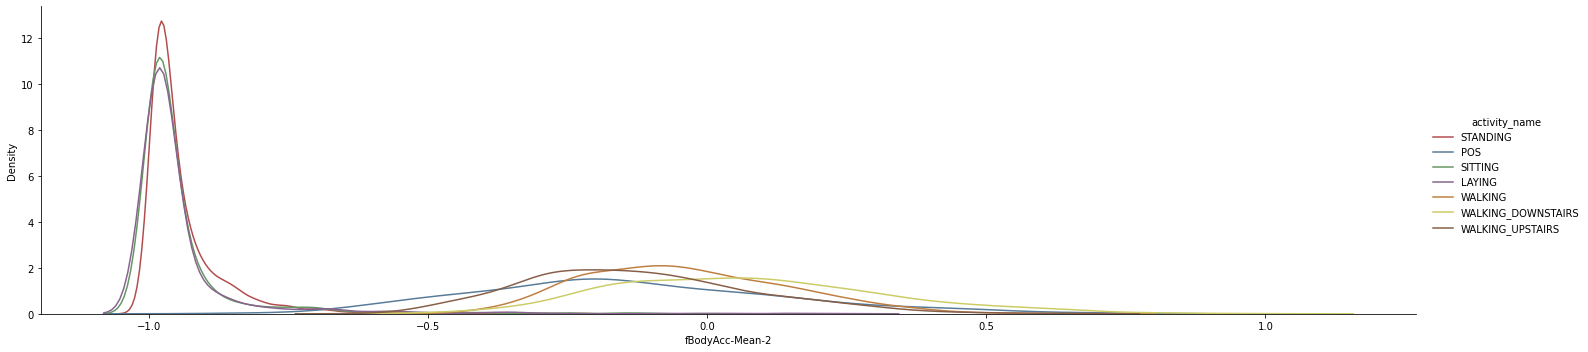

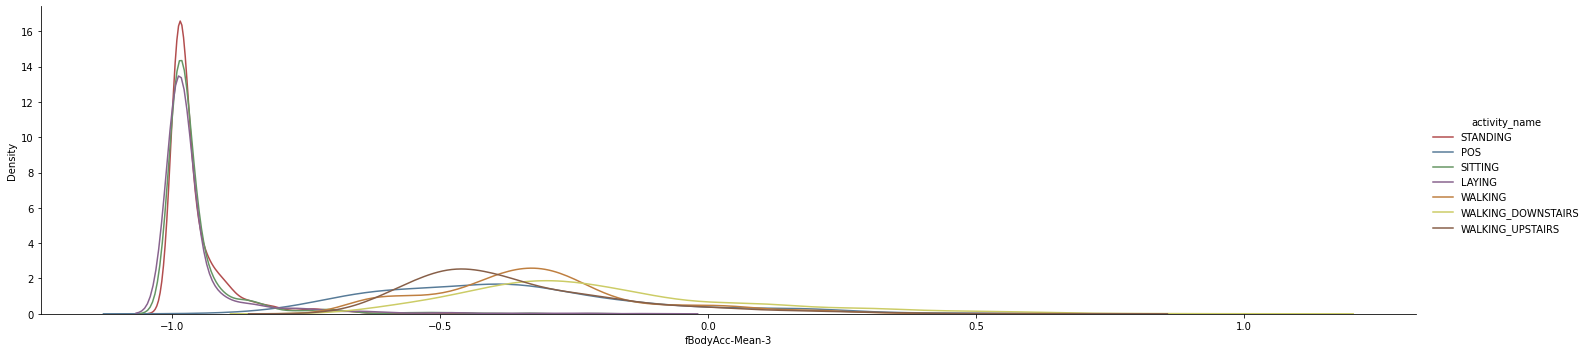

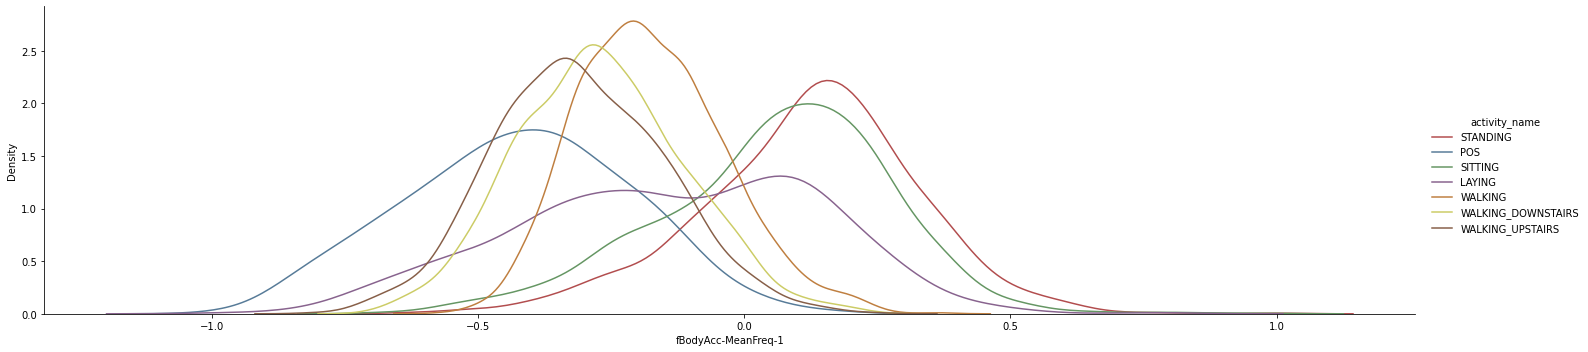

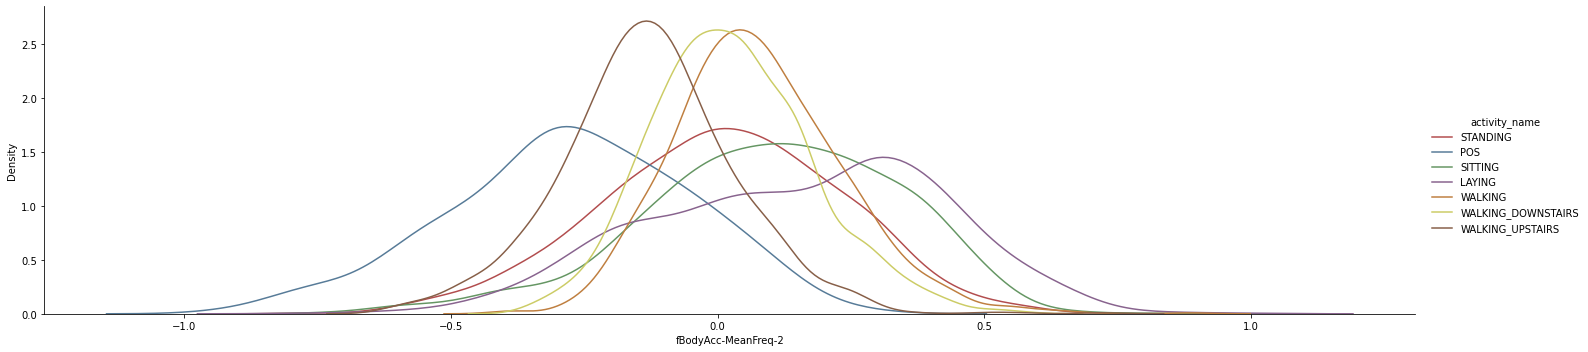

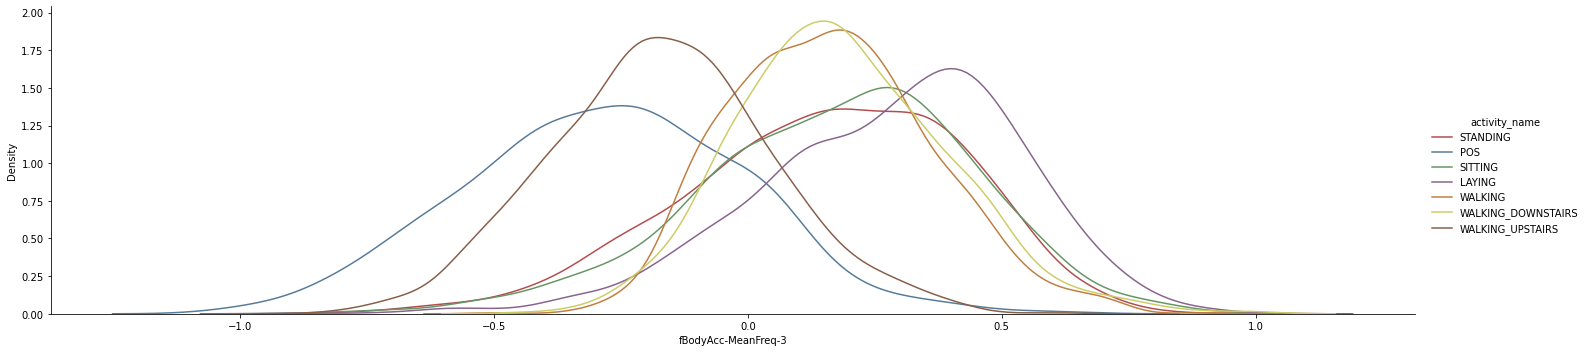

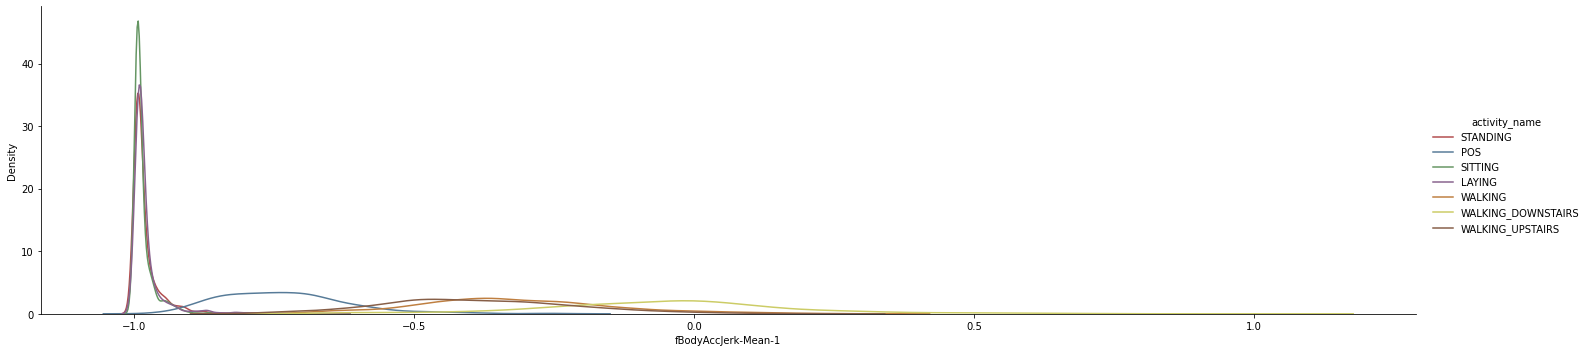

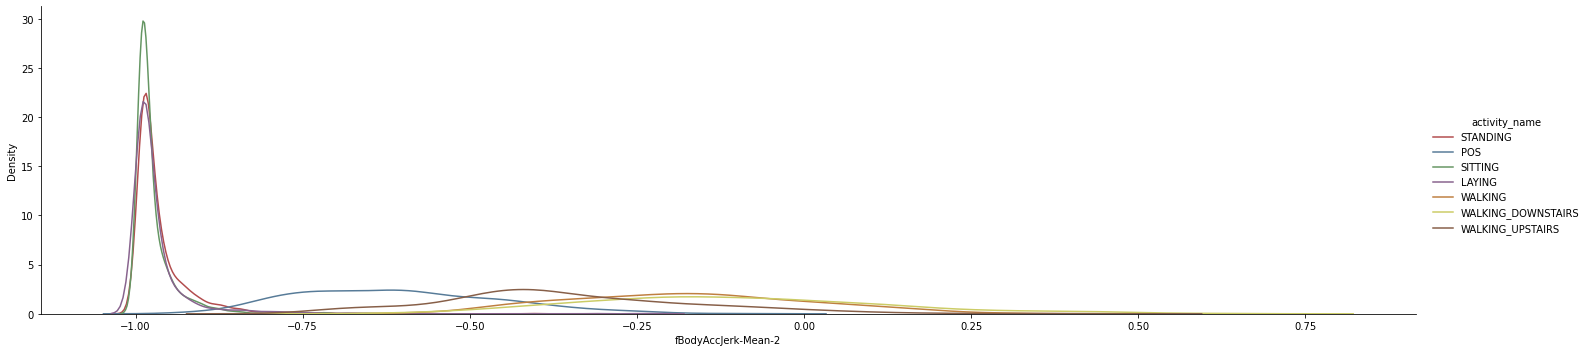

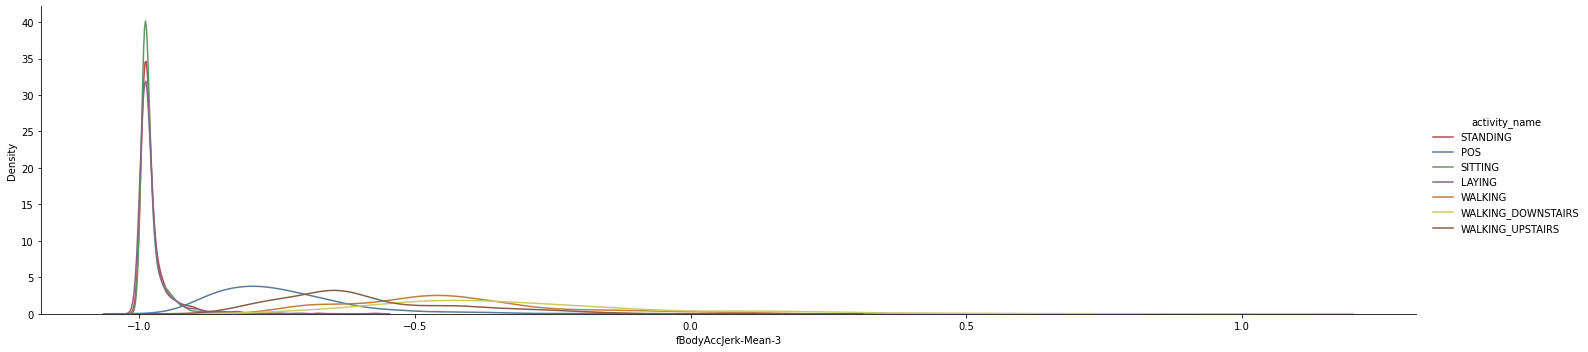

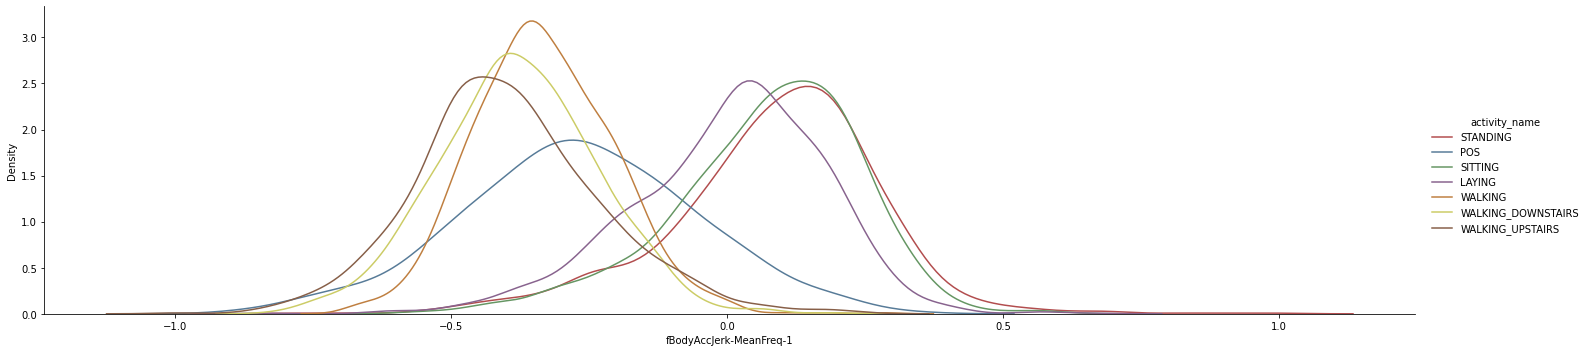

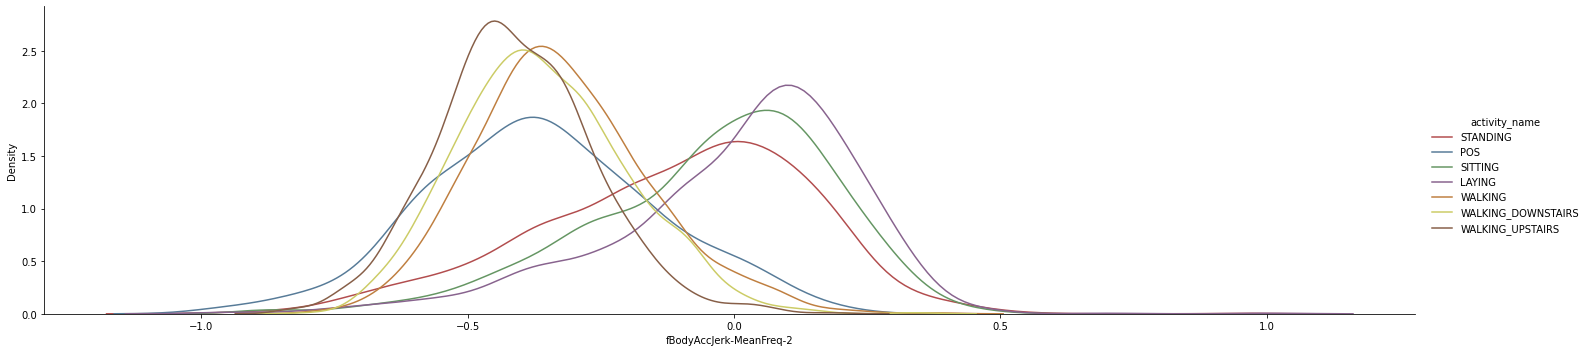

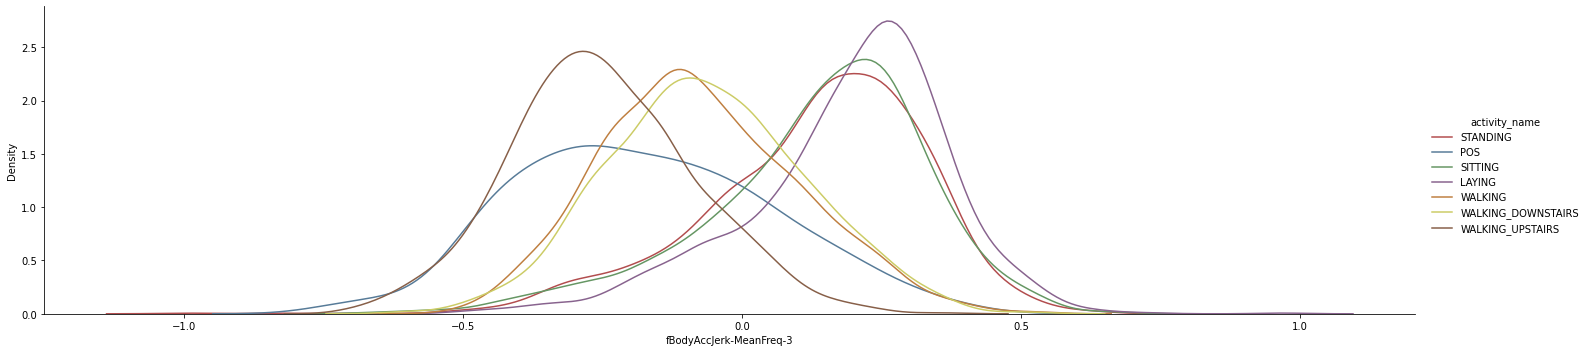

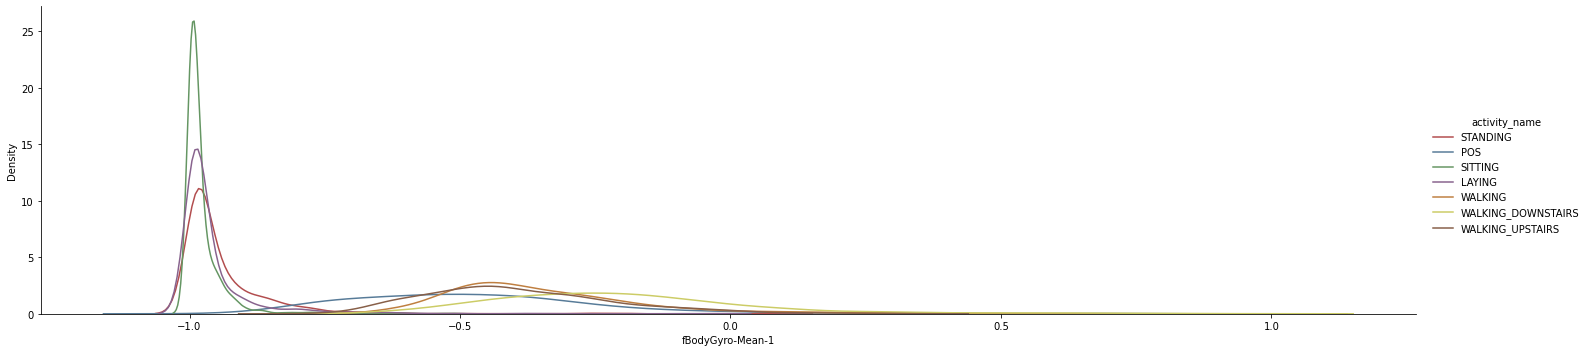

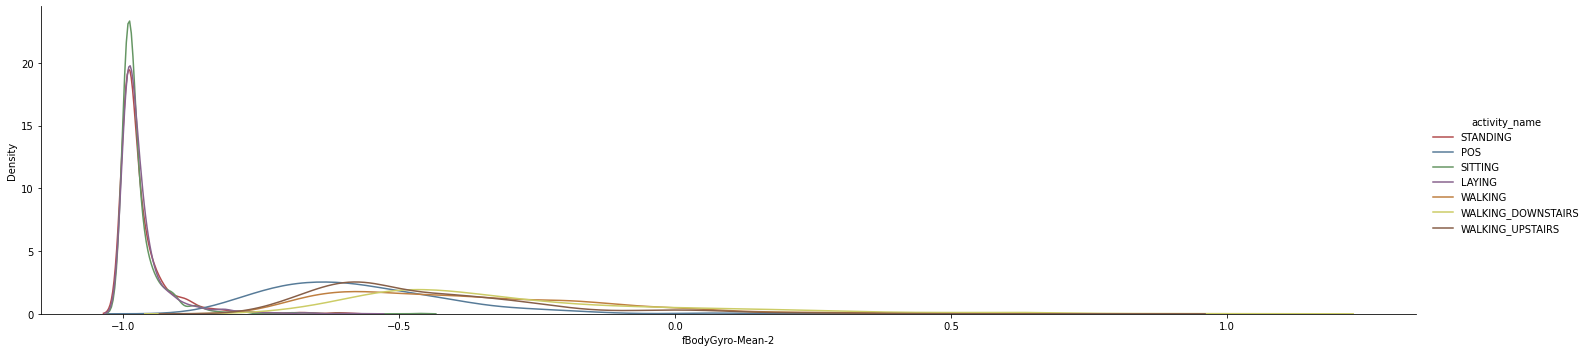

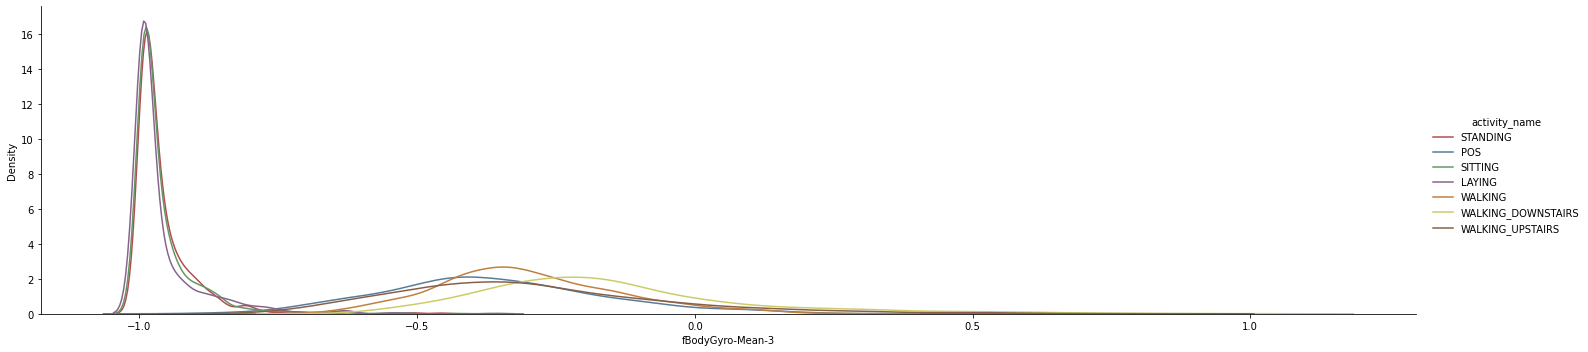

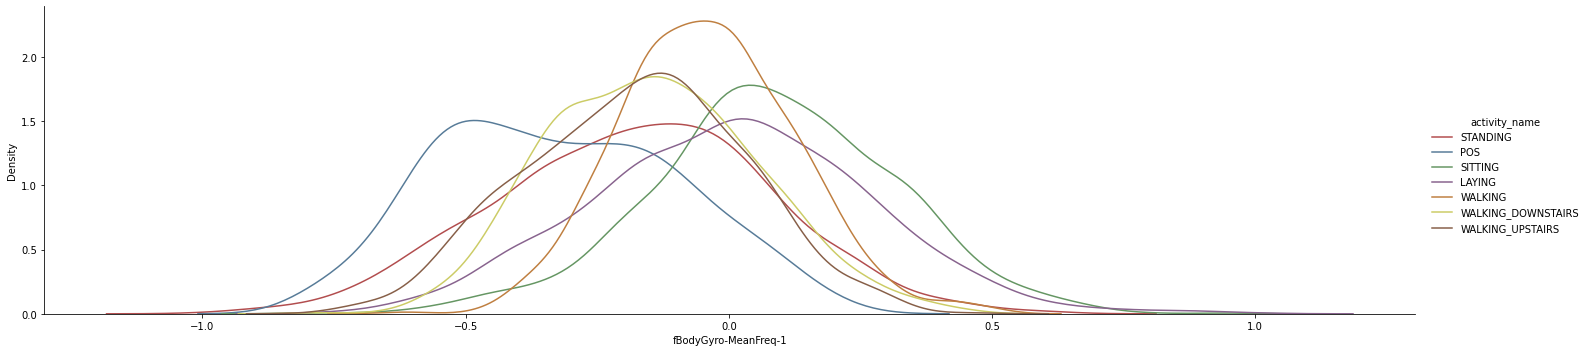

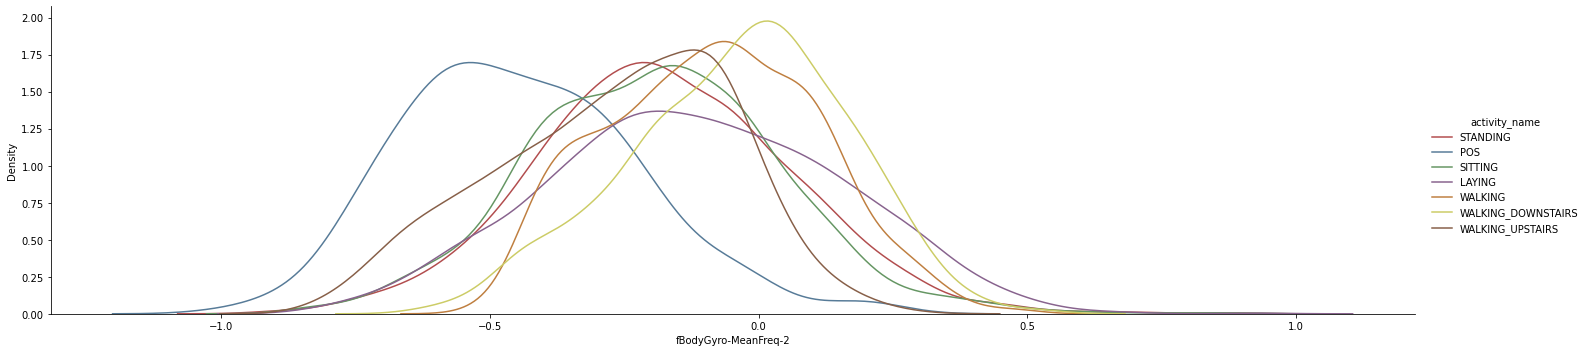

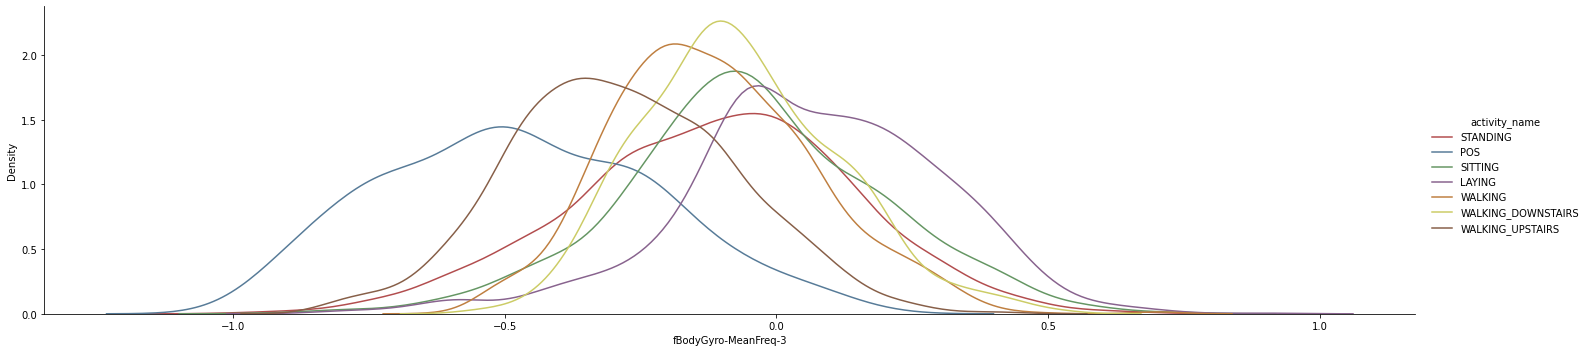

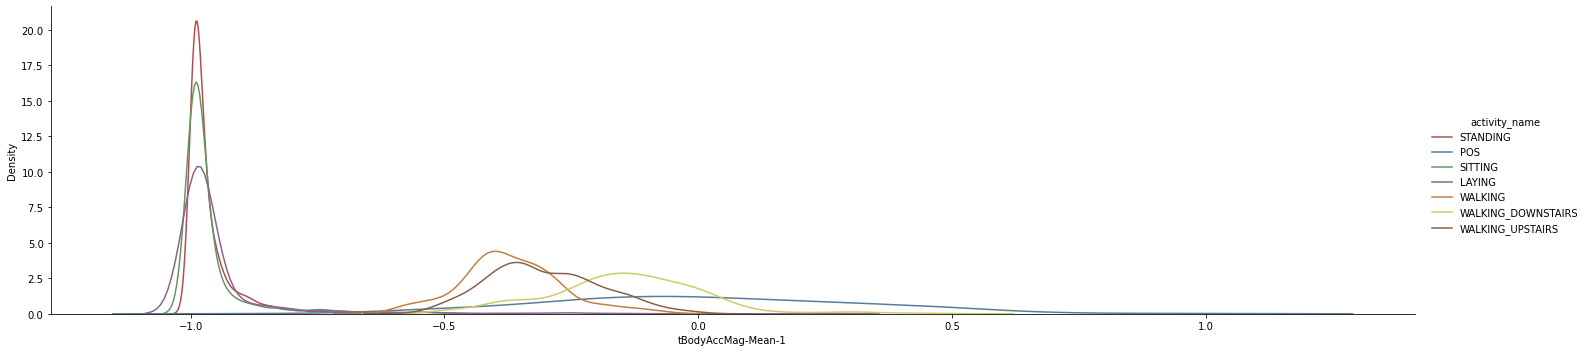

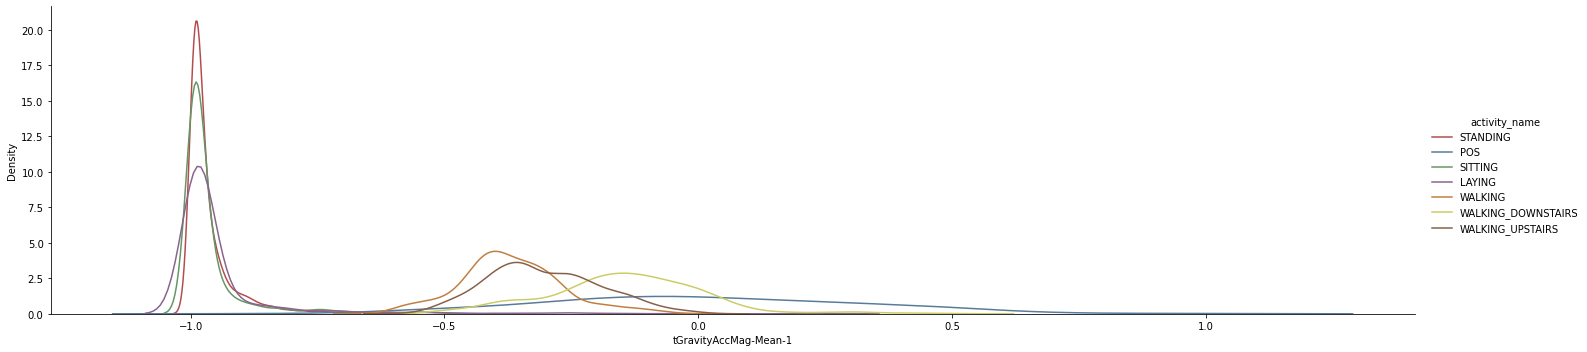

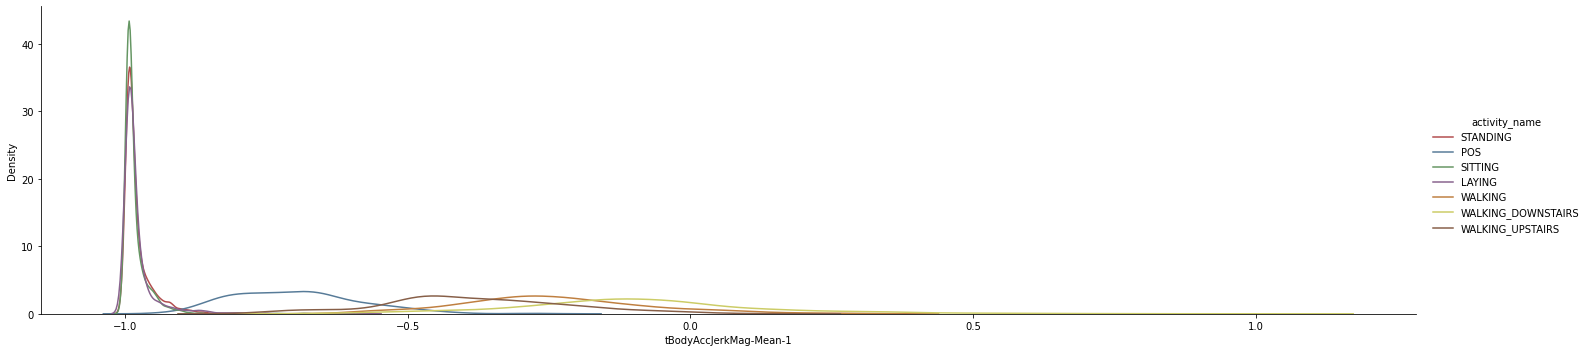

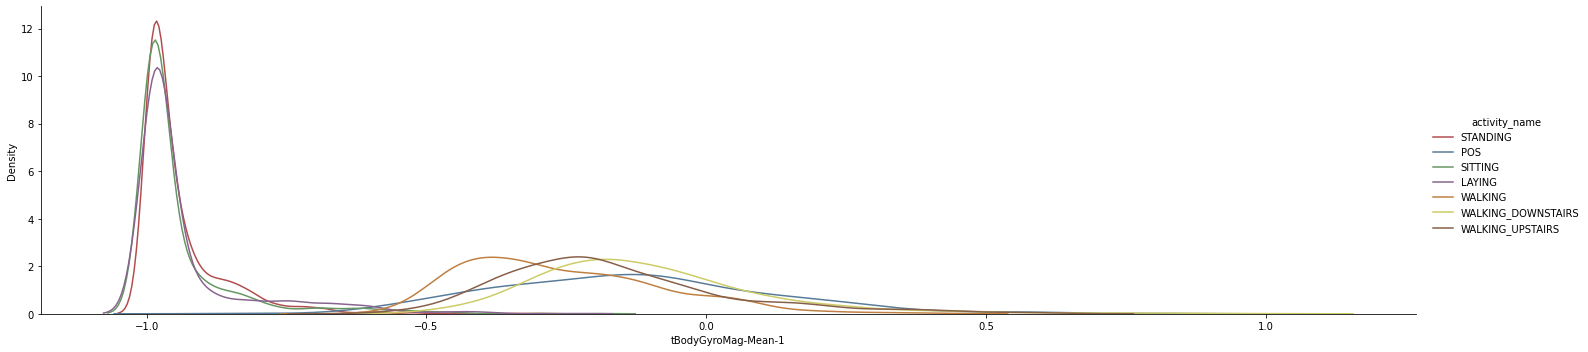

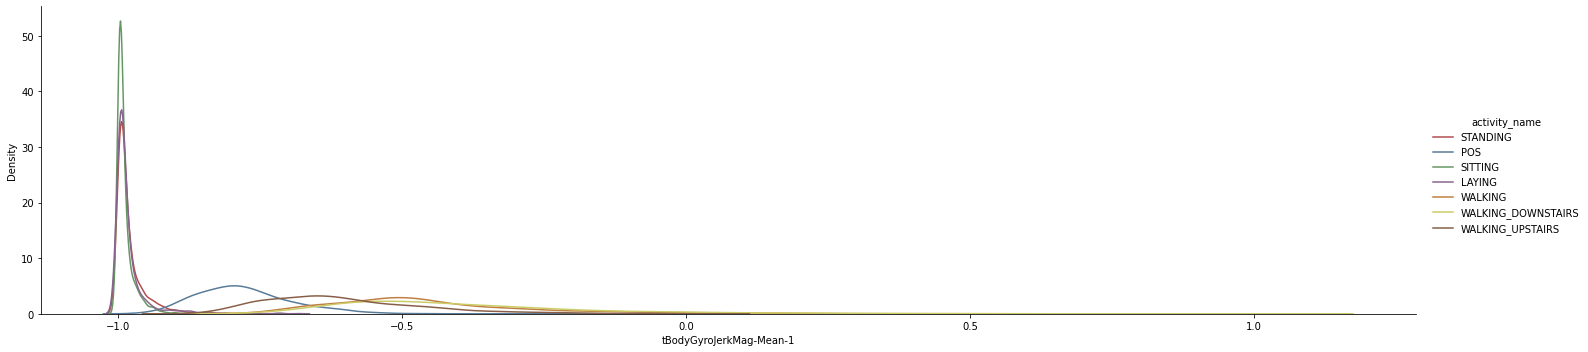

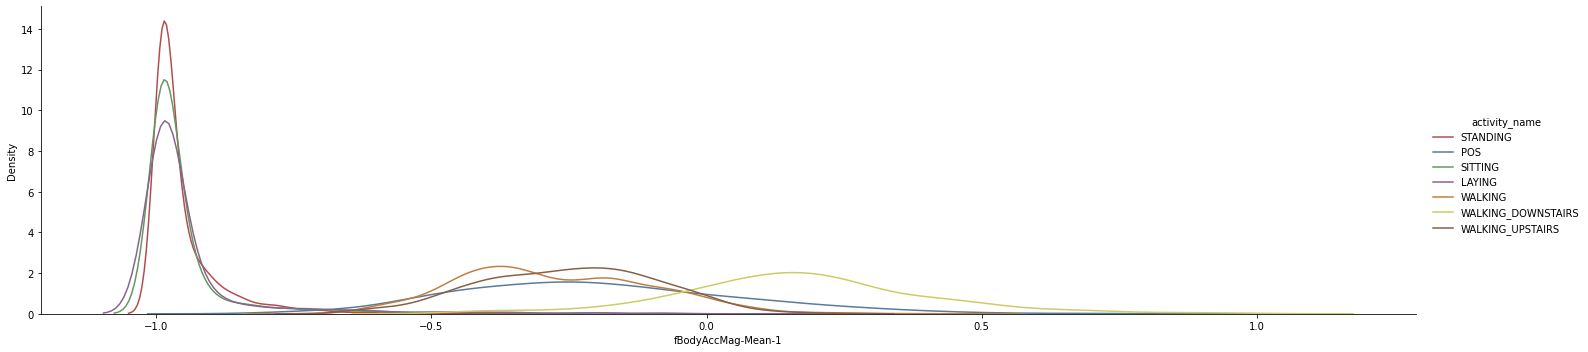

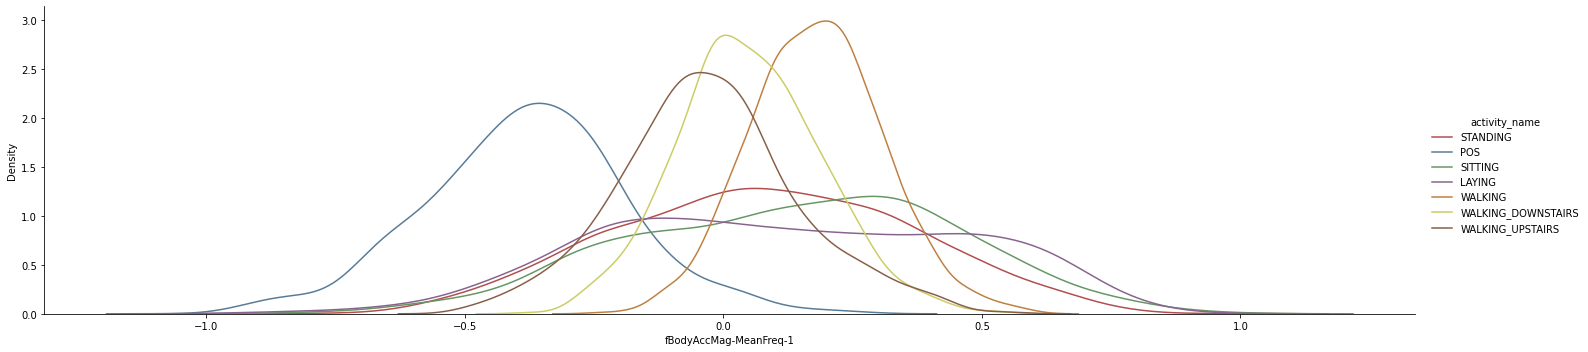

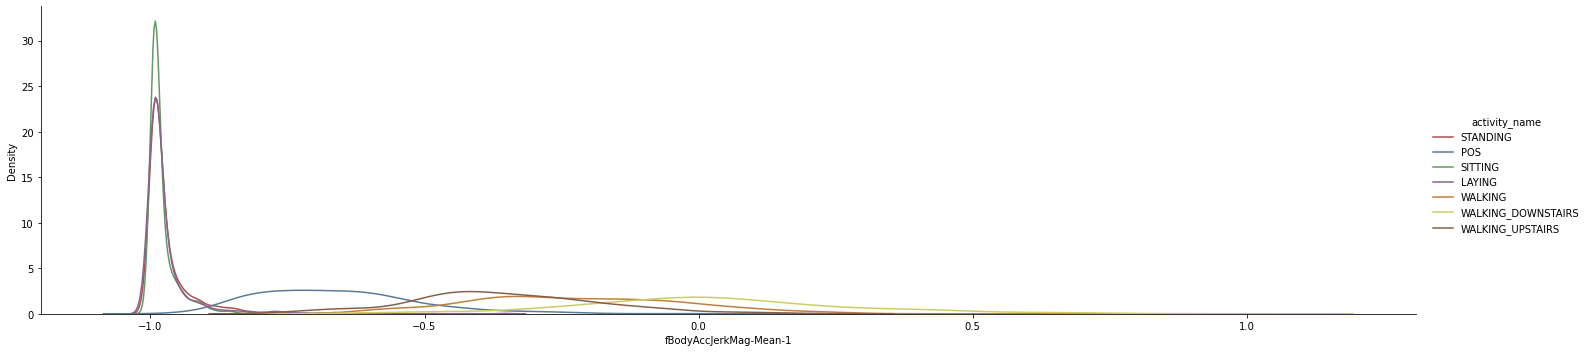

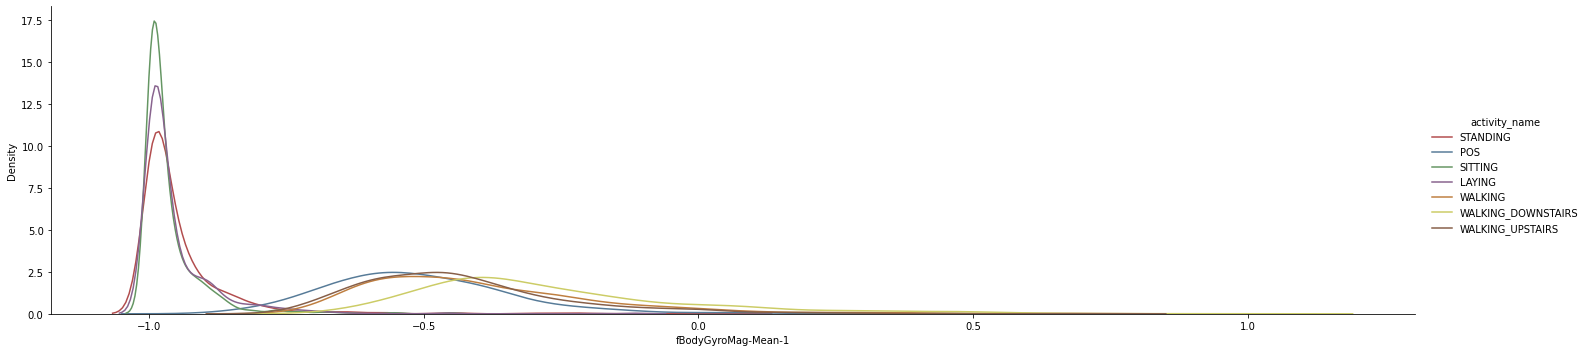

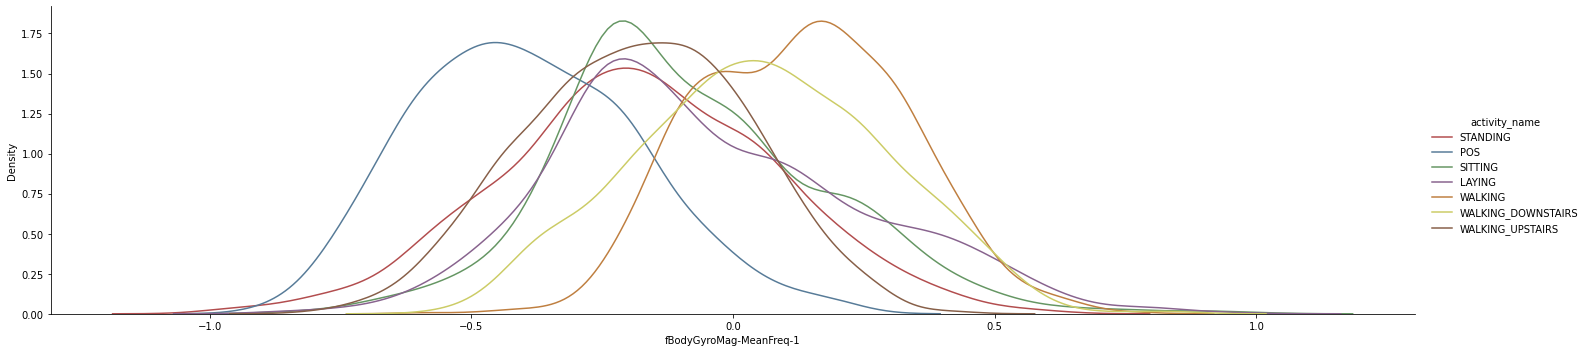

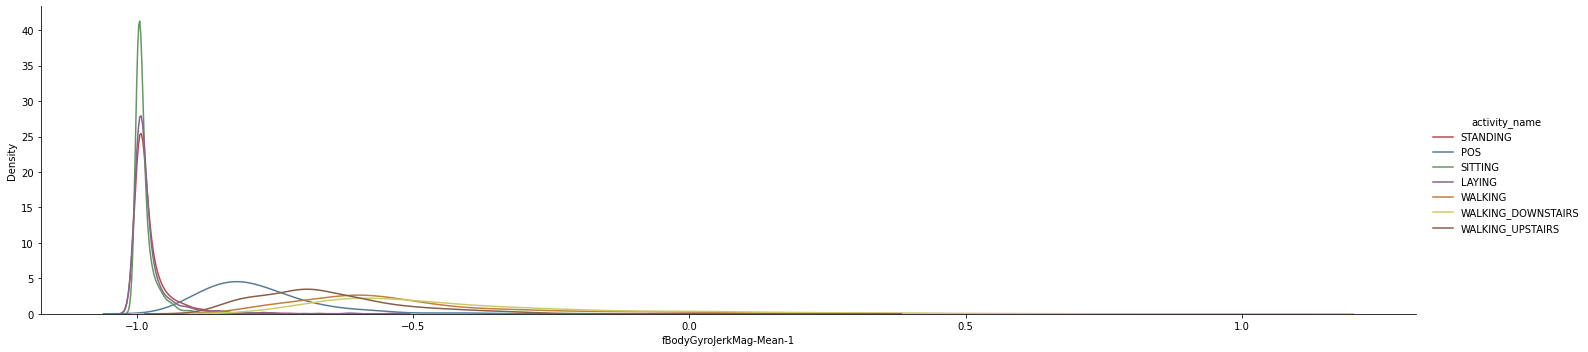

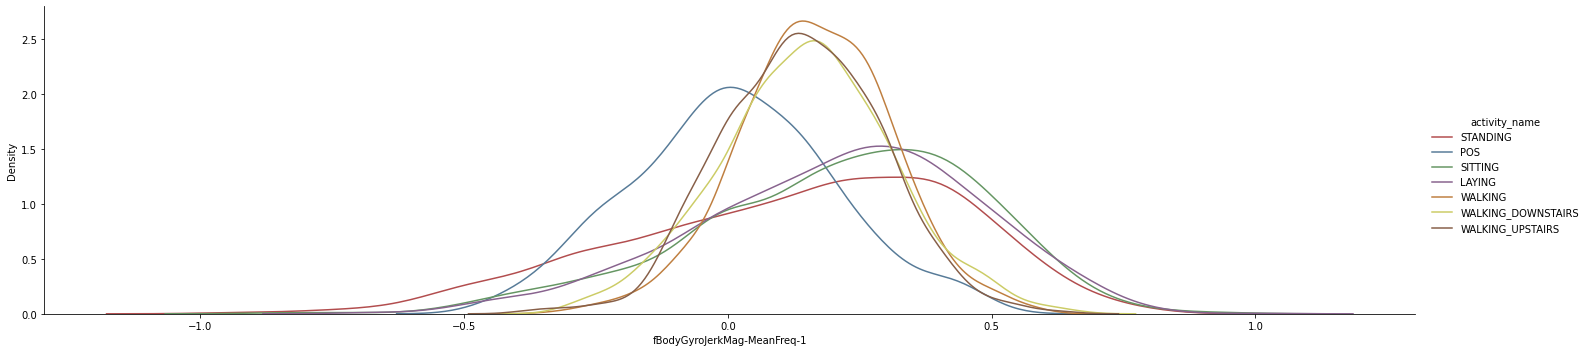

In [ ]:
for column in columns:
  _plot_facetgrid(
      df =X_train_df1,
      hue='activity_name',
      column_name = column,
      palette="Set1",
      desat=0.50,
      size=5,
      aspect=4,
      hist=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7767 samples in 0.003s...
[t-SNE] Computed neighbors for 7767 samples in 2.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7767
[t-SNE] Computed conditional probabilities for sample 2000 / 7767
[t-SNE] Computed conditional probabilities for sample 3000 / 7767
[t-SNE] Computed conditional probabilities for sample 4000 / 7767
[t-SNE] Computed conditional probabilities for sample 5000 / 7767
[t-SNE] Computed conditional probabilities for sample 6000 / 7767
[t-SNE] Computed conditional probabilities for sample 7000 / 7767
[t-SNE] Computed conditional probabilities for sample 7767 / 7767
[t-SNE] Mean sigma: 1.423747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.229195
[t-SNE] KL divergence after 2000 iterations: 1.257449


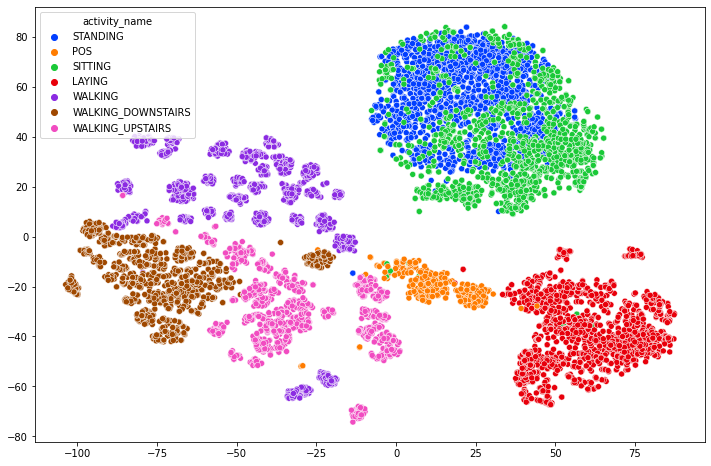

In [ ]:
 tsne_ptl(df = X_train_df1,drop_columns =['user_id','activity_id','activity_name'],hue="activity_name")

Based on the cluster graph, we can observe that static activities (Standing and Sitting) are clustered together, while dynamic activities (Walking_Upstairs, Walking_Downstairs, and Walking) are closely clustered. Laying (static activity) is found in a separate group and located on the positive x-axis side along with Sitting and Standing

In [ ]:
# Create a dictionary to map activity names to types Ids (SIT=0, MOT=1 and POS=2)
activity_type_id_map = {'SITTING': 0, 'STANDING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1,'POS': 2}
# Create a dictionary to map activity names to types Names
activity_type_name_map = {'SITTING': 'SIT', 'STANDING': 'SIT', 'LAYING': 'SIT', 'WALKING': 'MOT', 'WALKING_UPSTAIRS': 'MOT', 'WALKING_DOWNSTAIRS': 'MOT','POS': 'POS'}

In [ ]:
# Apply the mapping to create a new column 'activity_type' in x_train_df
X_train_df1['activity_type_id'] = X_train_df1['activity_name'].map(activity_type_id_map)
X_train_df1['activity_type_name'] = X_train_df1['activity_name'].map(activity_type_name_map)

# Apply the mapping to create a new column 'activity_Type' in x_test_df
X_test_df1['activity_type_id'] = X_test_df1['activity_name'].map(activity_type_id_map)
X_test_df1['activity_type_name'] = X_test_df1['activity_name'].map(activity_type_name_map)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7767 samples in 0.004s...
[t-SNE] Computed neighbors for 7767 samples in 2.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7767
[t-SNE] Computed conditional probabilities for sample 2000 / 7767
[t-SNE] Computed conditional probabilities for sample 3000 / 7767
[t-SNE] Computed conditional probabilities for sample 4000 / 7767
[t-SNE] Computed conditional probabilities for sample 5000 / 7767
[t-SNE] Computed conditional probabilities for sample 6000 / 7767
[t-SNE] Computed conditional probabilities for sample 7000 / 7767
[t-SNE] Computed conditional probabilities for sample 7767 / 7767
[t-SNE] Mean sigma: 1.423747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.229195
[t-SNE] KL divergence after 1000 iterations: 1.296492


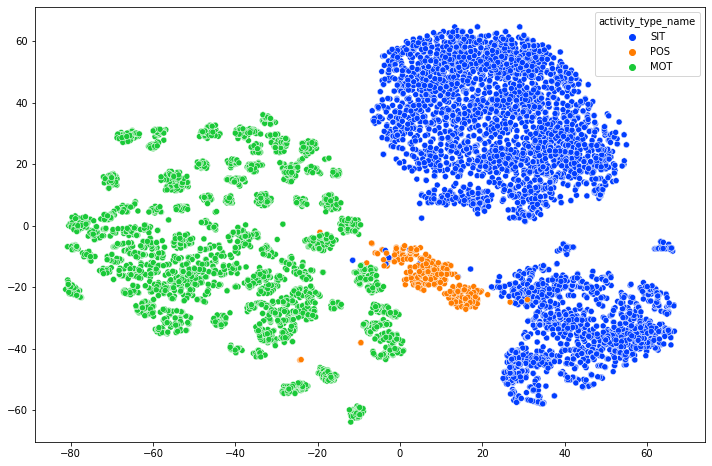

In [ ]:
tsne_ptl(df = X_train_df1,drop_columns =['activity_type_id',"activity_type_name",'user_id','activity_id','activity_name'],hue="activity_type_name",n_iter = 1000)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3162 samples in 0.002s...
[t-SNE] Computed neighbors for 3162 samples in 1.490s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3162
[t-SNE] Computed conditional probabilities for sample 2000 / 3162
[t-SNE] Computed conditional probabilities for sample 3000 / 3162
[t-SNE] Computed conditional probabilities for sample 3162 / 3162
[t-SNE] Mean sigma: 1.594752
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.622055
[t-SNE] KL divergence after 1000 iterations: 0.931476


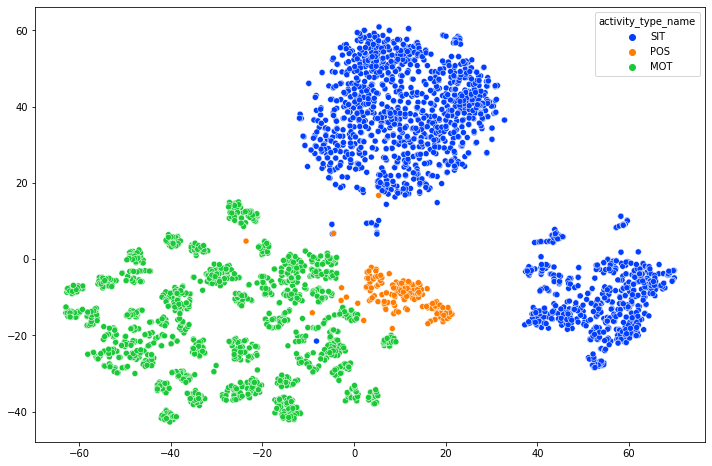

In [ ]:
tsne_ptl(df = X_test_df1,drop_columns =['activity_type_id',"activity_type_name",'user_id','activity_id','activity_name'],hue="activity_type_name",n_iter = 1000)

## Data Balance 

To ensure the dataset is suitable for training, it is useful to determine the balance of the activities in the data frame.

In [ ]:
activities = ['SIT', 'POS', 'MOT']
df_balance(df=X_train_df1,group_by_column='activity_type_name',classes=activities)

SIT, total=3286, percentage=42.307
POS, total=352, percentage=4.532
MOT, total=4129, percentage=53.161


The analysis of the dataset reveals that the number of observations for the POS activity is much lower than those for the SIT and MOT activities. This imbalance in the number of observations could potentially affect the training process and lead to inaccurate results. It is important to have a balanced dataset, as a model trained on an imbalanced dataset may be biased towards the majority class (SIT and MOT), leading to poor performance on the minority class (POS).

To address this imbalance, there are several methods that can be used, such as oversampling the minority class or undersampling the majority class. However, due to the time constraints of the project, it was decided to use the dataset as is and proceed with training the model. While this approach may lead to some bias in the model towards the majority classes, it is the best solution given the time constraints.

## Training

In [ ]:
y_train= X_train_df1['activity_type_id']
y_test= X_test_df1['activity_type_id']

In [ ]:
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)

y_train shape (7767,)
y_test shape (3162,)


In [ ]:
# Reshape the y_train and y_test to shape (7767, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [ ]:
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)

y_train shape (7767, 1)
y_test shape (3162, 1)


In [ ]:
# 'activity_type_id',
X_train = X_train_df1.drop(["activity_type_name",'user_id','activity_id','activity_name'], axis = 1)
X_test = X_test_df1.drop(["activity_type_name",'user_id','activity_id','activity_name'], axis = 1)

In [ ]:
X_train.columns

Index(['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3',
       'tBodyAcc-STD-1', 'tBodyAcc-STD-2', 'tBodyAcc-STD-3', 'tBodyAcc-Mad-1',
       'tBodyAcc-Mad-2', 'tBodyAcc-Mad-3', 'tBodyAcc-Max-1',
       ...
       'fBodyGyroJerkMag-Skewness-1', 'fBodyGyroJerkMag-Kurtosis-1',
       'tBodyAcc-AngleWRTGravity-1', 'tBodyAccJerk-AngleWRTGravity-1',
       'tBodyGyro-AngleWRTGravity-1', 'tBodyGyroJerk-AngleWRTGravity-1',
       'tXAxisAcc-AngleWRTGravity-1', 'tYAxisAcc-AngleWRTGravity-1',
       'tZAxisAcc-AngleWRTGravity-1', 'activity_type_id'],
      dtype='object', length=562)

In [ ]:
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (7767, 562)
X_test shape: (3162, 562)


In [ ]:
# we'll start out with a 20 minute input sequence and a one minute predictive␣ horizon
input_seq = []
target_value  = []

# determines how many time steps the model will look back to make a prediction
seq_length =150  #3 seconds (150 time steps at 50Hz)

# determines how many time steps into the future the model will try to predict
ph = 1

x_cols = X_train.drop('activity_type_id', axis=1).columns
y_col = 'activity_type_id'

In [ ]:
#create list of sequence length seniors readings
for start in range(0,len(X_train)-seq_length-ph):
  input_seq.append(X_train[x_cols].iloc[start:start+seq_length].to_numpy())
  target_value .append(X_train[y_col].iloc[start+seq_length+ph])

In [ ]:
input_seq = np.array(input_seq, dtype = object).astype(np.float32)
target_value = np.array(target_value, dtype = object).astype(np.float32)

In [ ]:
assert(input_seq.shape == (len(X_train)-seq_length-ph,seq_length,len(x_cols)))
assert(target_value.shape == (len(X_train)-seq_length-ph,))

In [ ]:
# X_train and X_test should be in the format: [samples, timesteps, features]
# Define the values of samples, timesteps, and features
samples = X_train.shape[0]  #7767
timesteps = 150 #window size of 3 seconds (150 time steps at 50Hz)
features =X_train.shape[1]  #561

# Reshape the X_train DataFrame to [samples, timesteps, features]
X_train_reshaped = X_train.values.reshape(samples, timesteps, features)

In [ ]:
seq_length = 120
ph = 1
feat_cols = ['Global_active_power']
#create list of sequence length GAP readings
for start in range(0,len(train_df)-seq_length-ph):
seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
seq_labs.append(train_df['Global_active_power'].iloc[start+seq_length+ph])
#convert to numpy arrays and floats to appease keras/tensorflow
4
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [ ]:
X_Train_values = X_Train.values
Y_Train_values = Y_train.values

In [ ]:
# Reshape X_train to a 3D tensor
X_train_reshaped = np.reshape(X_Train , (X_Train .shape[0], 1, X_Train .shape[1]))

# Verify the shape of the reshaped tensor
print(X_train_reshaped.shape)

ValueError: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Define the input layer
inputs = Input(shape=(X_Train_values.shape[1], 1))

# Define the LSTM layer
x = LSTM(units=64, return_sequences=True)(inputs)

# Add dropout to prevent overfitting
x = Dropout(0.2)(x)

# Define the output layer
outputs = Dense(units=1, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 561, 1)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 561, 64)           16896     
                                                                 
 dropout_3 (Dropout)         (None, 561, 64)           0         
                                                                 
 dense_3 (Dense)             (None, 561, 1)            65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
model.fit(X_train_reshaped, Y_Train_values, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


InvalidArgumentError: ignored

In [ ]:
# columns names
columns=X_train_df1.columns

# volunteersids used for training
train_users =[1,3,5,6,7,8,10,11,14,15,27,17,21,29,30,16,19,20,22,23,25,]

# volunteers ids used for testing
test_users = [2,4,9,12,13,26,18,28,24,]

# select rows related to train users ids store them in numpy array
array_train =np.array([np.array(X_train_df1.iloc[i]) 
                        for i in range(len(X_train_df1)) if int(X_train_df1['subject_id'].iloc[i]) in train_users])

 # select rows related to test users ids store them in numpy array
array_test  =np.array([np.array(X_train_df1.iloc[i]) 
                        for i in range(len(X_train_df1)) if int(X_train_df1['subject_id'].iloc[i]) in test_users])

In [ ]:
# Reshape the features to have the necessary dimensions for RNN input
# (assuming the original shape is (n_samples, n_features))
X_train_values = X_Train.values
X_train_reshaped = X_train_values.reshape(-1, 1, X_Train.shape[1])

In [ ]:
X_train_reshaped.shape

(7767, 1, 561)

In [ ]:
from scipy import stats

random_seed = 42   
n_time_steps = 125 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015
segments = []
labels = []

for i in range(0,  time_series_df1.shape[0]- n_time_steps, step):  

    xs = time_series_df1['x'].values[i: i + 125]

    ys = time_series_df1['y'].values[i: i + 125]

    zs = time_series_df1['z'].values[i: i + 125]

    label = stats.mode(time_series_df1['activity_name'][i: i + 125])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

In [ ]:
# Initialize the model
model = Sequential()

# Add the first layer: a simple RNN layer with 64 units

model.add(SimpleRNN(64, input_shape=(X_Train.shape[1],)))
# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer: a dense layer with one unit and a sigmoid activation function
model.add(Dense(units=3, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(X_train_reshaped, Y_train, epochs=50, batch_size=64, validation_split=0.2)

ValueError: ignored

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                40064     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 40,259
Trainable params: 40,259
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_test_values = X_Test.values
X_test_reshaped = X_test_values.reshape(-1, 1, X_Test.shape[1])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_reshaped, Y_test)
print("Test accuracy: %.2f%%" % (accuracy * 100))

94/94 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9997
Test accuracy: 99.97%


In [ ]:
X_test_reshaped

array([[[ 0.0309139 , -0.00892689,  0.04038223, ..., -0.7205591 ,
          0.27677941, -0.05107403]],

       [[ 0.04254816,  0.00107859, -0.02623642, ..., -0.6986837 ,
          0.28132158, -0.07682459]],

       [[ 0.0382968 , -0.01166028, -0.0256426 , ..., -0.70335515,
          0.28006162, -0.07230248]],

       ...,

       [[ 0.06833377,  0.04382217, -0.02413471, ..., -0.65603364,
          0.27445701,  0.18652707]],

       [[ 0.02301605,  0.03234511, -0.01182959, ..., -0.66038682,
          0.26475922,  0.1928648 ]],

       [[-0.0108462 , -0.00413392, -0.03767837, ..., -0.66074775,
          0.26391374,  0.19340177]]])

In [ ]:
from sklearn import metrics
predictions = model.predict(X_test_reshaped)
class_labels = ['Static', 'Dynamic']
max_test = np.argmax(Y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

# Reshape to 2D arrays
max_test = max_test.reshape(-1, 1)
max_predictions = max_predictions.reshape(-1, 1)

confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
X_test_reshaped

array([[[ 0.0309139 , -0.00892689,  0.04038223, ..., -0.7205591 ,
          0.27677941, -0.05107403]],

       [[ 0.04254816,  0.00107859, -0.02623642, ..., -0.6986837 ,
          0.28132158, -0.07682459]],

       [[ 0.0382968 , -0.01166028, -0.0256426 , ..., -0.70335515,
          0.28006162, -0.07230248]],

       ...,

       [[ 0.06833377,  0.04382217, -0.02413471, ..., -0.65603364,
          0.27445701,  0.18652707]],

       [[ 0.02301605,  0.03234511, -0.01182959, ..., -0.66038682,
          0.26475922,  0.1928648 ]],

       [[-0.0108462 , -0.00413392, -0.03767837, ..., -0.66074775,
          0.26391374,  0.19340177]]])

In [ ]:
predictions = model.predict(X_test_reshaped)

94/94 [==============================] - 0s 2ms/step


In [ ]:
predictions

array([[1.5971302e-06],
       [6.6098045e-07],
       [7.2263225e-07],
       ...,
       [9.9998391e-01],
       [9.9996877e-01],
       [9.9999058e-01]], dtype=float32)

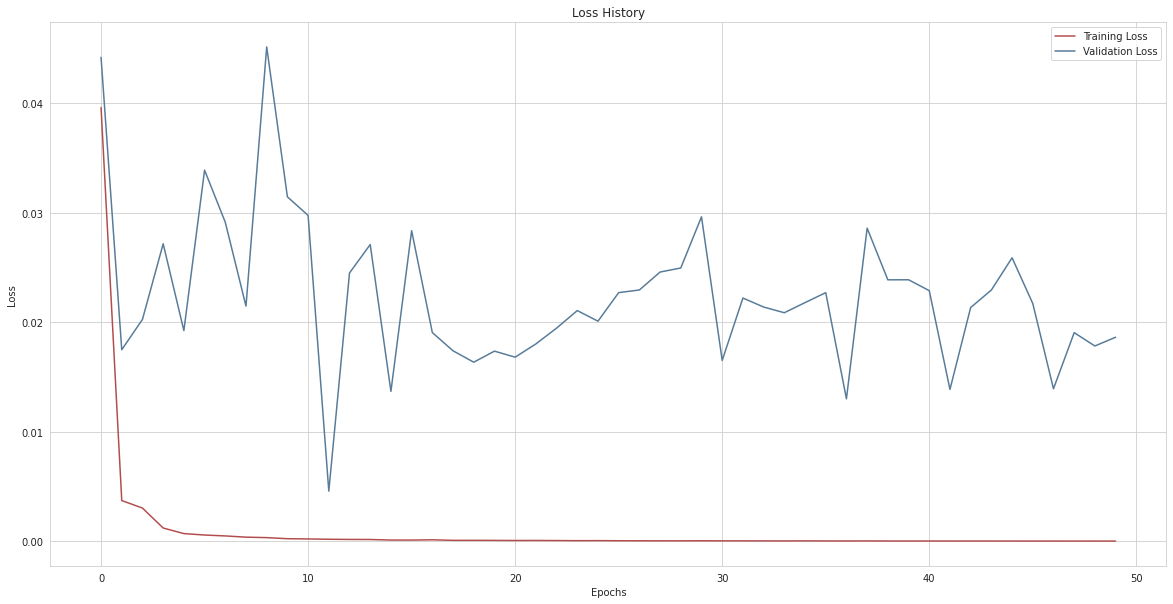

In [ ]:
plt.figure(figsize = (20,10))
sns.set_style("whitegrid")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

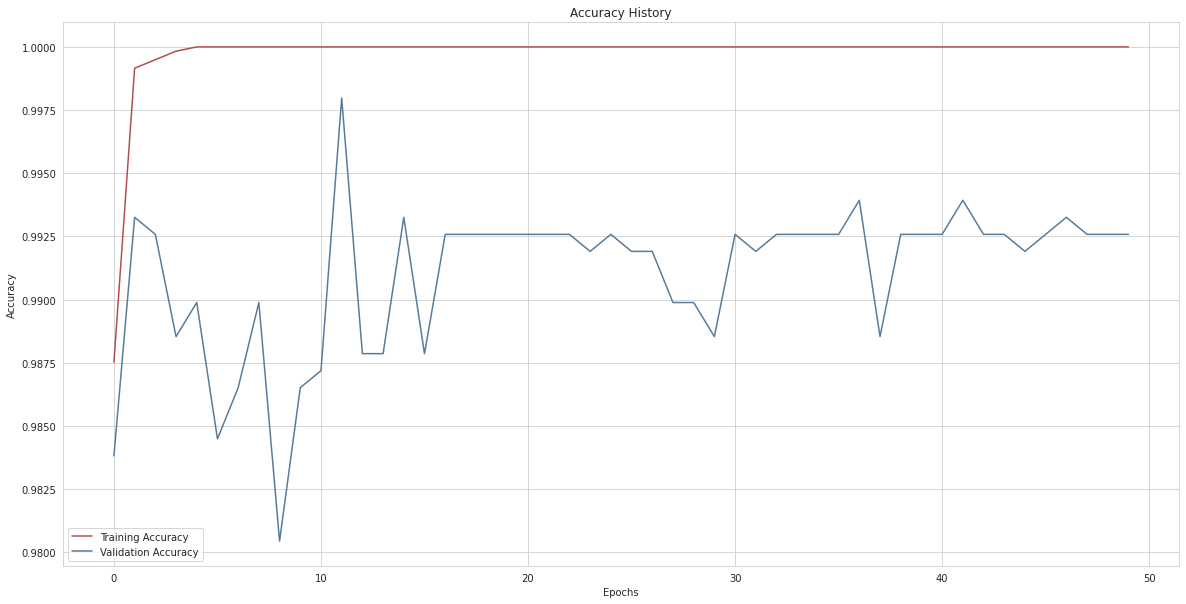

In [ ]:
# Plot the training and validation accuracy history
plt.figure(figsize = (20,10))
sns.set_style("whitegrid")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Part Two

## Load Data

Human Activity Recognition contains the following files:

- **RawData/acc_expXX_userYY.txt**: contains the raw triaxial acceleration signals for each user and experiment. Each row of the file represents one acceleration sample (three-axis) captured at a frequency of 50Hz.

- **RawData/gyro_expXX_userYY.txt**: contains the raw triaxial angular speed signals for each user and experiment. Each row of the file represents one angular velocity sample (three-axis) captured at a frequency of 50Hz.

- **RawData/labels.txt**: includes all the activity labels available for the dataset. Each row of the file contains the following information:

 - Experiment number ID
 - User number ID
 - Activity number ID
 - Label start point (in number of signal log samples recorded at 50Hz)
 - Label end point (in number of signal log samples recorded at 50Hz)

Example:  The file name format is "**acc_expXX_userYY.txt**", where XX is the experiment number and YY is the user number.



In [ ]:
# Load the labels file
labels_df = pd.read_csv(google_driver_path + 'RawData/labels.txt', header=None, names=['experiment_id', 'user_id', 'activity_id', 'start_index', 'end_index'], sep='\s+')

In [ ]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   experiment_id  1214 non-null   int64
 1   user_id        1214 non-null   int64
 2   activity_id    1214 non-null   int64
 3   start_index    1214 non-null   int64
 4   end_index      1214 non-null   int64
dtypes: int64(5)
memory usage: 47.5 KB


In [ ]:
labels_df.head(2)

experiment_id  user_id  activity_id  start_index  end_index
0              1        1            5          250       1232
1              1        1            7         1233       1392

Creating two dataframes **acc_df** and **gyro_df** containing x,y,z data from all acc_expXX_userYY files and gyro_expXX_userYY files respectively along with their corresponding Experiment number ID, User number ID and Activity number ID

In [ ]:
experiments_ids = labels_df['experiment_id'].unique()
print(experiments_ids)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61]


In [ ]:
#get a list of all files paths in RawData folder
folder = paths = google_driver_path + 'RawData/*'
paths = get_file_paths(folder)

# create a dataframe from the files paths list
paths_df = pd.DataFrame(paths, index=range(1, len(paths)+1), columns=['file_path'])

#list of acc files paths
acc_paths_df = paths_df[paths_df['file_path'].str.contains('acc_')]
#list of gyro files paths
gyro_paths_df = paths_df[paths_df['file_path'].str.contains('gyro')]

print("Total number of gyro files", gyro_paths_df.shape[0])
print("Total number of acc files", acc_paths_df.shape[0])

Total number of gyro files 61
Total number of acc files 61


In [ ]:
acc_paths_df.head()

file_path
1  /content/gdrive/My Drive/IoT Final Project/HAP...
2  /content/gdrive/My Drive/IoT Final Project/HAP...
3  /content/gdrive/My Drive/IoT Final Project/HAP...
4  /content/gdrive/My Drive/IoT Final Project/HAP...
5  /content/gdrive/My Drive/IoT Final Project/HAP...

In [ ]:
gyro_paths_df.head()

file_path
62  /content/gdrive/My Drive/IoT Final Project/HAP...
63  /content/gdrive/My Drive/IoT Final Project/HAP...
64  /content/gdrive/My Drive/IoT Final Project/HAP...
65  /content/gdrive/My Drive/IoT Final Project/HAP...
66  /content/gdrive/My Drive/IoT Final Project/HAP...

The indexes of the acc files range from 1 to 61, and the indexes of the gyro files range from 62 to 122.

The function below combining two data frames, one for the acceleration (acc) data, and the other for the gyroscope (gyro) data, into a single data frame. This combined data frame is then stored in a dictionary, with the key of the format 'expXX_userYY', where 'XX' represents the experiment number, and 'YY' represents the user number.

To achieve this, the code loops over each 'acc' file (indexes 1 to 61), and extracts the experiment and user numbers from the file name to create the dictionary key. The 'acc' file is then loaded into a data frame, and the corresponding 'gyro' file (indexes 62 to 122) is loaded into another data frame. These two data frames are concatenated into a single data frame, which is then stored in the dictionary, with the key being the 'expXX_userYY' format.

In [ ]:
signals_dic  = import_Raw_Data(folder)

The dictonary "signals_dic" contains a collection of dataframes, where each key follows the format "expXX_userYY", with "XX" representing the experiment ID and "YY" representing the user ID

In [ ]:
signals_dic.keys()

dict_keys(['exp01_user01', 'exp02_user01', 'exp03_user02', 'exp04_user02', 'exp05_user03', 'exp06_user03', 'exp07_user04', 'exp08_user04', 'exp09_user05', 'exp10_user05', 'exp11_user06', 'exp12_user06', 'exp13_user07', 'exp14_user07', 'exp15_user08', 'exp16_user08', 'exp17_user09', 'exp18_user09', 'exp19_user10', 'exp20_user10', 'exp21_user10', 'exp22_user11', 'exp23_user11', 'exp24_user12', 'exp25_user12', 'exp26_user13', 'exp27_user13', 'exp28_user14', 'exp29_user14', 'exp30_user15', 'exp31_user15', 'exp32_user16', 'exp33_user16', 'exp34_user17', 'exp35_user17', 'exp36_user18', 'exp37_user18', 'exp38_user19', 'exp39_user19', 'exp40_user20', 'exp41_user20', 'exp42_user21', 'exp43_user21', 'exp44_user22', 'exp45_user22', 'exp46_user23', 'exp47_user23', 'exp48_user24', 'exp49_user24', 'exp50_user25', 'exp51_user25', 'exp52_user26', 'exp53_user26', 'exp54_user27', 'exp55_user27', 'exp56_user28', 'exp57_user28', 'exp58_user29', 'exp59_user29', 'exp60_user30', 'exp61_user30'])

In [ ]:
# example:
signals_dic['exp05_user03'].head()

accX      accY      accZ     gyroX     gyroY     gyroZ
0  0.500000 -0.006944  0.856944  0.054978 -0.083383  0.044899
1  0.518056 -0.012500  0.847222  0.117286  0.071777  0.018021
2  0.518056 -0.012500  0.847222  0.089797 -0.008552 -0.009163
3  0.518056 -0.012500  0.847222  0.089797 -0.008552 -0.009163
4  0.509722  0.006944  0.848611  0.062308 -0.019242 -0.026878

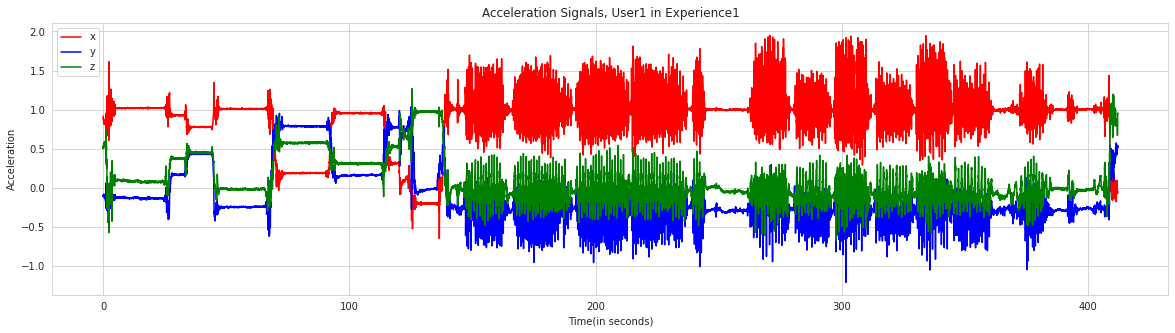

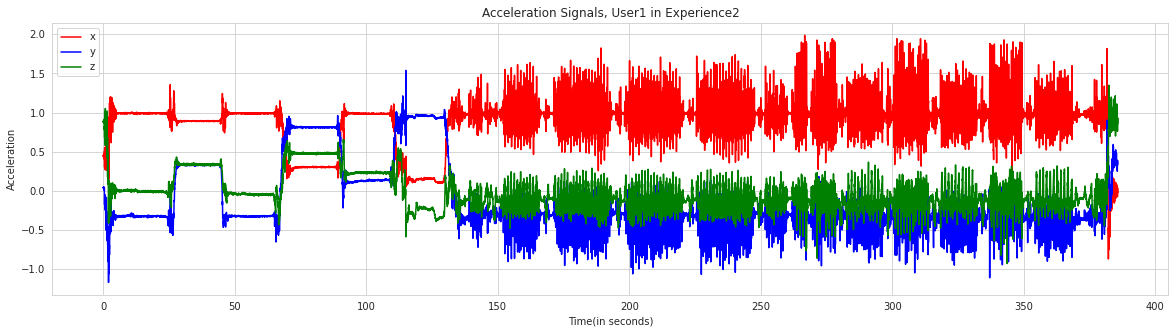

In [ ]:
for exp_id in range(1, 3):
    for user_id in range(1, 2):
        key = f"exp{exp_id :02d}_user{user_id:02d}"
        if key in signals_dic:
            df = signals_dic[key]
            fig_title = f"Acceleration Signals, User{user_id} in Experience{exp_id}"

            plot_signal(df =df ,fig_title=fig_title,signal_type='a')
            print()

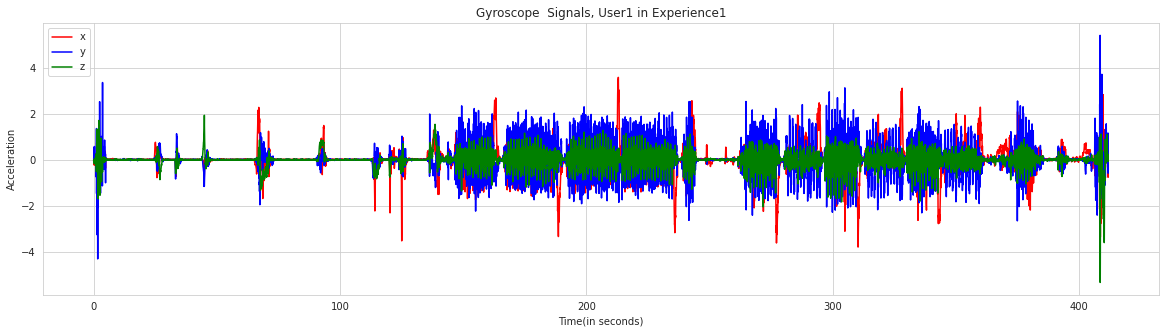

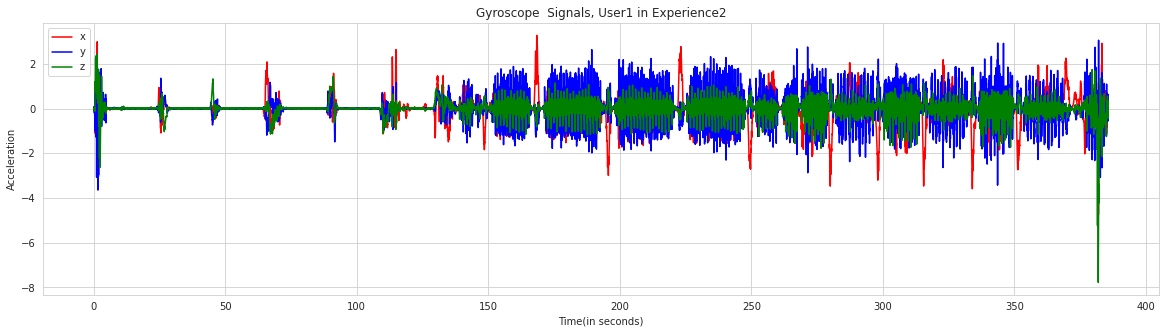

In [ ]:
for exp_id in range(1, 3):
    for user_id in range(1, 2):
        key = f"exp{exp_id :02d}_user{user_id:02d}"
        if key in signals_dic:
            df = signals_dic[key]
            fig_title = f"Gyroscope  Signals, User{user_id} in Experience{exp_id}"

            plot_signal(df =df ,fig_title=fig_title,signal_type='g')
            print()

The file associated with the first row is **acc_exp01_user01.txt**.

The data was collected at a frequency of 50Hz for the x, y, and z-axis values. In order to generate a corresponding timestamp for each data point, I will use the following method:

**time_points = np.arange(start_index, end_index+1) / sampling_freq**

Here, **start_index** and **end_index** are the indices of the first and last data points for the activity, and **sampling_freq** is the frequency at which the data was collected (in this case, 50Hz). The resulting **time_points** array will contain a timestamp for each data point in the activity.

The np.arange(start_index, end_index+1) generates a range of indices from start_index to end_index, and adding 1 to end_index is necessary to include the last index in the range.

In [ ]:
# Define the file naming convention
filename_template = 'RawData/acc_exp{:02d}_user{:02d}.txt'

# Define the column names for the signal data
column_names = ['x', 'y', 'z']

# Define the sampling frequency
sampling_freq = 50

In [ ]:
time_series_data = []
for i, row in labels_df.iterrows():
    # Extract the activity label and start/end indices
    activity_id = row['activity_id']
    start_index = row['start_index']
    end_index = row['end_index']
    
    # Construct the file name for the signal data
    filename = filename_template.format(row['experiment_id'], row['user_id'])

    # Load the signal data for the corresponding activity
    signal_data = pd.read_csv(google_driver_path + filename, header=None, delimiter='\s+', names=column_names)

    ##########################################################################################################################################################
    #The label file specifies a specific time interval (from start point to end point) during which a specific activity was performed.                       #
    #In order to associate the sensor data with the activity labels, we will need to first extract the time intervals for each activity from the label file, #
    #and then find the corresponding records in the sensor data file that fall within those time intervals.                                                  #
    ##########################################################################################################################################################

    #####################################################################################################################################################
    # Compute the time indices for the signal data                                                                                                      #
    # In this step, np.arange(start_index, end_index+1) creates an array of consecutive integers starting from start_index and ending with end_index+1. # 
    # Dividing this array by the sampling_freq scales the integers to their corresponding times in seconds, assuming a sampling frequency of 50 Hz.     #
    # For example, if the start_index is 100 and the end_index is 150,                                                                                  #
    # then np.arange(start_index, end_index+1) will produce the array [100, 101, 102, ..., 149, 150].                                                   #
    # Dividing this array by 50 gives the corresponding times in seconds: [2.0, 2.02, 2.04, ..., 2.98, 3.0].                                            #
    # This step essentially creates a time index for each sample in the signal, based on the sampling frequency.                                        #
    #####################################################################################################################################################
    time_indices = np.arange(start_index, end_index+1) / sampling_freq

    # Extract the time series data for the activity
    activity_data = signal_data.loc[start_index:end_index]
    activity_data['time'] = time_indices
    activity_data['activity_id'] = activity_id

    # Append the activity data to the list of time series data
    time_series_data.append(activity_data)

# Concatenate the time series data into a single DataFrame
time_series_df = pd.concat(time_series_data, axis=0)

In [ ]:
time_series_df.columns

Index(['x', 'y', 'z', 'time', 'activity_id'], dtype='object')

In [ ]:
activity_labels_df.columns

Index(['ActivityID', 'ActivityName'], dtype='object')

In [ ]:
unique_values = time_series_df['activity_id'].unique()
print(unique_values)

[ 5  7  4  8 11  6 10  9 12  1  3  2]


In [ ]:
labels_df['activity_id'] = activity_labels_df['ActivityID']
labels_df['activity_name'] = activity_labels_df['ActivityName']

In [ ]:
time_series_df1 = pd.merge(time_series_df, labels_df, on='activity_id')

In [ ]:
time_series_df1.columns

Index(['x', 'y', 'z', 'time', 'activity_id', 'experiment_id', 'user_id',
       'start_index', 'end_index', 'activity_name'],
      dtype='object')

In [ ]:
time_series_df1.shape

(815614, 10)

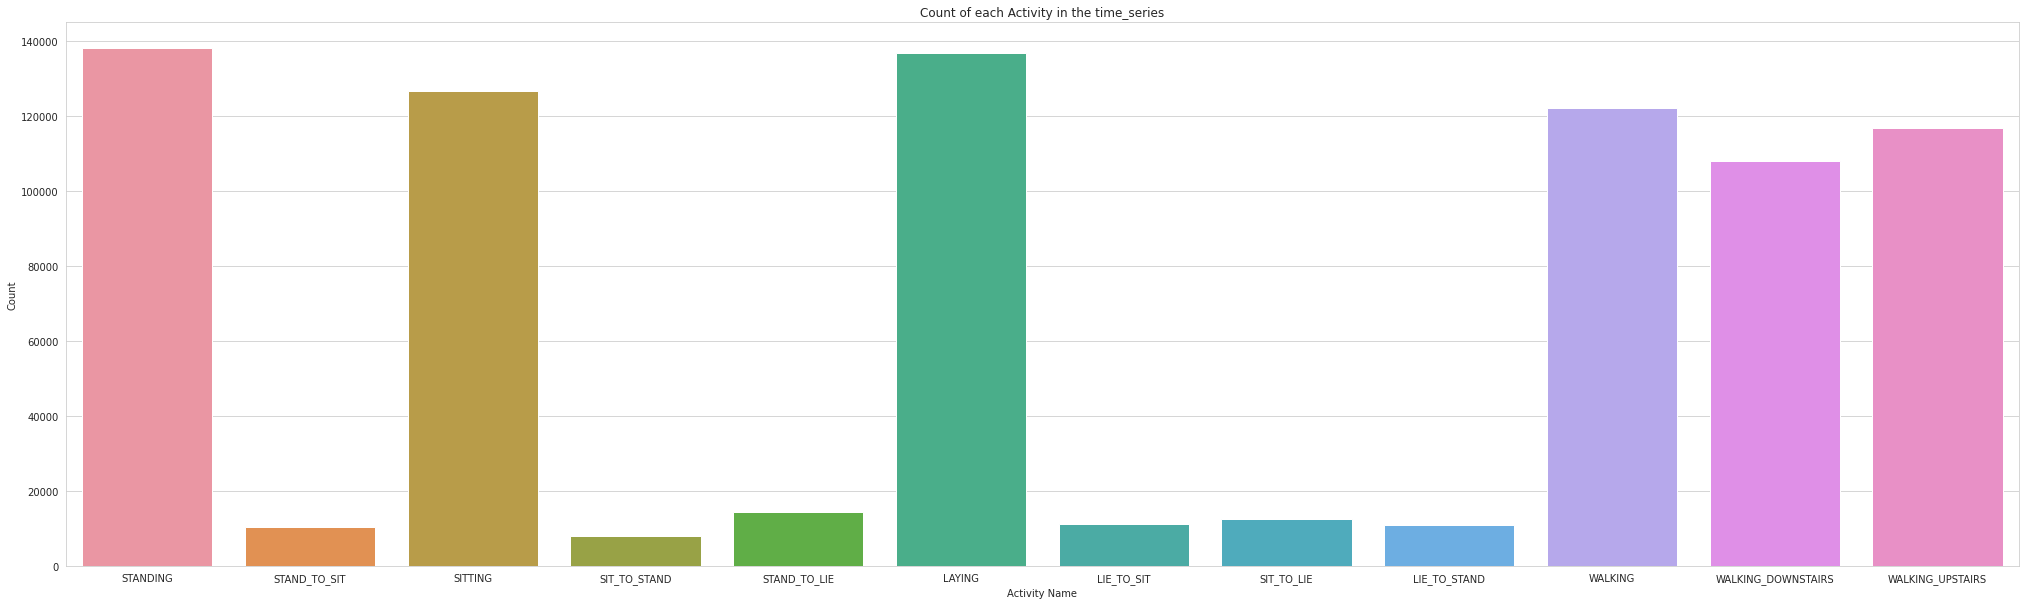

In [ ]:
_plot_count(
    x='activity_name',
    data=time_series_df1,
    plt_title='Count of each Activity in the time_series',
    x_label ='Activity Name',
    y_label='Count',
    figsize_w= 35,
    figsize_h= 10)

In [ ]:
time_series_df1.columns

Index(['x', 'y', 'z', 'time', 'activity_id', 'experiment_id', 'user_id',
       'start_index', 'end_index', 'activity_name'],
      dtype='object')

In [ ]:
activity_type_id_map = {'SITTING': 0, 'STANDING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1}

In [ ]:
time_series_df1.head(20)

x         y         z  time  activity_id  experiment_id  user_id  \
0   1.020833 -0.125000  0.105556  5.00            5              1        1   
1   1.025000 -0.125000  0.101389  5.02            5              1        1   
2   1.020833 -0.125000  0.104167  5.04            5              1        1   
3   1.016667 -0.125000  0.108333  5.06            5              1        1   
4   1.018056 -0.127778  0.108333  5.08            5              1        1   
5   1.018056 -0.129167  0.104167  5.10            5              1        1   
6   1.019445 -0.125000  0.101389  5.12            5              1        1   
7   1.016667 -0.123611  0.097222  5.14            5              1        1   
8   1.020833 -0.127778  0.098611  5.16            5              1        1   
9   1.019445 -0.115278  0.094444  5.18            5              1        1   
10  1.019445 -0.119444  0.094444  5.20            5              1        1   
11  1.022222 -0.120833  0.100000  5.22            5              1        1   
12  1.019445 -0.120833  0.100000  5.24            5              1        1   
13  1.016667 -0.120833  0.095833  5.26            5              1        1   
14  1.019445 -0.120833  0.097222  5.28            5              1        1   
15  1.019445 -0.122222  0.098611  5.30            5              1        1   
16  1.020833 -0.120833  0.098611  5.32            5              1        1   
17  1.020833 -0.125000  0.101389  5.34            5              1        1   
18  1.018056 -0.127778  0.100000  5.36            5              1        1   
19  1.020833 -0.125000  0.101389  5.38            5              1        1   

    start_index  end_index activity_name  
0          2360       3374      STANDING  
1          2360       3374      STANDING  
2          2360       3374      STANDING  
3          2360       3374      STANDING  
4          2360       3374      STANDING  
5          2360       3374      STANDING  
6          2360       3374      STANDING  
7          2360       3374      STANDING  
8          2360       3374      STANDING  
9          2360       3374      STANDING  
10         2360       3374      STANDING  
11         2360       3374      STANDING  
12         2360       3374      STANDING  
13         2360       3374      STANDING  
14         2360       3374      STANDING  
15         2360       3374      STANDING  
16         2360       3374      STANDING  
17         2360       3374      STANDING  
18         2360       3374      STANDING  
19         2360       3374      STANDING

In [ ]:
time_series_df1.shape

(815614, 10)

In [ ]:
time_series_last_1000 = time_series_df1.head(1000)

In [ ]:
time_series_last_1000

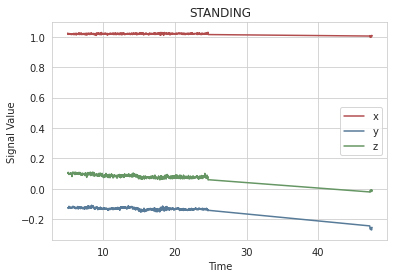

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique activity names
#activity_names = time_series_df1['activity_name'].unique()

activity_names= ['STANDING']
# Create a line plot for each activity
for activity_name in activity_names:
    # Get data for the current activity
    activity_data = time_series_last_1000[time_series_last_1000['activity_name'] == activity_name]
    
    # Plot the x, y, and z signals over time
    sns.lineplot(x='time', y='x', data=activity_data, label='x')
    sns.lineplot(x='time', y='y', data=activity_data, label='y')
    sns.lineplot(x='time', y='z', data=activity_data, label='z')
    
    # Set plot title and axis labels
    plt.title(activity_name)
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    
    # Show legend and plot
    plt.legend()
    plt.show()

In [ ]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
time_series_df1.columns

Index(['x', 'y', 'z', 'time', 'activity_id', 'experiment_id', 'user_id',
       'start_index', 'end_index', 'activity_name'],
      dtype='object')

In [ ]:
unique_values = time_series_df1['activity_name'].unique()
print(unique_values)

['STANDING' 'STAND_TO_SIT' 'SITTING' 'WALKING' 'SIT_TO_STAND'
 'STAND_TO_LIE' 'LAYING' 'LIE_TO_SIT' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS' 'SIT_TO_LIE' 'LIE_TO_STAND']


In [ ]:
time_series_df1 = time_series_df1.sort_values(by = ['user_id', 'time'], ignore_index=True)

In [ ]:
time_series_df1 = time_series_df1[time_series_df1['activity_id'] < 7]

In [ ]:
unique_values = time_series_df1['activity_name'].unique()
print(unique_values)

['STANDING' 'SITTING' 'WALKING' 'LAYING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [ ]:
X_train = time_series_df1[['activity_name','user_id','time','x', 'y', 'z']]
y_train = time_series_df1['activity_id']

In [ ]:
from scipy import stats

random_seed = 42   
n_time_steps = 125 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015
segments = []
labels = []

for i in range(0,  time_series_df1.shape[0]- n_time_steps, step):  

    xs = time_series_df1['x'].values[i: i + 125]

    ys = time_series_df1['y'].values[i: i + 125]

    zs = time_series_df1['z'].values[i: i + 125]

    label = stats.mode(time_series_df1['activity_name'][i: i + 125])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
labels

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/50
47/47 [==============================] - 97s 2s/step - loss: 0.9558 - accuracy: 0.5653 - val_loss: 0.7889 - val_accuracy: 0.6397
Epoch 2/50
47/47 [==============================] - 107s 2s/step - loss: 0.8101 - accuracy: 0.6236 - val_loss: 0.7616 - val_accuracy: 0.6462
Epoch 3/50
47/47 [==============================] - 95s 2s/step - loss: 0.7722 - accuracy: 0.6472 - val_loss: 0.7192 - val_accuracy: 0.6784
Epoch 4/50
47/47 [==============================] - 108s 2s/step - loss: 0.7350 - accuracy: 0.6761 - val_loss: 0.6934 - val_accuracy: 0.7030
Epoch 5/50
47/47 [==============================] - 96s 2s/step - loss: 0.7549 - accuracy: 0.6659 - val_loss: 0.6848 - val_accuracy: 0.7106
Epoch 6/50
47/47 [==============================] - 98s 2s/step - loss: 0.6712 - accuracy: 0.7100 - val_loss: 0.6476 - val_accuracy: 0.7123
Epoch 7/50
47/47 [==============================] - 99s 2s/step - loss: 0.6057 - accuracy: 0.7343 - val_loss: 0.5722 - val_accuracy: 0.7436
Epoch 8/50
47/47 [

#Test

In [ ]:
X_train_df12 = X_train_df1.copy()

In [ ]:
df = X_train_df12.rename(columns={'ActivityID': 'activity_Id'})
df = df.rename(columns={'subject_id': 'user_Id'})
df = df.rename(columns={'ActivityName': 'activity_name'})

In [ ]:
df_win_act_usr_df = get_windows_activities_user(df)

In [ ]:
df_win_act_usr_df

activity_1  activity_2  activity_3  activity_4  activity_5  \
user_1         95.0        53.0        49.0        47.0        55.0   
user_3         58.0        59.0        49.0        52.0        63.0   
user_5         56.0        47.0        47.0        43.0        57.0   
user_6         57.0        51.0        48.0        56.0        58.0   
user_7         57.0        51.0        47.0        47.0        54.0   
user_8         48.0        41.0        38.0        45.0        57.0   
user_11        59.0        54.0        46.0        54.0        50.0   
user_14        59.0        54.0        45.0        53.0        62.0   
user_15        54.0        48.0        42.0        61.0        55.0   
user_16        51.0        51.0        47.0        67.0        80.0   
user_17        61.0        48.0        47.0        64.0        83.0   
user_19        52.0        40.0        39.0        74.0        74.0   
user_21        52.0        47.0        45.0        85.0        94.0   
user_22        46.0        42.0        36.0        62.0        65.0   
user_23        59.0        51.0        54.0        68.0        71.0   
user_25        74.0        65.0        58.0        66.0        75.0   
user_26        59.0        55.0        50.0        79.0        77.0   
user_27        57.0        51.0        44.0        72.0        82.0   
user_28        54.0        51.0        46.0        74.0        80.0   
user_29        53.0        49.0        48.0        60.0        67.0   
user_30        65.0        65.0        62.0        64.0        64.0   

         activity_6  activity_7  activity_8  activity_9  activity_10  \
user_1         48.0         3.0         2.0         4.0          3.0   
user_3         63.0         2.0         1.0         2.0          4.0   
user_5         51.0         3.0         1.0         5.0          5.0   
user_6         56.0         2.0         1.0         2.0          2.0   
user_7         50.0         0.0         0.0         4.0          1.0   
user_8         55.0         1.0         0.0         2.0          3.0   
user_11        58.0         2.0         2.0         3.0          3.0   
user_14        48.0         4.0         2.0         4.0          3.0   
user_15        74.0         2.0         1.0         4.0          2.0   
user_16        70.0         2.0         0.0         3.0          2.0   
user_17        74.0         2.0         2.0         5.0          5.0   
user_19        84.0         2.0         1.0         3.0          3.0   
user_21        90.0         2.0         1.0         4.0          4.0   
user_22        72.0         2.0         0.0         2.0          3.0   
user_23        72.0         3.0         1.0         4.0          2.0   
user_25        75.0         3.0         2.0         3.0          5.0   
user_26        76.0         2.0         1.0         3.0          2.0   
user_27        76.0         2.0         0.0         4.0          2.0   
user_28        79.0         4.0         1.0         4.0          0.0   
user_29        69.0         2.0         2.0         6.0          3.0   
user_30        73.0         2.0         2.0         4.0          3.0   

         activity_11  activity_12  
user_1           6.0          3.0  
user_3           4.0          2.0  
user_5           7.0          2.0  
user_6           6.0          3.0  
user_7           4.0          3.0  
user_8           4.0          1.0  
user_11          3.0          3.0  
user_14          7.0          5.0  
user_15          5.0          3.0  
user_16          4.0          2.0  
user_17          6.0          4.0  
user_19          7.0          2.0  
user_21          6.0          4.0  
user_22          2.0          3.0  
user_23          5.0          2.0  
user_25          3.0          5.0  
user_26          2.0          3.0  
user_27          3.0          1.0  
user_28          0.0          2.0  
user_29          3.0          2.0  
user_30          3.0          2.0

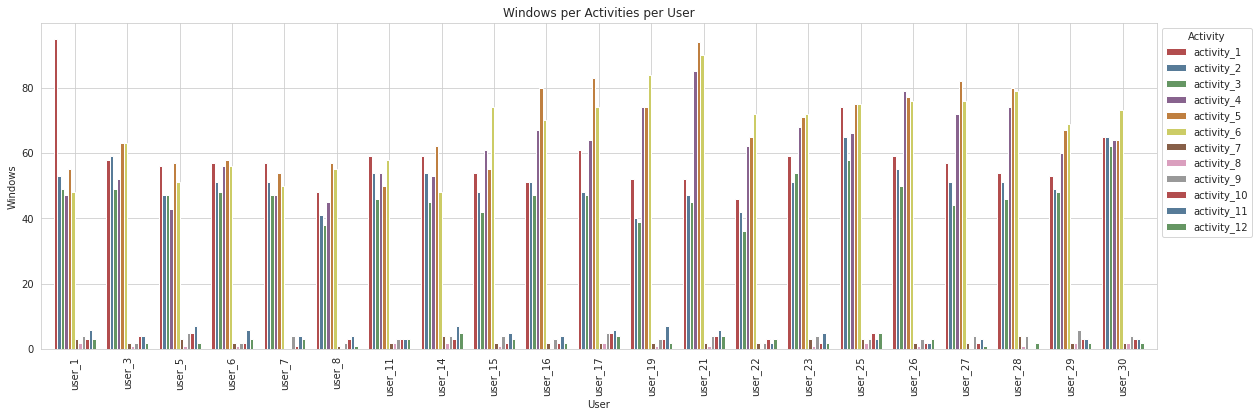

In [ ]:
# create a grouped bar plot
ax = df_win_act_usr_df.plot(kind='bar', width=0.8, figsize=(20, 6))

# customize the plot
ax.set_xlabel('User')
ax.set_ylabel('Windows')
ax.set_title('Windows per Activities per User')
ax.legend(title='Activity', bbox_to_anchor=(1.0, 1.0))
plt.show()